In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
import os
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import math
from mpl_toolkits import mplot3d
from tqdm import tqdm # progress bars

#### Guide to Jupyter commands:
* shift + enter to run selected cell
* '>>' button at top to run entire notebook (run all cells)
* square button to stop running
* circle arrow to restart kernel (have to run initial cells and import data again, avoid doing unless kernel is dead)
* x to cut/remove selected cell(s)
* c to copy selected cell(s)
* v to paste copied cell(s)
* a to create new cell above
* b to create new cell below
* ctrl/command + s to save

Notes:
* [*] next to cell means it's currently running
* changes are automatically saved

#### >> User Inputs <<

In [2]:
import_file = "20250625_WD_counts1_zscore_20250625_PBv6_BaitPreyInfo_20240529_combineIsoforms_20240521_summary_baitCre_LWcorrected_expGelNums.xlsx"
flag_mat_name = "optimized_flag_matrix_20250625_WDflagged_counts1_zscore_20250625_PBv6_BaitPreyInfo_20240531_flagged_20240529_combineIsoforms_20240521_summary_baitCre_LWcorrected_expGelNums.xlsx"

spec_sheet_name = "20250625_PBv6_BaitPreyInfo_20240529_combineIsoforms_20240521_summary_baitCre_LWcorrected_expGelNums.xlsx"

SAINT_fname = "20250630_SAINTexpress_R2L2_output.xlsx"

#### plot formatting

In [3]:

fontSize = 20
fontName = 'Arial';

plt.rcParams.update({'font.family': fontName,
                     'font.size': fontSize,
                     'axes.titlesize': fontSize,
                     'xtick.labelsize': fontSize,
                     'ytick.labelsize': fontSize,
                     'axes.formatter.use_mathtext': False})

plotStyle = {'markersize': 8, 'markeredgewidth': 3, 'linewidth': 3, 'markerfacecolor':'w'}
gridStyle = {'linewidth':0.9, 'color': 'silver'}

# colorblind friendly color scheme
color_spec = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628',
              '#984ea3', '#999999', '#e41a1c', '#dede00']


#### import data -- summary file with experiment numbers (takes a few mins)

In [4]:
# import WD scores
full_sheet = pd.read_excel(import_file, 
                           sheet_name = 0,
                           index_col = 0,
                           skiprows = 0) # load from sheet 1, start at 1st row
# note: first column is old row IDs (before removal of decoy preys)
# row indexes are current row IDs

In [5]:
# import p values
p_full_sheet = pd.read_excel(import_file,
                        sheet_name = 1,
                        index_col = 0,
                        skiprows = 0)



In [6]:
# import z scores
z_full_sheet = pd.read_excel(import_file,
                        sheet_name = 2,
                        index_col = 0,
                        skiprows = 0)

#### process full_sheet

In [7]:
# process full_sheet -- create sheet and matrix of WD scores
# sheet is dataframe bait CreID as column names, prey CreID as row indices
# matrix is numpy 2D array with just WD values

start_col = 14 # first bait is at 15th column in full_sheet
start_row = 13

bait_creID = full_sheet.loc['Bait CreID'][start_col:]
prey_creID = full_sheet['Prey CreID'].iloc[start_row:]

# localizations
bait_loc = full_sheet.loc['Bait Experimental Localization'][start_col:]
bait_loc.index = bait_creID.to_numpy()
bait_loc = bait_loc.replace(np.nan, 'N/A') # change NaNs to N/A

bait_pred_loc = full_sheet.loc['Bait PB-Chlamy Predicted Localization'][start_col:]
bait_pred_loc.index = bait_creID.to_numpy()

bait_predalgo_loc = full_sheet.loc['Bait PredAlgo Predicted Localization'][start_col:]
bait_predalgo_loc.index = bait_creID.to_numpy()

prey_pred_loc = full_sheet['Prey PB-Chlamy Predicted Localization'].iloc[start_row:]
prey_pred_loc.index = prey_creID.to_numpy()

prey_predalgo_loc = full_sheet['Prey PredAlgo Predicted Localization'].iloc[start_row:]
prey_predalgo_loc.index = prey_creID.to_numpy()

prey_exp_loc = full_sheet['Prey Experimental Localization'].iloc[start_row:]
prey_exp_loc.index = prey_creID.to_numpy()
        
# bait and prey Phytozome v6.1 info
baitInfo = full_sheet.loc['Bait Defline'][start_col:]
preyInfo = full_sheet['Prey Defline'][start_row:]

# bait and prey Phytozome v6.1 gene symbol
baitSymbol = full_sheet.loc['Bait Gene Symbol'][start_col:]
preySymbol = full_sheet['Prey Gene Symbol'][start_row:]

# GreenCut
bait_greencut = full_sheet.loc['Bait Greencut'][start_col:]
prey_greencut = full_sheet['Prey Greencut'][start_row:]


# Phytozome v6.1 Arabidopsis conservation
bait_conserve = full_sheet.loc['Bait Arabidopsis Conservation'][start_col:]
prey_conserve = full_sheet['Prey Arabidopsis Conservation'][start_row:]


# Phytozome v6.1 Arabidopsis conservation defline
bait_conserve_defline = full_sheet.loc['Bait Arabidopsis Conservation Defline'][start_col:]
prey_conserve_defline = full_sheet['Prey Arabidopsis Conservation Defline'][start_row:]

In [8]:
# create WD matrix

WD_mat = full_sheet.iloc[start_row:,start_col:].to_numpy().astype('float')
WD_nonzero = WD_mat[WD_mat > 0]

# create WD dataframe with column named with bait CreID, rows named with prey creID
WD_sheet = full_sheet.iloc[start_row:,start_col:].copy()
WD_sheet.columns = bait_creID.to_numpy()
WD_sheet.index = prey_creID.to_numpy()

num_interactions = WD_mat.shape[0]*WD_mat.shape[1]

In [9]:
# create p value matrix
p_mat = p_full_sheet.iloc[1:,start_col:].to_numpy()

# create p value dataframe
p_sheet = p_full_sheet.iloc[1:,start_col:].copy()
p_sheet.columns = bait_creID.to_numpy()
p_sheet.index = prey_creID.to_numpy()

In [10]:
# create raw z score matrix
z_mat = z_full_sheet.iloc[1:,start_col:].to_numpy()

# create p value dataframe
z_sheet = z_full_sheet.iloc[1:,start_col:].copy()
z_sheet.columns = bait_creID.to_numpy()
z_sheet.index = prey_creID.to_numpy()

In [11]:
WD_sheet

,Cre01.g002150,Cre01.g002300,Cre01.g002500,Cre01.g003200,Cre01.g004300,Cre01.g004400,Cre01.g005001,Cre01.g005050,Cre01.g007050,Cre01.g007850,...,Cre17.g734500,Cre17.g738000,Cre17.g740950,Cre17.g741000,Cre17.g741050,Cre17.g743747,Cre17.g745847,Cre17.g745997,Cre24.g755197,Venus-3xFLAG
Cre12.g551050,8.580952,5.921419,6.48659,4.531779,9.335797,6.97048,5.878971,6.97048,6.250634,4.852055,...,6.751457,4.954215,3.394226,5.66196,6.250634,5.706022,7.785195,8.162113,6.088252,5.004513
Venus-FLAG,4.949747,10.368221,5.049752,5.656854,3.605551,5.612486,5.656854,4.527693,9,7.449832,...,9.192388,5.147815,9.486833,4.358899,2.345208,3.316625,5.522681,4.690416,5.338539,7.516648
Cre06.g258800,5,6.204837,5.196152,3.464102,6.204837,4.84768,4.690416,7.071068,5.700877,4.898979,...,5.338539,4,3.872983,3.162278,4,4.1833,4.795832,6.745369,4.636809,4.358899
Cre13.g592500,5.622626,6.296257,6.256281,5.798375,7.72756,5.884282,6.093752,7.759961,5.667074,5.754941,...,5.754941,6.492449,3.47036,5.157116,5.157116,5.711177,3.879981,4.480216,4.069358,4.590855
Cre15.g635650,6.741201,4.180679,4.180679,0,3.552925,6.454208,0.891324,7.016464,6.355665,0,...,7.944581,2.956187,0,0.891324,0,0,3.565295,3.213714,5.388277,1.543818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cre03.g156600,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cre04.g216300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cre16.g653650,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cre08.g377000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# check how many bait appear as prey
np.intersect1d(WD_sheet.columns,WD_sheet.index).shape

(1053,)

#### Calculate WD Z scores

In [13]:
WD_zscore = zscore(WD_mat, 1)
WDz_df = WD_sheet.copy()
WDz_df.iloc[:,:] = WD_zscore

In [14]:
WDz_df

,Cre01.g002150,Cre01.g002300,Cre01.g002500,Cre01.g003200,Cre01.g004300,Cre01.g004400,Cre01.g005001,Cre01.g005050,Cre01.g007050,Cre01.g007850,...,Cre17.g734500,Cre17.g738000,Cre17.g740950,Cre17.g741000,Cre17.g741050,Cre17.g743747,Cre17.g745847,Cre17.g745997,Cre24.g755197,Venus-3xFLAG
Cre12.g551050,1.620039,-0.366409,0.055726,-1.404354,2.183846,0.417151,-0.398114,0.417151,-0.120513,-1.165135,...,0.253559,-1.08883,-2.254011,-0.560204,-0.120513,-0.527293,1.025675,1.307202,-0.241799,-1.051262
Venus-FLAG,-0.323982,2.477083,-0.272285,0.041555,-1.018861,0.018619,0.041555,-0.542162,1.769785,0.96843,...,1.869239,-0.221592,2.021452,-0.62942,-1.670392,-1.168221,-0.027806,-0.458043,-0.122997,1.00297
Cre06.g258800,0.001823,1.29488,0.212338,-1.646537,1.29488,-0.16165,-0.330429,2.224539,0.75402,-0.106594,...,0.365151,-1.071399,-1.207716,-1.970461,-1.071399,-0.874677,-0.217295,1.874991,-0.387961,-0.686221
Cre13.g592500,0.252227,0.824128,0.790189,0.401435,2.03928,0.474369,0.652205,2.066787,0.289963,0.364561,...,0.364561,0.990692,-1.575009,-0.142983,-0.142983,0.327405,-1.227248,-0.717659,-1.06647,-0.623728
Cre15.g635650,1.157071,0.154662,0.154662,-1.482017,-0.091096,1.044717,-1.133076,1.264833,1.006139,-1.482017,...,1.628178,-0.32471,-1.482017,-1.133076,-1.482017,-1.482017,-0.086253,-0.223892,0.62742,-0.877633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cre03.g156600,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,...,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042
Cre04.g216300,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,...,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042
Cre16.g653650,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,...,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042
Cre08.g377000,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,...,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042,-0.030042


#### convert experimental localizations to binary for chloroplast, mitochondria, and secretory pathway

In [15]:
# convert experimental localizations to binary for chloroplast, mitochondria, and secretory pathway
# (for easy comparison to prey predicted localizations)
exp_loc_list = np.unique(bait_loc)
exp_loc_binary = np.zeros([exp_loc_list.shape[0],3])
exp_loc_dict = {}

chloroplast_list = np.zeros_like(exp_loc_list)
mitochon_list = np.zeros_like(exp_loc_list)
secretory_list = np.zeros_like(exp_loc_list)


# exp_loc_summary = []

category_list = np.array([])
for i in range(exp_loc_list.shape[0]):
    loc = exp_loc_list[i]
    categories = loc.split('; ')
    for cat in categories:
        category_list = np.append(category_list, cat)
        if ('chloroplast' in cat) or ('Chloroplast' in cat):
            exp_loc_binary[i][0] = 1
            
        if ('mitochondria' in cat):
            exp_loc_binary[i][1] = 1
        
        if ('secretory' in cat):
            exp_loc_binary[i][2] = 1
            
    exp_loc_dict[loc] = exp_loc_binary[i]

In [16]:
exp_loc_dict

{'Not Found': array([0., 0., 0.]),
 'ambiguous': array([0., 0., 0.]),
 'centrosome or flagella/base of flagella': array([0., 0., 0.]),
 'centrosome or flagella/centrosome': array([0., 0., 0.]),
 'centrosome or flagella/flagella': array([0., 0., 0.]),
 'chloroplast envelope/homogeneous': array([1., 0., 0.]),
 'chloroplast envelope/homogeneous; cytosol/cytosol (strong signal)': array([1., 0., 0.]),
 'chloroplast envelope/homogeneous; shapes in cytoplasm/uncategorized shapes in cytoplasm': array([1., 0., 0.]),
 'chloroplast envelope/not homogeneous/ patches': array([1., 0., 0.]),
 'chloroplast envelope/not homogeneous/nucleus-facing patches': array([1., 0., 0.]),
 'chloroplast envelope/not homogeneous/patches': array([1., 0., 0.]),
 'chloroplast envelope/not homogeneous/patches; cytosol/cytosol (weak signal)': array([1., 0., 0.]),
 'chloroplast envelope/not homogeneous/patches; secretory pathway/lysosome': array([1., 0., 1.]),
 'chloroplast envelope/not homogeneous/patches; shapes in cyto

#### Venus detected per bait

In [17]:
num_Venus = np.sum(p_sheet.loc['Venus-FLAG']>0)
print('Of', p_sheet.shape[1]-1, 'baits, Venus detected in', num_Venus-1) # excluding Venus as bait (neg control)

Of 1108 baits, Venus detected in 1108


#### Bait detected per bait

In [18]:
bait_detected = 0

for bait in WD_sheet.columns:
    if bait in WD_sheet.index: # bait in prey set?
        if p_sheet[bait].loc[bait] > 0: # bait detected as prey in its own IP?
            bait_detected += 1

            
print('Of', p_sheet.shape[1]-1, 'baits, bait itself detected in', bait_detected-1) # excluding Venus as bait (neg control)

# note: baits already filtered out for in v5 but not v6 --> all baits appear in both


Of 1108 baits, bait itself detected in 978


#### create interaction_df

In [19]:
# create list of each interaction with: (takes a few mins)
# bait CreID, prey CreID, 
# bait and prey localization (binary columns for chloroplast, mitochondria, secretory)
# WD score, raw z score, WD z score, p value


baitID_col = np.empty(num_interactions, dtype='O')
baitInfo_col = np.empty(num_interactions, dtype='O')
preyID_col = np.empty(num_interactions, dtype='O')
preyInfo_col = np.empty(num_interactions, dtype='O')

baitSymbol_col = np.empty(num_interactions, dtype='O')
preySymbol_col = np.empty(num_interactions, dtype='O')

bait_greencut_col = np.empty(num_interactions, dtype='O')
bait_conserve_col = np.empty(num_interactions, dtype='O')
bait_conserve_defline_col = np.empty(num_interactions, dtype='O')

prey_greencut_col = np.empty(num_interactions, dtype='O')
prey_conserve_col = np.empty(num_interactions, dtype='O')
prey_conserve_defline_col = np.empty(num_interactions, dtype='O')

bait_loc_col = np.empty(num_interactions, dtype='O') # experimental
bait_pred_loc_col = np.empty(num_interactions, dtype='O') # PB-Chlamy
bait_predalgo_loc_col = np.empty(num_interactions, dtype='O') # PredAlgo

prey_loc_col =  np.empty(num_interactions, dtype='O') # PB-Chlamy
prey_exp_loc_col = np.empty(num_interactions, dtype='O') # experimental
prey_predalgo_loc_col = np.empty(num_interactions, dtype='O') # PredAlgo
loc_match_col = np.zeros(num_interactions) # compare bait experimental to prey PB-Chlamy
bait_loc_array = np.zeros((num_interactions,3)) # based on bait experimental

WD_col = np.zeros(num_interactions, dtype='float')
p_col = np.zeros(num_interactions)
z_col = np.zeros(num_interactions, dtype='float')
WDz_col = np.zeros(num_interactions, dtype='float')

index = 0 # interaction index
for i in tqdm(range(bait_creID.shape[0])): # loop over baits
    bait_loc_mat = exp_loc_dict[bait_loc.iloc[i]]
    bait = bait_creID.iloc[i]
    
    for j in range(prey_creID.shape[0]): # loop over preys
        prey = prey_creID.iloc[j]
        
        baitID_col[index] = bait_creID.iloc[i]
        preyID_col[index] = prey_creID.iloc[j]
        
        # bait and prey Phytozome v6.1 info and gene symbol
        baitInfo_col[index] = baitInfo[i]
        preyInfo_col[index] = preyInfo[j]
        
        baitSymbol_col[index] = baitSymbol[i]
        preySymbol_col[index] = preySymbol[j]
        
        # localizations    
        prey_loc = prey_pred_loc.iloc[j]
        bait_loc_col[index] = bait_loc.iloc[i]
        prey_loc_col[index] = prey_loc
        bait_loc_array[index] = bait_loc_mat
        
        bait_pred_loc_col[index] = bait_pred_loc[i]
        bait_predalgo_loc_col[index] = bait_predalgo_loc[i]
        prey_exp_loc_col[index] = prey_exp_loc[j]
        prey_predalgo_loc_col[index] = prey_predalgo_loc[j]
        
        # check if any overlap in localization of bait experimental and prey PB-Chlamy predicted loc
        loc_match_col[index] = ((('Chloroplast' in prey_loc) and (bait_loc_mat[0] == 1))
                     or (('Mitochondrial' in prey_loc) and (bait_loc_mat[1] == 1))
                     or (('Secretory' in prey_loc) and (bait_loc_mat[2] == 1)))
        
        # GreenCut
        bait_greencut_col[index] = bait_greencut[i]
        prey_greencut_col[index] = prey_greencut[j]
        
        
        # Phytozome v6.1 Arabidopsis conservation
        bait_conserve_col[index] = bait_conserve[i]
        prey_conserve_col[index] = prey_conserve[j]
        
        
        # Phytozome v6.1 Arabidopsis conservation defline
        bait_conserve_defline_col[index] = bait_conserve_defline[i]
        prey_conserve_defline_col[index] = prey_conserve_defline[j]
        
        
        # scores
        WD_col[index] = WD_mat[j][i]
        p_col[index] = p_mat[j][i]
        WDz_col[index] = WD_zscore[j][i]
        z_col[index] = z_mat[j][i]

        index += 1 # increment interaction index

100%|███████████████████████████████████████| 1109/1109 [13:48<00:00,  1.34it/s]


In [20]:
# create dataframe of interactions
interaction_df = pd.DataFrame(data=baitID_col, columns=['Bait CreID'])
interaction_df['Bait Gene Symbol'] = baitSymbol_col
interaction_df['Bait Info'] = baitInfo_col
interaction_df['Prey CreID'] = preyID_col
interaction_df['Prey Gene Symbol'] = preySymbol_col
interaction_df['Prey Info'] = preyInfo_col
interaction_df['WD Score'] = WD_col
interaction_df['Z Score'] = z_col
interaction_df['WD Z Score'] = WDz_col

interaction_df['Bait Experimental Localization'] = bait_loc_col
interaction_df['Bait PB-Chlamy Predicted Localization'] = bait_pred_loc_col
interaction_df['Bait PredAlgo Predicted Localization'] = bait_predalgo_loc_col

interaction_df['Prey PB-Chlamy Predicted Localization'] = prey_loc_col
interaction_df['Prey Experimental Localization'] = prey_exp_loc_col
interaction_df['Prey PredAlgo Predicted Localization'] = prey_predalgo_loc_col

interaction_df['Bait GreenCut'] = bait_greencut_col
interaction_df['Bait Conservation'] = bait_conserve_col
interaction_df['Bait Conservation Defline'] = bait_conserve_defline_col

interaction_df['Prey GreenCut'] = prey_greencut_col
interaction_df['Prey Conservation'] = prey_conserve_col
interaction_df['Prey Conservation Defline'] = prey_conserve_defline_col

interaction_df['Localization Match'] = loc_match_col
interaction_df['p Value'] = p_col

In [21]:
extra_df = interaction_df.copy()
extra_df['Bait Loc Chloro'] = bait_loc_array[:,0]
extra_df['Bait Loc Mito'] = bait_loc_array[:,1]
extra_df['Bait Loc Secretory'] = bait_loc_array[:,2]

#### create list of interactions with matching/not matching localizations

In [22]:
# get interactions where bait and prey localize to chloroplast
match_loc_list = interaction_df[interaction_df['Localization Match'] == 1]

chloro_list = match_loc_list[match_loc_list['Prey PB-Chlamy Predicted Localization'] == "Chloroplast"]
mito_list = match_loc_list[match_loc_list['Prey PB-Chlamy Predicted Localization'] == "Mitochondrial"]
secretory_list = match_loc_list[match_loc_list['Prey PB-Chlamy Predicted Localization'] == "Secretory"]

In [23]:
no_match_loc_list = interaction_df[interaction_df['Localization Match'] == 0]

nonzero_match = match_loc_list[match_loc_list['WD Score'] > 0]
zero_match = match_loc_list[match_loc_list['WD Score'] == 0]
nonzero_no_match = no_match_loc_list[no_match_loc_list['WD Score'] > 0]
zero_no_match = no_match_loc_list[no_match_loc_list['WD Score'] == 0]

In [24]:
# test localization match algorithm:

test_bait_loc = np.array(['chloroplast', 'mitochondria', 'secretory pathway', 'cytosol', 
            'chloroplast; mitochondria', 'chloroplast; cytosol', 'chloroplast; secretory',
            'secretory; cytosol'])

test_prey_loc = np.array(['Chloroplast', 'Mitochondrial','Secretory Pathway','Other','Chloroplast; Mitochondrial', 
                    'Mitochondrial; Secretory'])

# convert experimental localizations to binary for chloroplast, mitochondria, and secretory pathway
# (for easy comparison to prey predicted localizations)
test_exp_loc_list = np.unique(test_bait_loc)
test_exp_loc_binary = np.zeros([test_exp_loc_list.shape[0],3])
test_exp_loc_dict = {}

chloroplast_list = np.zeros_like(test_exp_loc_list)
mitochon_list = np.zeros_like(test_exp_loc_list)
secretory_list = np.zeros_like(test_exp_loc_list)


# test_exp_loc_summary = []

test_category_list = np.array([])
for i in range(test_exp_loc_list.shape[0]):
    loc = test_exp_loc_list[i]
    categories = loc.split('; ')
    for cat in categories:
        test_category_list = np.append(test_category_list, cat)
        if ('chloroplast' in cat) or ('Chloroplast' in cat):
            test_exp_loc_binary[i][0] = 1
            
        if ('mitochondria' in cat):
            test_exp_loc_binary[i][1] = 1
        
        if ('secretory' in cat):
            test_exp_loc_binary[i][2] = 1
            
    test_exp_loc_dict[loc] = test_exp_loc_binary[i]

for b in test_bait_loc:
    for p in test_prey_loc:
        test_bait_loc_mat = test_exp_loc_dict[b]
        loc_match = (('Chloroplast' in p) and (test_bait_loc_mat[0] == 1)
                     or ('Mitochondrial' in p) and (test_bait_loc_mat[1] == 1)
                     or ('Secretory' in p) and (test_bait_loc_mat[2] == 1))
        
        print(b,p,test_bait_loc_mat,loc_match)

chloroplast Chloroplast [1. 0. 0.] True
chloroplast Mitochondrial [1. 0. 0.] False
chloroplast Secretory Pathway [1. 0. 0.] False
chloroplast Other [1. 0. 0.] False
chloroplast Chloroplast; Mitochondrial [1. 0. 0.] True
chloroplast Mitochondrial; Secretory [1. 0. 0.] False
mitochondria Chloroplast [0. 1. 0.] False
mitochondria Mitochondrial [0. 1. 0.] True
mitochondria Secretory Pathway [0. 1. 0.] False
mitochondria Other [0. 1. 0.] False
mitochondria Chloroplast; Mitochondrial [0. 1. 0.] True
mitochondria Mitochondrial; Secretory [0. 1. 0.] True
secretory pathway Chloroplast [0. 0. 1.] False
secretory pathway Mitochondrial [0. 0. 1.] False
secretory pathway Secretory Pathway [0. 0. 1.] True
secretory pathway Other [0. 0. 1.] False
secretory pathway Chloroplast; Mitochondrial [0. 0. 1.] False
secretory pathway Mitochondrial; Secretory [0. 0. 1.] True
cytosol Chloroplast [0. 0. 0.] False
cytosol Mitochondrial [0. 0. 0.] False
cytosol Secretory Pathway [0. 0. 0.] False
cytosol Other [0. 

### calculate WD score stats

In [25]:
# WD score above 0
num_nonzero_match = nonzero_match.shape[0]
num_zero_match = zero_match.shape[0]
num_nonzero_no_match = nonzero_no_match.shape[0]
num_zero_no_match = zero_no_match.shape[0]

num_nonzero = interaction_df[interaction_df['WD Score'] > 0].shape[0]
num_match = match_loc_list.shape[0]

print('%.3f percent of matching localization pairs have nonzero WD' %(num_nonzero_match/num_match*100))
print('%.3f percent of nonzero WD pairs have matching localization' %(num_nonzero_match/num_nonzero*100))

7.359 percent of matching localization pairs have nonzero WD
15.936 percent of nonzero WD pairs have matching localization


In [26]:
# WD score above top ~3.78 percent
WD_threshold = np.percentile(WD_mat[WD_mat>0], 100-3.78, axis=None)
nonzero_match = match_loc_list[match_loc_list['WD Score'] > WD_threshold]

num_nonzero_match = nonzero_match.shape[0]

num_nonzero = interaction_df[interaction_df['WD Score'] > WD_threshold].shape[0]
num_match = match_loc_list.shape[0]

print('%.3f percent of matching localization pairs have WD > top 3.78 percent' %(num_nonzero_match/num_match*100))
print('%.3f percent of pairs with WD > top 3.78 percent have matching localization' %(num_nonzero_match/num_nonzero*100))

0.338 percent of matching localization pairs have WD > top 3.78 percent
19.390 percent of pairs with WD > top 3.78 percent have matching localization


In [27]:
WD_threshold

35.39820300524426

In [28]:
# WD score above 200 (optimize accuracy metric)
WD_threshold = 200
nonzero_match = match_loc_list[match_loc_list['WD Score'] > WD_threshold]

num_nonzero_match = nonzero_match.shape[0]

num_nonzero = interaction_df[interaction_df['WD Score'] > WD_threshold].shape[0]
num_match = match_loc_list.shape[0]

print('%.3f percent of matching localization pairs have WD > %d' %(num_nonzero_match/num_match*100, WD_threshold))
print('%.3f percent of pairs with WD > %d have matching localization' %(num_nonzero_match/num_nonzero*100, WD_threshold))

0.093 percent of matching localization pairs have WD > 200
42.816 percent of pairs with WD > 200 have matching localization


#### Assess WD score distribution

In [29]:
# determine WD score threshold (non-zero WD scores)

top_percents = np.arange(0.1,2.1,0.01)
WD_thresh = np.zeros_like(top_percents)
for i in range(len(top_percents)):
    top_p = 100 - top_percents[i]
    WD_thresh[i] = np.percentile(WD_nonzero, top_p, axis=None)

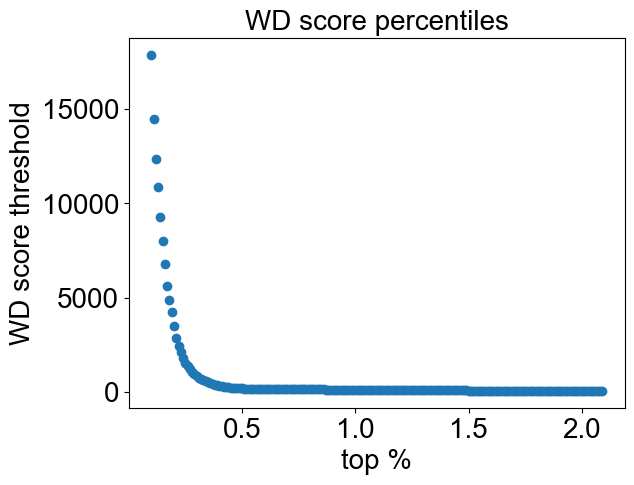

In [30]:
fig, ax = plt.subplots()

plt.rcParams.update({"figure.figsize":(4,4)}) # plot size
ax.scatter(top_percents, WD_thresh)
plt.xlabel('top %')
plt.ylabel('WD score threshold')
ax.ticklabel_format(style='plain')
plt.title('WD score percentiles')

plt.show()

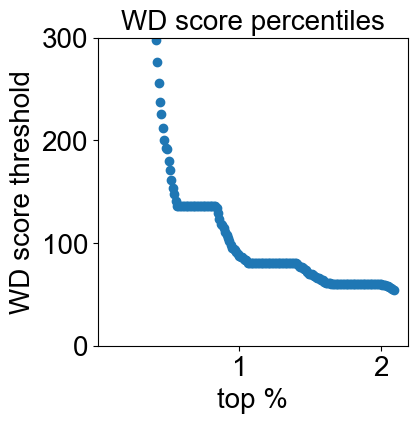

In [31]:
fig, ax = plt.subplots()

plt.rcParams.update({"figure.figsize":(4,4)}) # plot size
ax.scatter(top_percents, WD_thresh)
plt.xlabel('top %')
plt.ylabel('WD score threshold')
ax.ticklabel_format(style='plain')
plt.title('WD score percentiles')

plt.ylim([0,300])

plt.show()

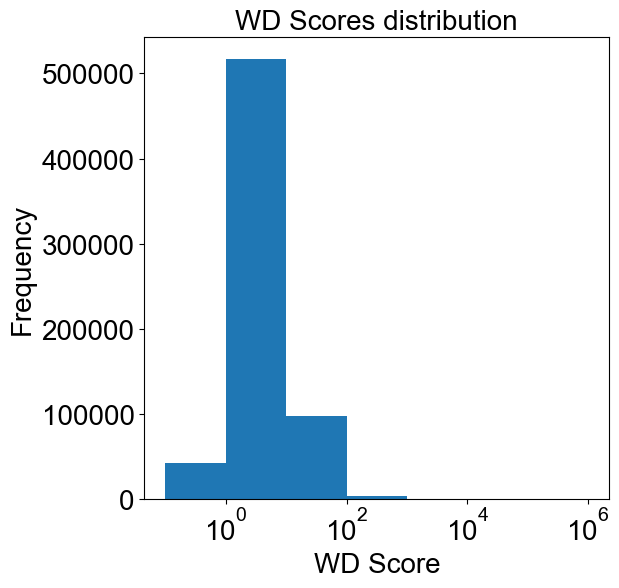

In [32]:
# WD score histogram
plt.rcParams.update({"figure.figsize":(6,6)})

fig_p, ax_p = plt.subplots()
vals = WD_mat.flatten()
counts = plt.hist(vals, bins=[0.1, 1, 10, 100, 1000, 10000, 100000, 1000000])
# ax_p.set_yscale('log')
ax_p.set_xscale('log')

plt.xlabel('WD Score')
plt.ylabel('Frequency')
plt.title('WD Scores distribution')

plt.show()

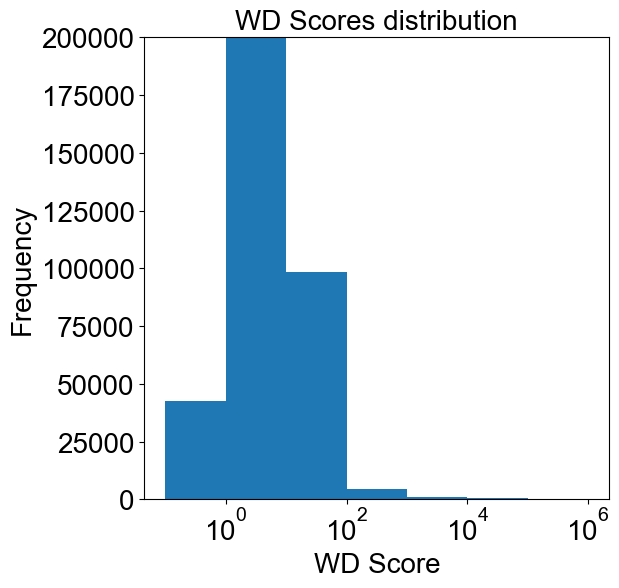

In [33]:
# WD score histogram
plt.rcParams.update({"figure.figsize":(6,6)})

fig_p, ax_p = plt.subplots()
vals = WD_mat.flatten()
counts = plt.hist(vals, bins=[0.1, 1, 10, 100, 1000, 10000, 100000, 1000000])
# ax_p.set_yscale('log')
ax_p.set_xscale('log')

plt.xlabel('WD Score')
plt.ylabel('Frequency')
plt.title('WD Scores distribution')
plt.ylim([0, 200000])

plt.show()

#### plot P(match | WD threshold) vs WD threshold

In [61]:
# plot P(match | WD) vs WD threshold
def P_match(WD_thresh, interaction_df):
    thresh_df = interaction_df[interaction_df['WD Score'] > WD_thresh]
    num_thresh = thresh_df.shape[0]
    num_match_thresh = thresh_df[thresh_df['Localization Match'] == 1].shape[0]
    if num_thresh > 0: return num_match_thresh / num_thresh
    else: return -1



In [62]:


# calc loc match, match "Other" with nucleus/cytosol/flagella
# def P_match(WD_thresh, interaction_df):
#     thresh_df = interaction_df[interaction_df['WD Score'] > WD_thresh]
#     num_thresh = thresh_df.shape[0]
#     num_match_thresh = thresh_df[thresh_df['Localization Match'] == 1].shape[0]
# #     print(num_match_thresh, num_thresh)
#     if num_thresh > 0: 
# #         print(float(num_match_thresh) / float(num_thresh))
#         return float(num_match_thresh) / float(num_thresh)
#     else: return -1.0

In [63]:
start = 0
stop = np.max(interaction_df['WD Score'])
step = 10
thresh_arr = np.arange(start, stop, step)
p_match_arr = np.zeros_like(thresh_arr, dtype='float')
num_interact = np.zeros_like(thresh_arr)

for i in tqdm(range(thresh_arr.shape[0])):
    p_match_arr[i] = P_match(thresh_arr[i], interaction_df)
    num_interact[i] = interaction_df[interaction_df['WD Score'] > thresh_arr[i]].shape[0]

100%|█████████████████████████████████████| 25442/25442 [13:21<00:00, 31.75it/s]


Text(0.5, 1.0, 'Accuracy Metric vs WD Threshold')

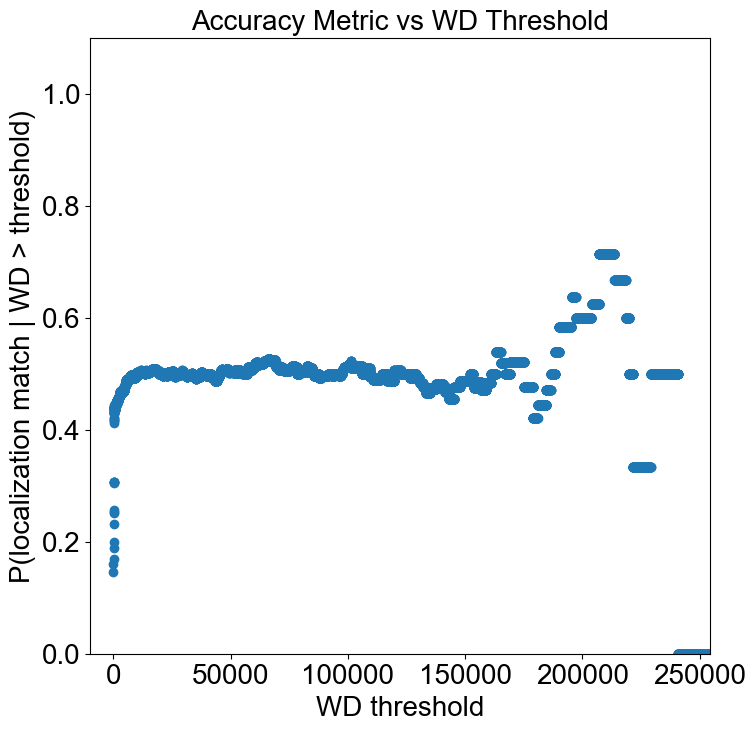

In [64]:
plt.rcParams.update({"figure.figsize":(8,8)})
plt.scatter(thresh_arr, p_match_arr)

# plt.plot([x,x], [0,1], 'k--')
plt.xlabel('WD threshold')
plt.ylabel('P(localization match | WD > threshold)')
plt.ylim([0,1.1])
plt.xlim([-10000,stop])
plt.title('Accuracy Metric vs WD Threshold')

(-10.0, 1000.0)

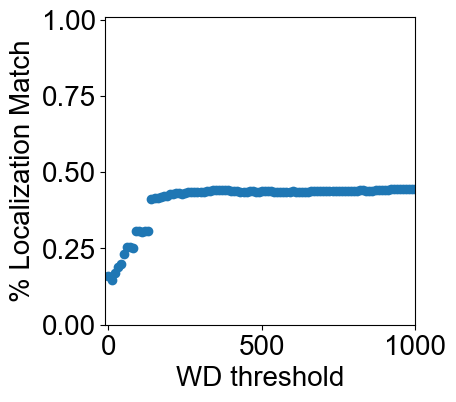

In [65]:
# zoom in on x axis
plt.rcParams.update({"figure.figsize":(4,4)})
plt.scatter(thresh_arr, p_match_arr)

# plt.plot([x,x], [0,1], 'k--')
plt.xlabel('WD threshold')
plt.ylabel('% Localization Match')
plt.ylim([0,1.01])
plt.xlim([-10,1000])

Text(0.5, 1.0, 'Interactions above WD threshold vs WD threshold')

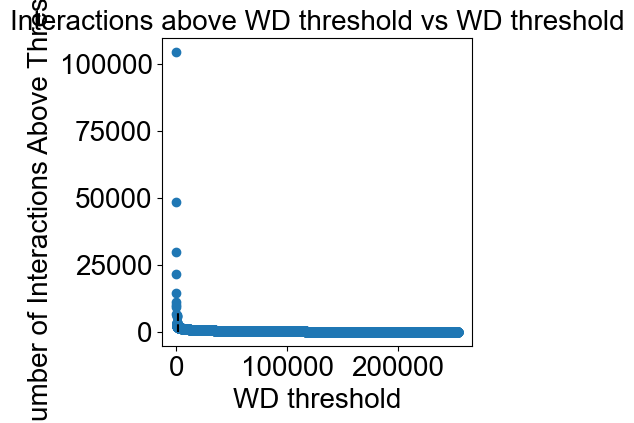

In [66]:
# interactions above different WD thresholds
plt.scatter(thresh_arr[1:], num_interact[1:])
plt.plot([1000,1000], [0,7000], 'k--')
plt.xlabel('WD threshold')
plt.ylabel('Number of Interactions Above Threshold')
plt.title('Interactions above WD threshold vs WD threshold')

Text(0.5, 1.0, 'Interactions above WD threshold vs WD threshold')

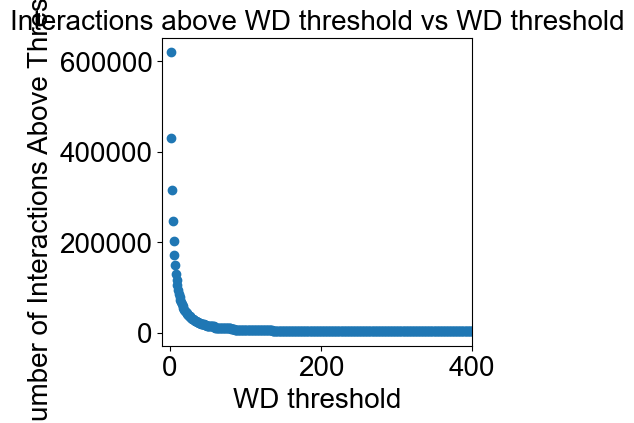

In [67]:
# interactions above different WD thresholds -- zoom in on x axis
start = 0
stop = 1000
step = 1
thresh_arr2 = np.arange(start, stop, step)
p_match_arr2 = np.zeros_like(thresh_arr2, dtype='float')
num_interact2 = np.zeros_like(thresh_arr2)

for i in range(thresh_arr2.shape[0]):
    p_match_arr2[i] = P_match(thresh_arr2[i], interaction_df)
    num_interact2[i] = interaction_df[interaction_df['WD Score'] > thresh_arr2[i]].shape[0]
plt.scatter(thresh_arr2[1:], num_interact2[1:])

plt.xlabel('WD threshold')
plt.ylabel('Number of Interactions Above Threshold')
plt.xlim([-10,400])
plt.title('Interactions above WD threshold vs WD threshold')

Text(0.5, 1.0, 'Interactions above WD threshold vs WD threshold')

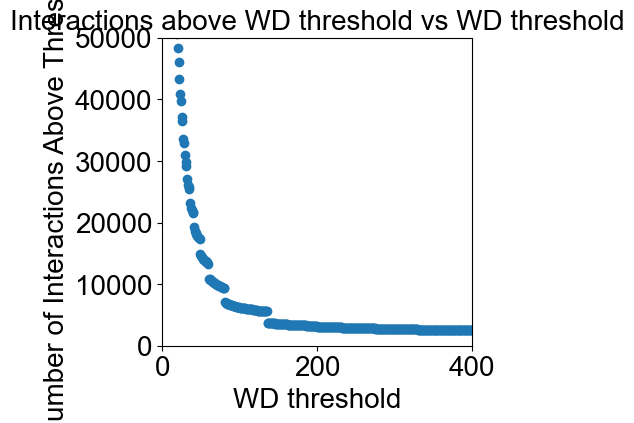

In [68]:
# zoom in y axis
plt.scatter(thresh_arr2[1:], num_interact2[1:])

plt.xlim([0,400])
plt.ylim([0,50000])

# plt.plot([300,300], [0,10000], 'k--')

plt.xlabel('WD threshold')
plt.ylabel('Number of Interactions Above Threshold')
plt.title('Interactions above WD threshold vs WD threshold')

#### Z score thresholding

In [69]:
# plot P(match | Z) vs Z score threshold
def P_match_z(z_thresh, interaction_df):
    thresh_df = interaction_df[interaction_df['Z Score'] > z_thresh]
    num_thresh = thresh_df.shape[0]
    num_match_thresh = thresh_df[thresh_df['Localization Match'] == 1].shape[0]
    if num_thresh > 0: return num_match_thresh / num_thresh
    else: return -1

start = 0
stop = np.max(interaction_df['Z Score'])
step = 0.1
thresh_arr = np.arange(start, stop, step)
p_match_arr = np.zeros_like(thresh_arr)
num_interact = np.zeros_like(thresh_arr)

for i in tqdm(range(thresh_arr.shape[0])):
    p_match_arr[i] = P_match(thresh_arr[i], interaction_df)
    num_interact[i] = interaction_df[interaction_df['Z Score'] > thresh_arr[i]].shape[0]

100%|█████████████████████████████████████████| 333/333 [01:03<00:00,  5.21it/s]


Text(0.5, 1.0, 'Accuracy Metric vs Z Score Threshold')

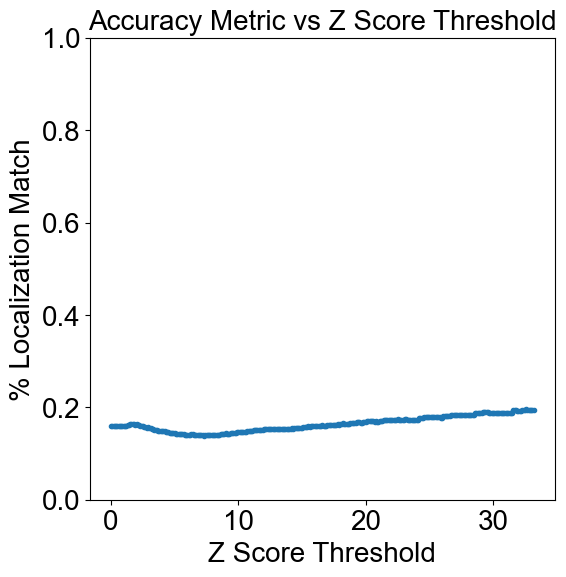

In [70]:
# plot
plt.rcParams.update({"figure.figsize":(6,6)})
plt.plot(thresh_arr, p_match_arr, '.')

plt.xlabel('Z Score Threshold')
plt.ylabel('% Localization Match')

plt.ylim([0,1])
plt.title('Accuracy Metric vs Z Score Threshold')

Text(0.5, 1.0, 'Accuracy Metric vs Z Score Threshold')

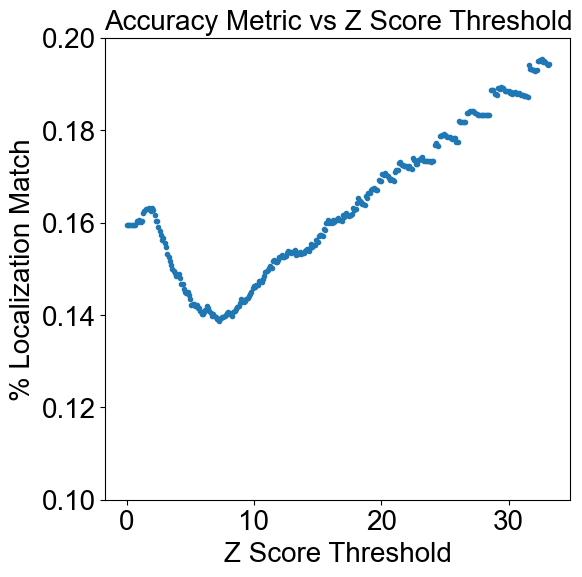

In [71]:
# plot
plt.rcParams.update({"figure.figsize":(6,6)})
plt.plot(thresh_arr, p_match_arr, '.')

plt.xlabel('Z Score Threshold')
plt.ylabel('% Localization Match')

plt.ylim([0.1,0.2])
plt.title('Accuracy Metric vs Z Score Threshold')

#### p=1 vs p=2 for Z score thresholding

In [72]:
# zoom in on x axis
plt.rcParams.update({"figure.figsize":(4,4)})

start = 0
stop = 40
step = 0.2
thresh_arr = np.arange(start, stop, step)

p1_df = interaction_df[interaction_df['p Value']==1]
p2_df = interaction_df[interaction_df['p Value']==2]

p1_p_match_arr = np.zeros_like(thresh_arr, dtype='float')
p1_num_interact = np.zeros_like(thresh_arr)

for i in range(thresh_arr.shape[0]):
    p1_p_match_arr[i] = P_match_z(thresh_arr[i], p1_df)
    p1_num_interact[i] = p1_df[p1_df['Z Score'] > thresh_arr[i]].shape[0]
    
    
p2_p_match_arr = np.zeros_like(thresh_arr, dtype='float')
p2_num_interact = np.zeros_like(thresh_arr)

for i in range(thresh_arr.shape[0]):
    p2_p_match_arr[i] = P_match_z(thresh_arr[i], p2_df)
    p2_num_interact[i] = p2_df[p2_df['Z Score'] > thresh_arr[i]].shape[0]


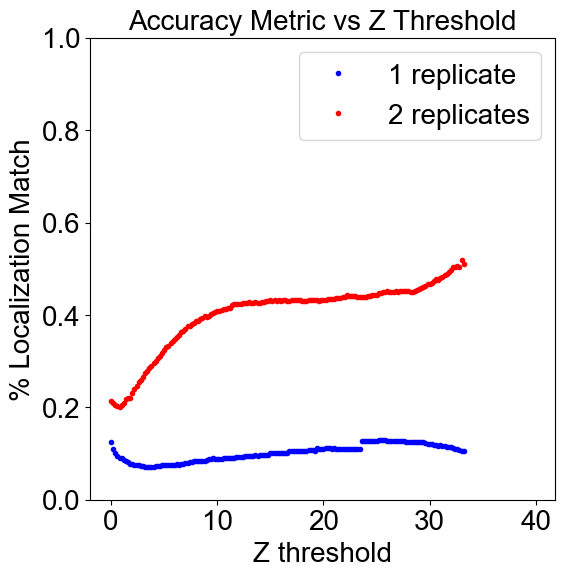

In [73]:
plt.rcParams.update({"figure.figsize":(6,6)})
plt.plot(thresh_arr, p1_p_match_arr, 'b.') # blue = 1 replicate
plt.plot(thresh_arr, p2_p_match_arr, 'r.') # red = 2 replicates

# plt.plot([x,x], [0,1], 'k--')

plt.ylim([0,1])
plt.xlabel('Z threshold')
plt.ylabel('% Localization Match')
plt.title('Accuracy Metric vs Z Threshold')
plt.legend(['1 replicate', '2 replicates'])

#### Changing loc match accuracy metric

In [74]:
start = 0
stop = np.max(interaction_df['WD Score'])
step = 100
thresh_arr = np.arange(start, stop, step)
p_match_arr = np.zeros_like(thresh_arr, dtype='float')
num_interact = np.zeros_like(thresh_arr)

noOther_df = interaction_df[interaction_df['Prey PB-Chlamy Predicted Localization'] != 'Other']

for i in tqdm(range(thresh_arr.shape[0])):
    p_match_arr[i] = P_match(thresh_arr[i], noOther_df)
    num_interact[i] = noOther_df[noOther_df['WD Score'] > thresh_arr[i]].shape[0]

100%|██████████████████████████████████████| 2545/2545 [00:25<00:00, 100.42it/s]


Text(0.5, 1.0, 'Accuracy Metric vs WD Threshold')

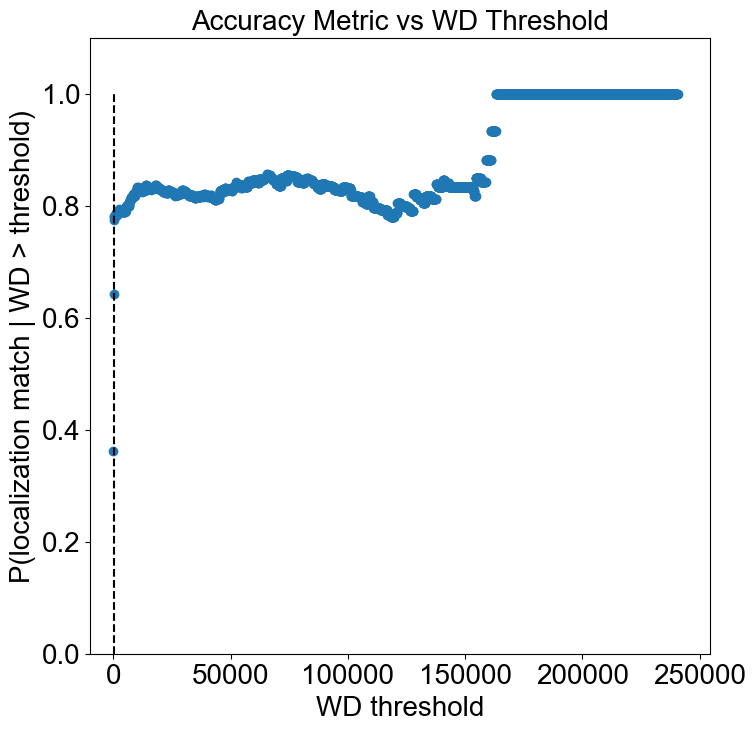

In [75]:
plt.rcParams.update({"figure.figsize":(8,8)})
plt.scatter(thresh_arr, p_match_arr)
plt.plot([35,35], [0,1], 'k--')
# plt.plot([x,x], [0,1], 'k--')
plt.xlabel('WD threshold')
plt.ylabel('P(localization match | WD > threshold)')
plt.ylim([0,1.1])
plt.xlim([-10000,stop])
plt.title('Accuracy Metric vs WD Threshold')

In [76]:
start = 0
stop = 1000
step = 1
thresh_arr = np.arange(start, stop, step)
p_match_arr = np.zeros_like(thresh_arr, dtype='float')
num_interact = np.zeros_like(thresh_arr)

for i in tqdm(range(thresh_arr.shape[0])):
    p_match_arr[i] = P_match(thresh_arr[i], noOther_df)
    num_interact[i] = noOther_df[noOther_df['WD Score'] > thresh_arr[i]].shape[0]

100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.34it/s]


(-10.0, 1000.0)

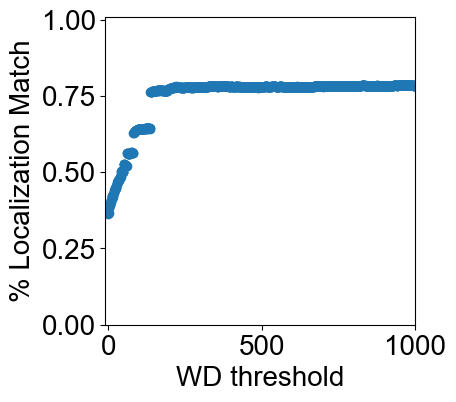

In [77]:
# zoom in on x axis
plt.rcParams.update({"figure.figsize":(4,4)})
plt.scatter(thresh_arr, p_match_arr)

# plt.plot([x,x], [0,1], 'k--')
plt.xlabel('WD threshold')
plt.ylabel('% Localization Match')
plt.ylim([0,1.01])
plt.xlim([-10,1000])

In [78]:
# 1 vs 2 replicates
plt.rcParams.update({"figure.figsize":(4,4)})

start = 0
stop = np.max(interaction_df['WD Score'])
step = 100
thresh_arr = np.arange(start, stop, step)

p1_p_match_arr = np.zeros_like(thresh_arr, dtype='float')
p1_num_interact = np.zeros_like(thresh_arr)

noOther_p1_df = noOther_df[noOther_df['p Value'] == 1]
noOther_p2_df = noOther_df[noOther_df['p Value'] == 2]

for i in tqdm(range(thresh_arr.shape[0])):
    p1_p_match_arr[i] = P_match(thresh_arr[i], noOther_p1_df)
    p1_num_interact[i] = p1_df[p1_df['WD Score'] > thresh_arr[i]].shape[0]
    
    
p2_p_match_arr = np.zeros_like(thresh_arr, dtype='float')
p2_num_interact = np.zeros_like(thresh_arr)

for i in tqdm(range(thresh_arr.shape[0])):
    p2_p_match_arr[i] = P_match(thresh_arr[i], noOther_p2_df)
    p2_num_interact[i] = p2_df[p2_df['WD Score'] > thresh_arr[i]].shape[0]


100%|██████████████████████████████████████| 2545/2545 [00:04<00:00, 524.09it/s]


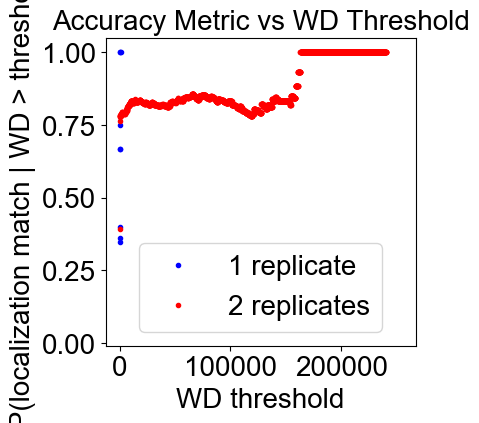

In [79]:
plt.rcParams.update({"figure.figsize":(4,4)})
plt.plot(thresh_arr, p1_p_match_arr, 'b.') # blue = 1 replicate
plt.plot(thresh_arr, p2_p_match_arr, 'r.') # red = 2 replicates

# plt.plot([x,x], [0,1], 'k--')

plt.ylim([-0.01,1.05])
# plt.xlim([0,5000])
plt.xlabel('WD threshold')
plt.ylabel('P(localization match | WD > threshold)')
plt.title('Accuracy Metric vs WD Threshold')
plt.legend(['1 replicate', '2 replicates'])

In [80]:
# 1 vs 2 replicates
plt.rcParams.update({"figure.figsize":(4,4)})

start = 0
stop = 1000
step = 1
thresh_arr = np.arange(start, stop, step)

p1_p_match_arr = np.zeros_like(thresh_arr, dtype='float')
p1_num_interact = np.zeros_like(thresh_arr)

noOther_p1_df = noOther_df[noOther_df['p Value'] == 1]
noOther_p2_df = noOther_df[noOther_df['p Value'] == 2]

for i in tqdm(range(thresh_arr.shape[0])):
    p1_p_match_arr[i] = P_match(thresh_arr[i], noOther_p1_df)
    p1_num_interact[i] = p1_df[p1_df['WD Score'] > thresh_arr[i]].shape[0]
    
    
p2_p_match_arr = np.zeros_like(thresh_arr, dtype='float')
p2_num_interact = np.zeros_like(thresh_arr)

for i in tqdm(range(thresh_arr.shape[0])):
    p2_p_match_arr[i] = P_match(thresh_arr[i], noOther_p2_df)
    p2_num_interact[i] = p2_df[p2_df['WD Score'] > thresh_arr[i]].shape[0]


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 189.37it/s]


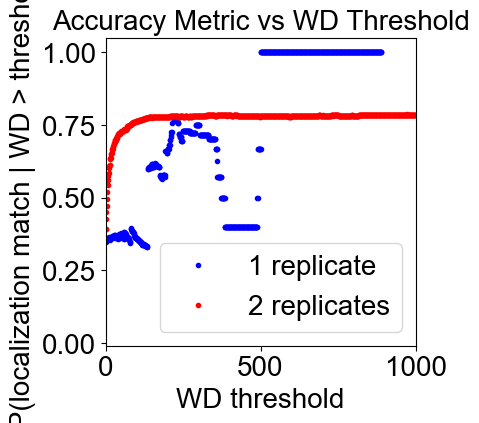

In [81]:
plt.rcParams.update({"figure.figsize":(4,4)})
plt.plot(thresh_arr, p1_p_match_arr, 'b.') # blue = 1 replicate
plt.plot(thresh_arr, p2_p_match_arr, 'r.') # red = 2 replicates

# plt.plot([x,x], [0,1], 'k--')

plt.ylim([-0.01,1.05])
plt.xlim([0,1000])
plt.xlabel('WD threshold')
plt.ylabel('P(localization match | WD > threshold)')
plt.title('Accuracy Metric vs WD Threshold')
plt.legend(['1 replicate', '2 replicates'])

#### create flag matrix

In [82]:
# load flagging matrix (1 if flagged, 0 if not)

flag_sheet = pd.read_excel(flag_mat_name, 
                           sheet_name = 0,
                           index_col = 0,
                           skiprows = 0) # load from sheet 1, start at 1st row
# note: first column is old row IDs (before removal of decoy preys)
# row indexes are current row IDs

In [83]:
flag_sheet.head(10)

,Identified Proteins,Accession Number,Alternate ID,Molecular Weight,Protein Grouping Ambiguity,Prey CreID,Prey Gene Symbol,Prey Experimental Localization,Prey PB-Chlamy Predicted Localization,Prey PredAlgo Predicted Localization,...,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108
Bait Gene Symbol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ATPVE1,AGG2,LHL4,Not Found,COV1,Not Found,Not Found,Not Found,RBD3,Not Found
Bait Experimental Localization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,secretory pathway/contractile vacuole,secretory pathway/Golgi; secretory pathway/pla...,chloroplast/homogeneous/not pyrenoid depleted;...,shapes in cytoplasm/uncategorized shapes in cy...,shapes in cytoplasm/uncategorized shapes in cy...,cytosol/cytosol (strong signal),chloroplast/homogeneous/pyrenoid depleted,shapes in cytoplasm/uncategorized shapes in cy...,chloroplast/chloroplast punctate dots,Not Found
Bait PB-Chlamy Predicted Localization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Secretory,Other,Chloroplast,Secretory,Other,Secretory,Chloroplast,Other,Chloroplast,Not Found
Replicate 1 Sheet Number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50,70,34,57,57,67,50,72,45,34
Replicate 2 Sheet Number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49,77,74,57,38,53,10,10,10,11
Replicate 1 Plate ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LW_1969_08_FE7,LW_1582_0701_67_11E11,LW_1937_04_FCB7,LW_1708_1216_64_11G12,LW_1708_1216_93_11E10,LW_1562_0603_81_12D11,LW_1969_41_3A2,LW_1893_59_6H1,LW_1312_0811_18_13A4,LW_1937_18_FD2
Replicate 2 Plate ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LW_1869_0426_07_FE7,LW_1703_1202_70_11E11,LW_1683_1027_08_FCB7,LW_1708_1216_79_11G12,LW_1708_1207_03_11E10,LW_1687_1111_96_12D11,LW_1312_0813_65_3A2,LW_1312_0813_59_6H1,LW_1312_0813_49_13A4,LW_1582_0608_40_FD2
Bait PredAlgo Predicted Localization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Other,Other,Chloroplast,Secretory,Mitochondrial,Secretory,Chloroplast,Chloroplast,Chloroplast,Not Found
Bait Defline,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Vacuolar ATP synthase subunit E,Aggregation 2,High intensity light-inducible Lhc-like gene,(1 of 1) K13249 - translocon-associated protei...,COV1-like protein,Not Found,Not Found,(1 of 546) 2.7.11.1 - Non-specific serine/thre...,Putative rubredoxin-like protein,Not Found
Bait Greencut,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found


In [84]:
# create flag matrix
start_col = 14
start_row = 13

flag_mat = flag_sheet.iloc[start_row:,start_col:].to_numpy()

In [85]:
# make flagged values negative
flag_WD_sheet = (WD_sheet - (2 * WD_sheet * flag_mat)).astype('float')
flag_WD_mat = flag_WD_sheet.to_numpy()

In [86]:
# format for export
out_flag_sheet = full_sheet.copy()
out_flag_sheet.iloc[start_row:, start_col:] = flag_WD_mat
out_flag_sheet.head(10)

,Identified Proteins,Accession Number,Alternate ID,Molecular Weight,Protein Grouping Ambiguity,Prey CreID,Prey Gene Symbol,Prey Experimental Localization,Prey PB-Chlamy Predicted Localization,Prey PredAlgo Predicted Localization,...,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108
Bait Gene Symbol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ATPVE1,AGG2,LHL4,Not Found,COV1,Not Found,Not Found,Not Found,RBD3,Not Found
Bait Experimental Localization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,secretory pathway/contractile vacuole,secretory pathway/Golgi; secretory pathway/pla...,chloroplast/homogeneous/not pyrenoid depleted;...,shapes in cytoplasm/uncategorized shapes in cy...,shapes in cytoplasm/uncategorized shapes in cy...,cytosol/cytosol (strong signal),chloroplast/homogeneous/pyrenoid depleted,shapes in cytoplasm/uncategorized shapes in cy...,chloroplast/chloroplast punctate dots,Not Found
Bait PB-Chlamy Predicted Localization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Secretory,Other,Chloroplast,Secretory,Other,Secretory,Chloroplast,Other,Chloroplast,Not Found
Replicate 1 Sheet Number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50,70,34,57,57,67,50,72,45,34
Replicate 2 Sheet Number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49,77,74,57,38,53,10,10,10,11
Replicate 1 Plate ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LW_1969_08_FE7,LW_1582_0701_67_11E11,LW_1937_04_FCB7,LW_1708_1216_64_11G12,LW_1708_1216_93_11E10,LW_1562_0603_81_12D11,LW_1969_41_3A2,LW_1893_59_6H1,LW_1312_0811_18_13A4,LW_1937_18_FD2
Replicate 2 Plate ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LW_1869_0426_07_FE7,LW_1703_1202_70_11E11,LW_1683_1027_08_FCB7,LW_1708_1216_79_11G12,LW_1708_1207_03_11E10,LW_1687_1111_96_12D11,LW_1312_0813_65_3A2,LW_1312_0813_59_6H1,LW_1312_0813_49_13A4,LW_1582_0608_40_FD2
Bait PredAlgo Predicted Localization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Other,Other,Chloroplast,Secretory,Mitochondrial,Secretory,Chloroplast,Chloroplast,Chloroplast,Not Found
Bait Defline,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Vacuolar ATP synthase subunit E,Aggregation 2,High intensity light-inducible Lhc-like gene,(1 of 1) K13249 - translocon-associated protei...,COV1-like protein,Not Found,Not Found,(1 of 546) 2.7.11.1 - Non-specific serine/thre...,Putative rubredoxin-like protein,Not Found
Bait Greencut,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found


In [51]:
# export flagged WD scores
with pd.ExcelWriter('negFlag_' + import_file, mode='w') as writer:  
    out_flag_sheet.to_excel(writer, sheet_name='neg flag WD')

In [52]:
# # plot flagged WD sheet as heatmap top left
# sns.heatmap(flag_WD_sheet, 
#             cmap="bwr_r", vmin=-WD_threshold*5, vmax=WD_threshold*5,
#             cbar_kws={'label':'WD Score'})
# plt.xlabel('Bait')
# plt.ylabel('Prey')

In [87]:
# import spectral counts sheet

spec_sheet = pd.read_excel(spec_sheet_name, 
                           sheet_name = 0,
                           index_col = 0,
                           skiprows = 0) # load from sheet 1, start at 1st row

# note: first column is old row IDs (before removal of decoy preys)
# row indexes are current row IDs

In [88]:
# process spectral counts sheet
# set NaN (blank cells) to 0
process_spec_sheet = spec_sheet.replace(np.nan, 0)
print('Replaced NaNs with 0')


sheet_2_reps = process_spec_sheet.copy()

# sort columns by CreID and remove header rows
sorted_sheet = sheet_2_reps.drop(index=[0, 'Sheet Number', 'Gel Number', 'Bait Plate ID', 'Bait Gene Symbol',
                                        'Bait Experimental Localization', 'Bait PB-Chlamy Predicted Localization',
                                        'Bait PredAlgo Predicted Localization', 'Bait Defline', 'Bait Greencut', 
                                        'Bait Arabidopsis Conservation', 'Bait Arabidopsis Conservation Defline']).iloc[:,14:].sort_values(by = 'Bait CreID', axis = 1)

# create dataframes for each replicate (assumes data sorted by creID so replicates are adjacent, in pairs)
start_col = 0 # column index of first bait in dataframe
stop = sorted_sheet.shape[1]
rep1_indices = np.arange(start_col, stop, 2) # column indices to keep for rep 1 (skip every other column)
rep1_df = sorted_sheet.iloc[1:, rep1_indices] # removes CreID row

rep2_indices = np.arange(start_col+1, stop, 2) # shift start point over by 1 column to get other set of replicates
rep2_df = sorted_sheet.iloc[1:, rep2_indices]

# create matrices for each replicate
rep1 = rep1_df.to_numpy().astype('float')
rep2 = rep2_df.to_numpy().astype('float')

# sort by CreID, split into rep 1 and rep 2

Replaced NaNs with 0


In [89]:
rep1

array([[ 95.,  60.,  17., ...,  96.,  45.,  19.],
       [ 27., 148.,  28., ...,  29.,  34.,  72.],
       [ 33.,  64.,  18., ...,  71.,  29.,  18.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [90]:
rep2

array([[52., 10., 67., ..., 37., 29., 31.],
       [22., 67., 23., ..., 15., 23., 41.],
       [17., 13., 36., ..., 20., 14., 20.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [91]:
# create list of each interaction with: (takes a few mins)
# bait CreID, prey CreID, 
# bait and prey localization (binary columns for chloroplast, mitochondria, secretory)
# WD score, raw z score, WD z score, p value

WD_col = np.zeros(num_interactions, dtype='float')
p_col = np.zeros(num_interactions)
z_col = np.zeros(num_interactions, dtype='float')
WDz_col = np.zeros(num_interactions, dtype='float')
rep1_col = np.zeros(num_interactions, dtype='float')
rep2_col = np.zeros(num_interactions, dtype='float')
LMR_col = np.zeros(num_interactions, dtype='float')

# for loc match % col
WD_low = 35
WD_high = 140
Z_thresh = 8

index = 0 # interaction index
for i in tqdm(range(bait_creID.shape[0])): # loop over baits
    bait_loc_mat = exp_loc_dict[bait_loc.iloc[i]]
    bait = bait_creID.iloc[i]
    
    for j in range(prey_creID.shape[0]): # loop over preys
        prey = prey_creID.iloc[j]
        
        rep1_col[index] = rep1[j,i]
        rep2_col[index] = rep2[j,i]
        
        # scores
        WD_col[index] = flag_WD_mat[j,i]
        p_col[index] = p_mat[j,i]
        WDz_col[index] = WD_zscore[j,i]
        z_col[index] = z_mat[j,i]
        

        # loc match %
        WD_score = np.abs(flag_WD_mat[j,i])
        Z_score = z_col[index]
        p_val = p_col[index]
        flag_check = flag_WD_mat[j,i] < 0
        
        if WD_score != 0:

            if p_val == 1:
                if Z_score > Z_thresh:
                    if WD_score <= WD_low:
                    # Z>8 p=1 WD<35 37%
                        LMR_col[index] = 0.37

                    elif WD_score > WD_high:
                    # Z>8 p=1 WD>140 84%
                        LMR_col[index] = 0.84

                    else:
                    # Z>8 p=1 35<WD<140 40% 
                        LMR_col[index] = 0.4

                else:
                    if WD_score <= WD_low:
                    # Z<8 p=1 WD<35 50%
                        LMR_col[index] = 0.5

                    elif WD_score > WD_high:
                    # Z<8 p=1 WD>140 80%
                        LMR_col[index] = 0.8

                    else:
                    # Z<8 p=1 35<WD<140 71%
                        LMR_col[index] = 0.71

            elif p_val == 2:
                if Z_score > Z_thresh:
                    if WD_score <= WD_low:
                    # Z>8 p=2 WD<35 89%
                        LMR_col[index] = 0.89

                    elif WD_score > WD_high:
                    # Z>8 p=2 WD>140 91%
                        LMR_col[index] = 0.91

                    else:
                    # Z>8 p=2 35<WD<140 80% 
                        LMR_col[index] = 0.8

                else:
                    if WD_score <= WD_low:
                    # Z<8 p=2 WD<35 55%
                        LMR_col[index] = 0.55

                    elif WD_score > WD_high:
                    # Z<8 p=2 WD>140 93%
                        LMR_col[index] = 0.93

                    else:
                    # Z<8 p=2 35<WD<140 73%
                        LMR_col[index] = 0.73

            if flag_check:
                LMR_col[index] = -LMR_col[index]
        
        else:
            LMR_col[index] = 0

        index += 1 # increment interaction index

100%|███████████████████████████████████████| 1109/1109 [02:10<00:00,  8.48it/s]


In [92]:
# create dataframe of interactions
flag_interaction_df = pd.DataFrame(data=baitID_col, columns=['Bait CreID'])
flag_interaction_df['Bait Gene Symbol'] = baitSymbol_col
flag_interaction_df['Bait Info'] = baitInfo_col
flag_interaction_df['Prey CreID'] = preyID_col
flag_interaction_df['Prey Gene Symbol'] = preySymbol_col
flag_interaction_df['Prey Info'] = preyInfo_col
flag_interaction_df['WD Score'] = WD_col
flag_interaction_df['Z Score'] = z_col
flag_interaction_df['WD Z Score'] = WDz_col
flag_interaction_df['Rep 1 Spectral Counts'] = rep1_col
flag_interaction_df['Rep 2 Spectral Counts'] = rep2_col


flag_interaction_df['Bait Experimental Localization'] = bait_loc_col
flag_interaction_df['Bait PB-Chlamy Predicted Localization'] = bait_pred_loc_col
flag_interaction_df['Bait PredAlgo Predicted Localization'] = bait_predalgo_loc_col

flag_interaction_df['Prey PB-Chlamy Predicted Localization'] = prey_loc_col
flag_interaction_df['Prey Experimental Localization'] = prey_exp_loc_col
flag_interaction_df['Prey PredAlgo Predicted Localization'] = prey_predalgo_loc_col

flag_interaction_df['Bait GreenCut'] = bait_greencut_col
flag_interaction_df['Bait Conservation'] = bait_conserve_col
flag_interaction_df['Bait Conservation Defline'] = bait_conserve_defline_col

flag_interaction_df['Prey GreenCut'] = prey_greencut_col
flag_interaction_df['Prey Conservation'] = prey_conserve_col
flag_interaction_df['Prey Conservation Defline'] = prey_conserve_defline_col

flag_interaction_df['Localization Match'] = loc_match_col
flag_interaction_df['p Value'] = p_col

flag_interaction_df['LM%'] = LMR_col

In [93]:
# export to csv to import to Cytoscape
# flag_interaction_df.to_csv('flagged_interact_list.csv', sep='\t')

In [94]:
# WD threshold flag_interaction_df and export interaction lists
WD_thresh = np.percentile(WD_mat[WD_mat>0], 100-3.78, axis=None)
WD_thresh_df = flag_interaction_df[np.abs(flag_interaction_df['WD Score'])>WD_thresh]
WD_thresh_df

,Bait CreID,Bait Gene Symbol,Bait Info,Prey CreID,Prey Gene Symbol,Prey Info,WD Score,Z Score,WD Z Score,Rep 1 Spectral Counts,...,Prey Experimental Localization,Prey PredAlgo Predicted Localization,Bait GreenCut,Bait Conservation,Bait Conservation Defline,Prey GreenCut,Prey Conservation,Prey Conservation Defline,Localization Match,p Value
403,Cre01.g002150,Not Found,Not Found,Cre01.g029200,ESP1,"Separase, cell cycle protease",144.019749,8.868040,31.065512,1.0,...,Not Found,Secretory,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,2.0
1208,Cre01.g002150,Not Found,Not Found,Cre07.g337800,MRPS17,Mitochondrial ribosomal protein S17,55.777930,5.494229,10.042194,2.0,...,Not Found,Chloroplast,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,2.0
1414,Cre01.g002150,Not Found,Not Found,Cre07.g322450,Not Found,putative N-methyltransferase,50.315230,6.665170,19.958355,1.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,2.0
1560,Cre01.g002150,Not Found,Not Found,Cre12.g518107,Not Found,(1 of 1) PF04182 - B-block binding subunit of ...,64.429131,9.370700,22.543673,1.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT1G17450,B-block binding subunit of TFIIIC,0.0,2.0
1572,Cre01.g002150,Not Found,Not Found,Cre07.g336500,OPR114,OctotricoPeptide Repeat Protein,78.289053,9.792223,23.290096,2.0,...,Not Found,Mitochondrial,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14859017,Venus-3xFLAG,Not Found,Not Found,Cre17.g707850,Not Found,(1 of 14) PF07460 - NUMOD3 motif (2 copies) (N...,59.572883,19.200694,19.200694,1.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,1.0
14859079,Venus-3xFLAG,Not Found,Not Found,Cre11.g482750,Not Found,(1 of 3) PTHR12363 - TRANSPORTIN 3 AND IMPORTI...,59.572883,19.200694,19.200694,1.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,1.0
14859174,Venus-3xFLAG,Not Found,Not Found,Cre09.g396050,Not Found,(1 of 4) KOG4249 - Uncharacterized conserved p...,48.000565,16.620770,16.620770,1.0,...,Not Found,Mitochondrial,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,1.0
14859177,Venus-3xFLAG,Not Found,Not Found,Cre16.g673841,Not Found,(1 of 1) PF10218 - Uncharacterized conserved p...,135.858156,33.286634,33.286634,1.0,...,Not Found,Secretory,Not Found,Not Found,Not Found,Not Found,AT3G59390,(1 of 1) KOG3136 - Uncharacterized conserved p...,0.0,1.0


In [95]:
# export list to csv for Cytoscape
# best_with_z.to_csv('flagged_interact_list_WD30p2_WD200_z5p2.csv', sep='\t')

### No Bait Other 

In [96]:
keep_inds = []

for i in tqdm(range(flag_interaction_df.shape[0])):
    bloc = flag_interaction_df['Bait Experimental Localization'].iloc[i]
    bloc_code = exp_loc_dict[bloc]
    
    if np.sum(bloc_code[0:3]) > 0: # keep if bait is in chloroplast, mitochondria, or secretory
        keep_inds.append(i)

interaction_noBaitOther = flag_interaction_df.iloc[keep_inds,:].copy()

100%|████████████████████████████| 14862818/14862818 [04:20<00:00, 57124.98it/s]


In [97]:
interaction_noBaitOther[interaction_noBaitOther['Prey PB-Chlamy Predicted Localization'] != 'Other'].iloc[:30,9:]

,Rep 1 Spectral Counts,Rep 2 Spectral Counts,Bait Experimental Localization,Bait PB-Chlamy Predicted Localization,Bait PredAlgo Predicted Localization,Prey PB-Chlamy Predicted Localization,Prey Experimental Localization,Prey PredAlgo Predicted Localization,Bait GreenCut,Bait Conservation,Bait Conservation Defline,Prey GreenCut,Prey Conservation,Prey Conservation Defline,Localization Match,p Value
1,27.0,22.0,chloroplast/homogeneous/pyrenoid depleted; cyt...,Other,Chloroplast,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,2.0
2,33.0,17.0,chloroplast/homogeneous/pyrenoid depleted; cyt...,Other,Chloroplast,Secretory,Not Found,Secretory,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,2.0
4,21.0,15.0,chloroplast/homogeneous/pyrenoid depleted; cyt...,Other,Chloroplast,Chloroplast,Not Found,Chloroplast,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,1.0,2.0
5,6.0,2.0,chloroplast/homogeneous/pyrenoid depleted; cyt...,Other,Chloroplast,Secretory,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT4G10320,"tRNA synthetase class I (I, L, M and V) family...",0.0,2.0
6,0.0,0.0,chloroplast/homogeneous/pyrenoid depleted; cyt...,Other,Chloroplast,Chloroplast,Not Found,Chloroplast,Not Found,Not Found,Not Found,Not Found,AT5G35360,acetyl Co-enzyme a carboxylase biotin carboxyl...,1.0,0.0
8,21.0,9.0,chloroplast/homogeneous/pyrenoid depleted; cyt...,Other,Chloroplast,Chloroplast,chloroplast/not homogeneous/pyrenoid depleted,Chloroplast,Not Found,Not Found,Not Found,Not Found,AT1G42970,glyceraldehyde-3-phosphate dehydrogenase B sub...,1.0,2.0
9,25.0,4.0,chloroplast/homogeneous/pyrenoid depleted; cyt...,Other,Chloroplast,Secretory,Not Found,Secretory,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,2.0
10,20.0,8.0,chloroplast/homogeneous/pyrenoid depleted; cyt...,Other,Chloroplast,Chloroplast,chloroplast/not homogeneous/pyrenoid depleted/...,Chloroplast,Not Found,Not Found,Not Found,Not Found,AT4G38970,fructose-bisphosphate aldolase 2,1.0,2.0
11,0.0,0.0,chloroplast/homogeneous/pyrenoid depleted; cyt...,Other,Chloroplast,Chloroplast,chloroplast/chloroplast punctate dots,Chloroplast,Not Found,Not Found,Not Found,Not Found,AT1G74470,Pyridine nucleotide-disulphide oxidoreductase ...,1.0,0.0
12,12.0,5.0,chloroplast/homogeneous/pyrenoid depleted; cyt...,Other,Chloroplast,Chloroplast,Not Found,Other,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,1.0,2.0


### No Bait or Prey Other

In [98]:
noBaitPreyOther = interaction_noBaitOther[interaction_noBaitOther['Prey PB-Chlamy Predicted Localization'] != 'Other']


In [99]:
# no thresholding
noBaitPreyOther_nonzero = noBaitPreyOther[noBaitPreyOther['WD Score'] != 0]
noBaitPreyOther_nonzero_match = noBaitPreyOther_nonzero[noBaitPreyOther_nonzero['Localization Match'] == 1]
print('Nonzero:', noBaitPreyOther_nonzero_match.shape[0], '/', noBaitPreyOther_nonzero.shape[0], '=', 
      noBaitPreyOther_nonzero_match.shape[0] / noBaitPreyOther_nonzero.shape[0])

Nonzero: 105721 / 203940 = 0.5183926645091693


#### no Other WD score thresholding

In [100]:
# plot P(match | WD) vs WD threshold
def P_match(WD_thresh, interaction_df):
    thresh_df = interaction_df[interaction_df['WD Score'] > WD_thresh]
    num_thresh = thresh_df.shape[0]
    num_match_thresh = thresh_df[thresh_df['Localization Match'] == 1].shape[0]
    if num_thresh > 0: return num_match_thresh / num_thresh
    else: return -1



In [101]:
start = 0
stop = np.max(interaction_df['WD Score'])
step = 100
thresh_arr = np.arange(start, stop, step)
p_match_arr = np.zeros_like(thresh_arr, dtype='float')
num_interact = np.zeros_like(thresh_arr)


for i in tqdm(range(thresh_arr.shape[0])):
    p_match_arr[i] = P_match(thresh_arr[i], noBaitPreyOther)
    num_interact[i] = noBaitPreyOther[noBaitPreyOther['WD Score'] > thresh_arr[i]].shape[0]

100%|██████████████████████████████████████| 2545/2545 [00:17<00:00, 143.24it/s]


Text(0.5, 1.0, 'Accuracy Metric vs WD Threshold')

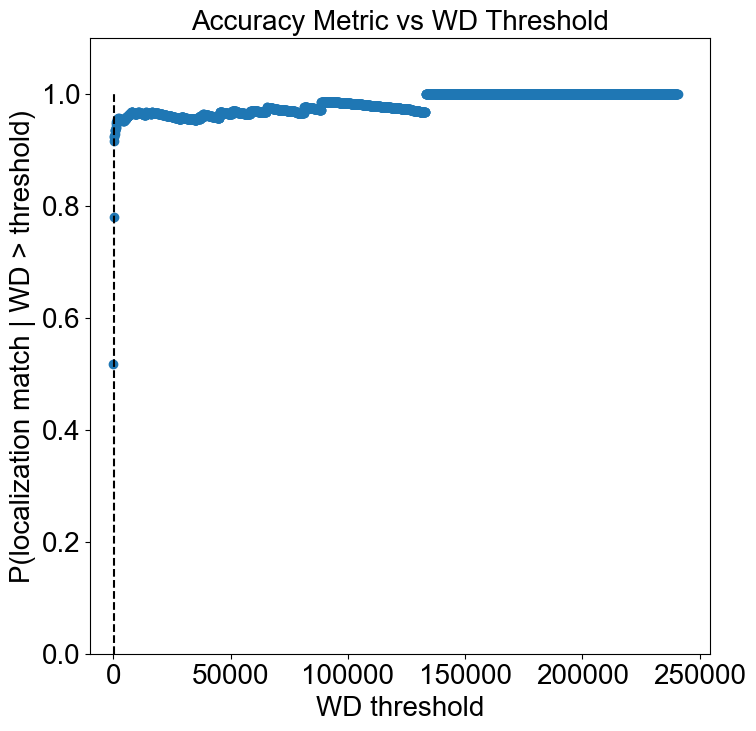

In [103]:
plt.rcParams.update({"figure.figsize":(8,8)})
plt.scatter(thresh_arr, p_match_arr)
plt.plot([35,35], [0,1], 'k--')
# plt.plot([x,x], [0,1], 'k--')
plt.xlabel('WD threshold')
plt.ylabel('P(localization match | WD > threshold)')
plt.ylim([0,1.1])
plt.xlim([-10000,stop])
plt.title('Accuracy Metric vs WD Threshold')

In [ ]:
np.savetxt('WDscore_S1C_extra.csv', p_match_arr, delimiter=',')

In [104]:
start = 0
stop = 1000
step = 1
thresh_arr = np.arange(start, stop, step)
p_match_arr = np.zeros_like(thresh_arr, dtype='float')
num_interact = np.zeros_like(thresh_arr)

for i in tqdm(range(thresh_arr.shape[0])):
    p_match_arr[i] = P_match(thresh_arr[i], noBaitPreyOther)

100%|██████████████████████████████████████| 1000/1000 [00:08<00:00, 122.55it/s]


In [105]:
np.savetxt('WDscore_S1C_extra_Xzoom.csv', p_match_arr, delimiter=',')

(-10.0, 1000.0)

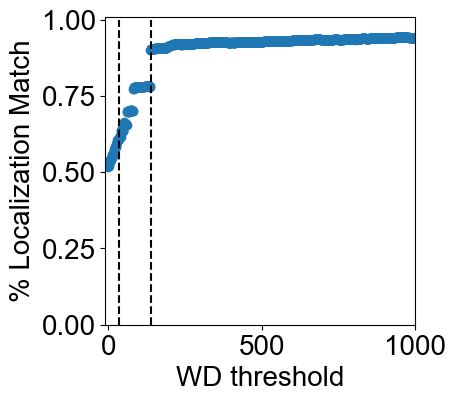

In [106]:
# zoom in on x axis
plt.rcParams.update({"figure.figsize":(4,4)})
plt.scatter(thresh_arr, p_match_arr)
plt.plot([35,35], [0,1], 'k--')
plt.plot([140,140], [0,1], 'k--')
# plt.plot([300,300], [0,1], 'k--')
# plt.plot([x,x], [0,1], 'k--')
plt.xlabel('WD threshold')
plt.ylabel('% Localization Match')
plt.ylim([0,1.01])
plt.xlim([-10,1000])

In [107]:
# 1 vs 2 replicates
plt.rcParams.update({"figure.figsize":(4,4)})

start = 0
stop = np.max(interaction_df['WD Score'])
step = 100
thresh_arr = np.arange(start, stop, step)

p1_p_match_arr = np.zeros_like(thresh_arr, dtype='float')


noOther_p1_df = noBaitPreyOther[noBaitPreyOther['p Value'] == 1]
noOther_p2_df = noBaitPreyOther[noBaitPreyOther['p Value'] == 2]

for i in tqdm(range(thresh_arr.shape[0])):
    p1_p_match_arr[i] = P_match(thresh_arr[i], noOther_p1_df)

    
    
p2_p_match_arr = np.zeros_like(thresh_arr, dtype='float')
p2_num_interact = np.zeros_like(thresh_arr)

for i in tqdm(range(thresh_arr.shape[0])):
    p2_p_match_arr[i] = P_match(thresh_arr[i], noOther_p2_df)



100%|█████████████████████████████████████| 2545/2545 [00:01<00:00, 1414.23it/s]


In [108]:
thresh_arr

array([0.000e+00, 1.000e+02, 2.000e+02, ..., 2.542e+05, 2.543e+05,
       2.544e+05])

In [ ]:
np.savetxt('p1_WDscore_S1C.csv', p1_p_match_arr, delimiter=',')

In [100]:
np.savetxt('p2_WDscore_S1C.csv', p2_p_match_arr, delimiter=',')

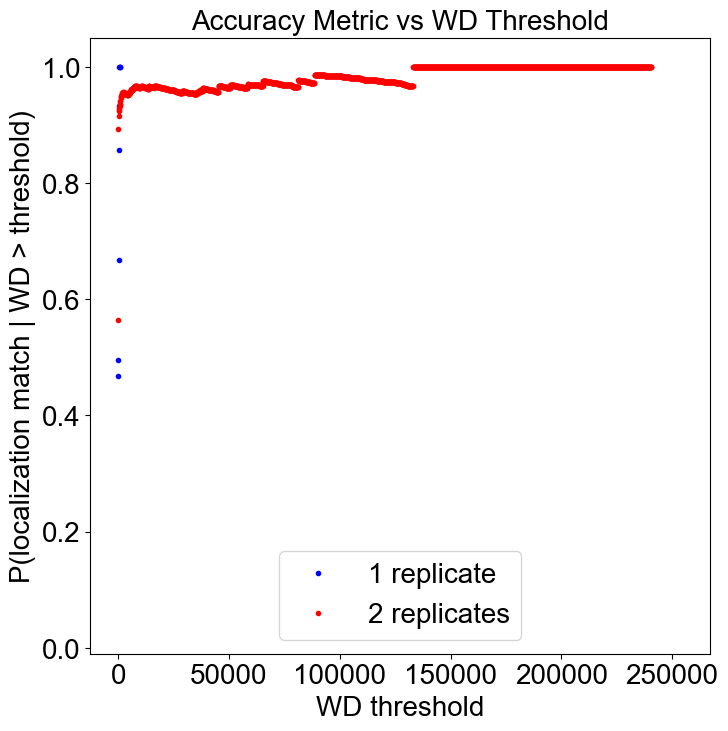

In [109]:
plt.rcParams.update({"figure.figsize":(8,8)})
plt.plot(thresh_arr, p1_p_match_arr, 'b.') # blue = 1 replicate
plt.plot(thresh_arr, p2_p_match_arr, 'r.') # red = 2 replicates

# plt.plot([x,x], [0,1], 'k--')

plt.ylim([-0.01,1.05])
# plt.xlim([0,5000])
plt.xlabel('WD threshold')
plt.ylabel('P(localization match | WD > threshold)')
plt.title('Accuracy Metric vs WD Threshold')
plt.legend(['1 replicate', '2 replicates'])

In [110]:
# 1 vs 2 replicates
plt.rcParams.update({"figure.figsize":(4,4)})

start = 0
stop = 1000
step = 1
thresh_arr = np.arange(start, stop, step)

p1_p_match_arr = np.zeros_like(thresh_arr, dtype='float')
p1_num_interact = np.zeros_like(thresh_arr)

noOther_p1_df = noBaitPreyOther[noBaitPreyOther['p Value'] == 1]
noOther_p2_df = noBaitPreyOther[noBaitPreyOther['p Value'] == 2]

for i in tqdm(range(thresh_arr.shape[0])):
    p1_p_match_arr[i] = P_match(thresh_arr[i], noOther_p1_df)

    
    
p2_p_match_arr = np.zeros_like(thresh_arr, dtype='float')
p2_num_interact = np.zeros_like(thresh_arr)

for i in tqdm(range(thresh_arr.shape[0])):
    p2_p_match_arr[i] = P_match(thresh_arr[i], noOther_p2_df)



100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 575.50it/s]


In [111]:
thresh_arr

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [112]:
np.savetxt('p1_WDscore_S1C_inset.csv', p1_p_match_arr, delimiter=',')

In [114]:
np.savetxt('p2_WDscore_S1C_inset.csv', p2_p_match_arr, delimiter=',')

Text(0.5, 1.0, 'Accuracy Metric vs WD Threshold')

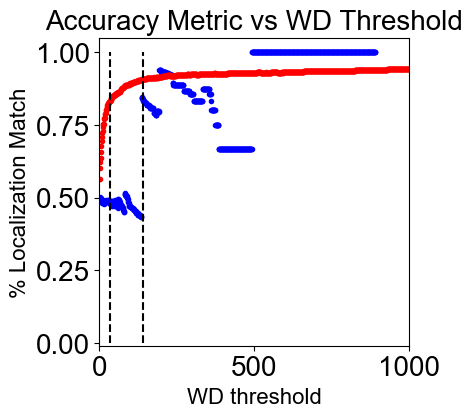

In [113]:
plt.rcParams.update({"figure.figsize":(4,4)})
plt.plot(thresh_arr, p1_p_match_arr, 'b.') # blue = 1 replicate
plt.plot(thresh_arr, p2_p_match_arr, 'r.') # red = 2 replicates
plt.plot([35,35], [0,1], 'k--')
plt.plot([140,140], [0,1], 'k--')

# plt.plot([x,x], [0,1], 'k--')

plt.ylim([-0.01,1.05])
plt.xlim([0,1000])
plt.xlabel('WD threshold', fontsize=16)
plt.ylabel('% Localization Match', fontsize=16)
plt.title('Accuracy Metric vs WD Threshold')
# plt.legend(['1 replicate', '2 replicates'])

#### no Other Z score thresholding

In [114]:
# plot P(match | Z) vs Z score threshold
def P_match_z_noOther(z_thresh, interaction_df):
    thresh_df = interaction_df[interaction_df['Z Score'] > z_thresh]
    num_thresh = thresh_df.shape[0]
    num_match_thresh = thresh_df[thresh_df['Localization Match'] == 1].shape[0]
    
    if num_thresh > 0: return num_match_thresh / num_thresh
    else: return -1

start = 0
stop = np.max(interaction_df['Z Score'])
step = 0.1
thresh_arr = np.arange(start, stop, step)
p_match_arr = np.zeros_like(thresh_arr)
num_interact = np.zeros_like(thresh_arr)

for i in tqdm(range(thresh_arr.shape[0])):
    p_match_arr[i] = P_match_z_noOther(thresh_arr[i], noBaitPreyOther)


100%|█████████████████████████████████████████| 333/333 [00:05<00:00, 60.85it/s]


In [91]:
np.savetxt('Zscore_S1D_extra.csv', p_match_arr, delimiter=',')

Text(0.5, 1.0, 'Accuracy Metric vs Z Score Threshold')

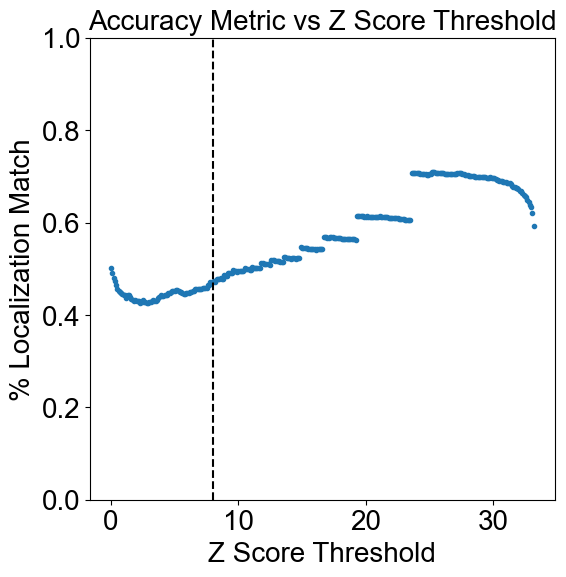

In [115]:
# plot
plt.rcParams.update({"figure.figsize":(6,6)})
plt.plot(thresh_arr, p_match_arr, '.')
plt.plot([8,8], [0,1], 'k--')
plt.xlabel('Z Score Threshold')
plt.ylabel('% Localization Match')

plt.ylim([0,1])
plt.title('Accuracy Metric vs Z Score Threshold')

Text(0.5, 1.0, 'Accuracy Metric vs Z Score Threshold')

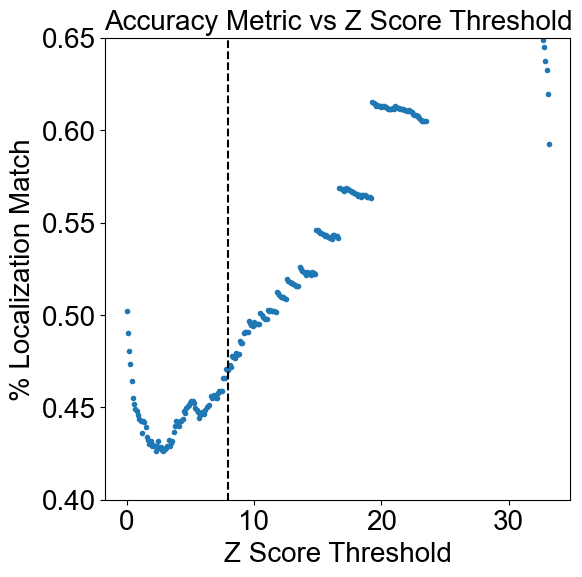

In [116]:
# plot
plt.rcParams.update({"figure.figsize":(6,6)})
plt.plot(thresh_arr, p_match_arr, '.')

plt.plot([8,8], [0,1], 'k--')
plt.xlabel('Z Score Threshold')
plt.ylabel('% Localization Match')

plt.ylim([0.4,0.65])
plt.title('Accuracy Metric vs Z Score Threshold')

In [117]:
# zoom in on x axis
plt.rcParams.update({"figure.figsize":(4,4)})

start = 0
stop = 40
step = 0.2
thresh_arr = np.arange(start, stop, step)

noOther_p1_df = noBaitPreyOther[noBaitPreyOther['p Value'] == 1]
noOther_p2_df = noBaitPreyOther[noBaitPreyOther['p Value'] == 2]

p1_p_match_arr = np.zeros_like(thresh_arr, dtype='float')
p1_num_interact = np.zeros_like(thresh_arr)

for i in range(thresh_arr.shape[0]):
    p1_p_match_arr[i] = P_match_z_noOther(thresh_arr[i], noOther_p1_df)
    p1_num_interact[i] = noOther_p1_df[noOther_p1_df['Z Score'] > thresh_arr[i]].shape[0]
    
    
p2_p_match_arr = np.zeros_like(thresh_arr, dtype='float')
p2_num_interact = np.zeros_like(thresh_arr)

for i in range(thresh_arr.shape[0]):
    p2_p_match_arr[i] = P_match_z_noOther(thresh_arr[i], noOther_p2_df)
    p2_num_interact[i] = noOther_p2_df[noOther_p2_df['Z Score'] > thresh_arr[i]].shape[0]


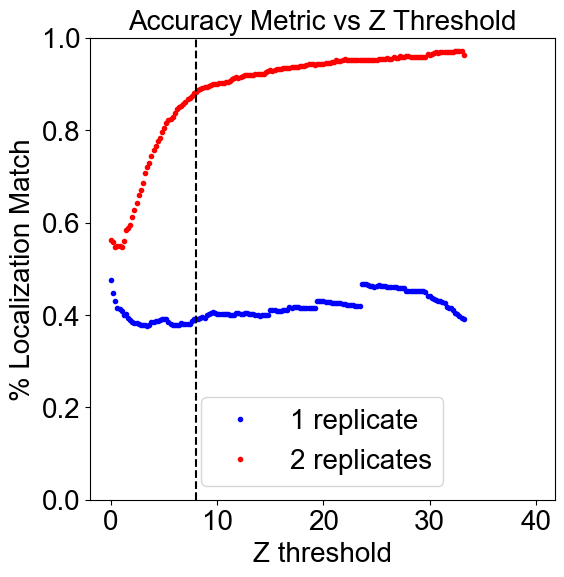

In [118]:
plt.rcParams.update({"figure.figsize":(6,6)})
plt.plot(thresh_arr, p1_p_match_arr, 'b.') # blue = 1 replicate
plt.plot(thresh_arr, p2_p_match_arr, 'r.') # red = 2 replicates

plt.plot([8,8], [0,1], 'k--')

# plt.plot([x,x], [0,1], 'k--')

plt.ylim([0,1])
plt.xlabel('Z threshold')
plt.ylabel('% Localization Match')
plt.title('Accuracy Metric vs Z Threshold')
plt.legend(['1 replicate', '2 replicates'])

In [84]:
np.savetxt('1rep_Zscore_S1D.csv', p1_p_match_arr, delimiter=',')

In [85]:
np.savetxt('2rep_Zscore_S1D.csv', p2_p_match_arr, delimiter=',')

In [119]:
# WD thresholding
WD35 = noBaitPreyOther[np.abs(noBaitPreyOther['WD Score'])>35]
WD35_match = WD35[WD35['Localization Match'] == 1]


print(WD35_match.shape[0] / WD35.shape[0])


WD140 = noBaitPreyOther[np.abs(noBaitPreyOther['WD Score'])>140]
WD140_match = WD140[WD140['Localization Match'] == 1]
print(WD140_match.shape[0] / WD140.shape[0])

0.6103555832813474
0.9040767386091128


### Venn Diagram Plotter

1: 1686 / 4501 0.3745834259053544
2: 245 / 275 0.8909090909090909
3: 1502 / 3756 0.39989350372736954
4: 208 / 259 0.803088803088803
5: 915 / 1288 0.7104037267080745
6: 759 / 1044 0.7270114942528736
7: 71 / 85 0.8352941176470589
8: 968 / 1076 0.8996282527881041
9: 8 / 10 0.8
10: 461 / 497 0.9275653923541247
11: 66116 / 131505 0.5027641534542413
12: 32782 / 59644 0.5496277915632755


Text(2.5, -0.7, 'Nonzero Interactions')

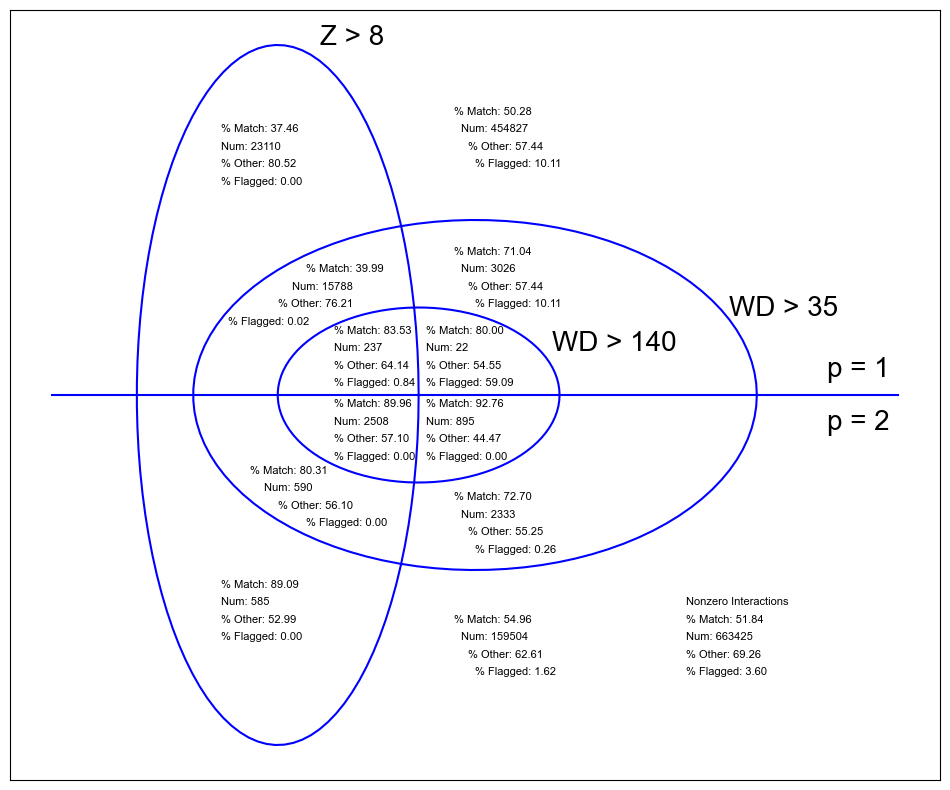

In [120]:
# set thresholds
high_WD_venn = 140
low_WD_venn = 35
Z_venn = 8


# plot ellipses
from math import pi

plt.rcParams.update({"figure.figsize":(12,10)}) # plot size

# outer horizontal ellipse
u=1.     #x-position of the center
v=0.5    #y-position of the center
a=2.     #radius on the x-axis
b=1.    #radius on the y-axis

t = np.linspace(0, 2*pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), 'b-');


# vertical ellipse
u=1.     #x-position of the center
v=0.5    #y-position of the center
a=1     #radius on the x-axis
b=2    #radius on the y-axis

plt.plot( u+a*np.cos(t)-1.4 , v+b*np.sin(t), 'b-');



# inner horizontal ellipse
u=1.     #x-position of the center
v=0.5    #y-position of the center
a=1     #radius on the x-axis
b=1/2   #radius on the y-axis

plt.plot( u+a*np.cos(t)-0.4 , v+b*np.sin(t), 'b-');

# line
plt.plot([-2,4],[0.5,0.5],'b-');

plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)


# store loc match percents
sector_match_list = []

# add labels
plt.annotate('WD > ' + str(high_WD_venn), (1.55, 0.75)) # high WD:
plt.annotate('WD > ' + str(low_WD_venn), (2.8, 0.95)) # low WD:
plt.annotate('Z > ' + str(Z_venn), (-0.1, 2.5)) # Z score

plt.annotate('p = 1', (3.5, 0.6)) # p=1
plt.annotate('p = 2', (3.5, 0.3)) # p=2



# add % loc match values
# fill in Venn diagram with Loc Match % no Other (including flagged) NO OTHER
noBaitPreyOther_p1 = noBaitPreyOther[noBaitPreyOther['p Value'] == 1]
noBaitPreyOther_p2 = noBaitPreyOther[noBaitPreyOther['p Value'] == 2]

# 1: Z>5 p=1 WD<low_WD_venn
noBaitPreyOther_zThresh_p1 = noBaitPreyOther_p1[noBaitPreyOther_p1['Z Score'] > Z_venn]
noBaitPreyOther_zThresh_p1_WDltlow_WD_venn = noBaitPreyOther_zThresh_p1[np.abs(noBaitPreyOther_zThresh_p1['WD Score']) < low_WD_venn]
noBaitPreyOther_zThresh_p1_WDltlow_WD_venn_match = noBaitPreyOther_zThresh_p1_WDltlow_WD_venn[noBaitPreyOther_zThresh_p1_WDltlow_WD_venn['Localization Match']==1]

print('1:', noBaitPreyOther_zThresh_p1_WDltlow_WD_venn_match.shape[0], '/', noBaitPreyOther_zThresh_p1_WDltlow_WD_venn.shape[0], noBaitPreyOther_zThresh_p1_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p1_WDltlow_WD_venn.shape[0])


# 2: Z>5 p=2 WD<low_WD_venn
noBaitPreyOther_zThresh_p2 = noBaitPreyOther_p2[noBaitPreyOther_p2['Z Score'] > Z_venn]
noBaitPreyOther_zThresh_p2_WDltlow_WD_venn = noBaitPreyOther_zThresh_p2[np.abs(noBaitPreyOther_zThresh_p2['WD Score']) < low_WD_venn]
noBaitPreyOther_zThresh_p2_WDltlow_WD_venn_match = noBaitPreyOther_zThresh_p2_WDltlow_WD_venn[noBaitPreyOther_zThresh_p2_WDltlow_WD_venn['Localization Match']==1]

print('2:', noBaitPreyOther_zThresh_p2_WDltlow_WD_venn_match.shape[0], '/', noBaitPreyOther_zThresh_p2_WDltlow_WD_venn.shape[0],noBaitPreyOther_zThresh_p2_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p2_WDltlow_WD_venn.shape[0])

# 3: Z>5 p=1 low_WD_venn<WD<high_WD_venn
noBaitPreyOther_zThresh_p1_WDlow_WD_venn = noBaitPreyOther_zThresh_p1[np.abs(noBaitPreyOther_zThresh_p1['WD Score']) > low_WD_venn]
noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn = noBaitPreyOther_zThresh_p1_WDlow_WD_venn[np.abs(noBaitPreyOther_zThresh_p1_WDlow_WD_venn['WD Score']) < high_WD_venn]
noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn_match = noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn[noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn['Localization Match']==1]

print('3:', noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0], noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0])

# 4: Z>5 p=2 low_WD_venn<WD<high_WD_venn
noBaitPreyOther_zThresh_p2_WDlow_WD_venn = noBaitPreyOther_zThresh_p2[np.abs(noBaitPreyOther_zThresh_p2['WD Score']) > low_WD_venn]
noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn = noBaitPreyOther_zThresh_p2_WDlow_WD_venn[np.abs(noBaitPreyOther_zThresh_p2_WDlow_WD_venn['WD Score']) < high_WD_venn]
noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn_match = noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn[noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn['Localization Match']==1]

print('4:', noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0], noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0])

# 5: Z<5 p=1 low_WD_venn<WD<high_WD_venn
noBaitPreyOther_ZltThresh_p1 = noBaitPreyOther_p1[noBaitPreyOther_p1['Z Score'] < Z_venn]
noBaitPreyOther_ZltThresh_p1_WDlow_WD_venn = noBaitPreyOther_ZltThresh_p1[np.abs(noBaitPreyOther_ZltThresh_p1['WD Score']) > low_WD_venn]
noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn = noBaitPreyOther_ZltThresh_p1_WDlow_WD_venn[np.abs(noBaitPreyOther_ZltThresh_p1_WDlow_WD_venn['WD Score']) < high_WD_venn]
noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn_match = noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn[noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn['Localization Match']==1]

print('5:', noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0], noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0])

# 6: Z<5 p=2 low_WD_venn<WD<high_WD_venn
noBaitPreyOther_ZltThresh_p2 = noBaitPreyOther_p2[noBaitPreyOther_p2['Z Score'] < Z_venn]
noBaitPreyOther_ZltThresh_p2_WDlow_WD_venn = noBaitPreyOther_ZltThresh_p2[np.abs(noBaitPreyOther_ZltThresh_p2['WD Score']) > low_WD_venn]
noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn = noBaitPreyOther_ZltThresh_p2_WDlow_WD_venn[np.abs(noBaitPreyOther_ZltThresh_p2_WDlow_WD_venn['WD Score']) < high_WD_venn]
noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn_match = noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn[noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn['Localization Match']==1]

print('6:', noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0], noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0])

# 7: Z>5 p=1 WD>high_WD_venn
noBaitPreyOther_zThresh_p1_WDhigh_WD_venn = noBaitPreyOther_zThresh_p1[np.abs(noBaitPreyOther_zThresh_p1['WD Score']) > high_WD_venn]
noBaitPreyOther_zThresh_p1_WDhigh_WD_venn_match = noBaitPreyOther_zThresh_p1_WDhigh_WD_venn[noBaitPreyOther_zThresh_p1_WDhigh_WD_venn['Localization Match']==1]

print('7:', noBaitPreyOther_zThresh_p1_WDhigh_WD_venn_match.shape[0], '/', noBaitPreyOther_zThresh_p1_WDhigh_WD_venn.shape[0], noBaitPreyOther_zThresh_p1_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p1_WDhigh_WD_venn.shape[0])

# 8: Z>5 p=2 WD>high_WD_venn
noBaitPreyOther_zThresh_p2_WDhigh_WD_venn = noBaitPreyOther_zThresh_p2[np.abs(noBaitPreyOther_zThresh_p2['WD Score']) > high_WD_venn]
noBaitPreyOther_zThresh_p2_WDhigh_WD_venn_match = noBaitPreyOther_zThresh_p2_WDhigh_WD_venn[noBaitPreyOther_zThresh_p2_WDhigh_WD_venn['Localization Match']==1]

print('8:', noBaitPreyOther_zThresh_p2_WDhigh_WD_venn_match.shape[0], '/', noBaitPreyOther_zThresh_p2_WDhigh_WD_venn.shape[0],noBaitPreyOther_zThresh_p2_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p2_WDhigh_WD_venn.shape[0])

# 9: Z<5 p=1 WD>high_WD_venn
noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn = noBaitPreyOther_ZltThresh_p1[np.abs(noBaitPreyOther_ZltThresh_p1['WD Score']) > high_WD_venn]
noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn_match = noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn[noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn['Localization Match']==1]

print('9:', noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn_match.shape[0], '/', noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn.shape[0], noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn.shape[0])

# 10: Z<5 p=2 WD>high_WD_venn
noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn = noBaitPreyOther_ZltThresh_p2[np.abs(noBaitPreyOther_ZltThresh_p2['WD Score']) > high_WD_venn]
noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn_match = noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn[noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn['Localization Match']==1]

print('10:', noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn_match.shape[0], '/',noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn.shape[0], noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn.shape[0])

# 11: Z<5 p=1 WD<low_WD_venn
noBaitPreyOther_ZltThresh_p1 = noBaitPreyOther_p1[noBaitPreyOther_p1['Z Score']<Z_venn]
noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn = noBaitPreyOther_ZltThresh_p1[np.abs(noBaitPreyOther_ZltThresh_p1['WD Score']) < low_WD_venn]
noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn_match = noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn[noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn['Localization Match']==1]

print('11:', noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn_match.shape[0], '/', noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn.shape[0], noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn.shape[0])

# 12: Z<5 p=2 WD<low_WD_venn
noBaitPreyOther_p2_ZltThresh = noBaitPreyOther_p2[noBaitPreyOther_p2['Z Score']<Z_venn]
noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn = noBaitPreyOther_ZltThresh_p2[np.abs(noBaitPreyOther_ZltThresh_p2['WD Score']) < low_WD_venn]
noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn_match = noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn[noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn['Localization Match']==1]

print('12:', noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn_match.shape[0], '/', noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn.shape[0], noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn.shape[0])



# fill in Venn diagram with Loc Match % WITH Other (including flagged)
# and num interactions in dataset (including Other)
# and % interactions with bait or prey Other (2nd line)
# and % interactions flagged for contamination (3rd line)
p1 = flag_interaction_df[flag_interaction_df['p Value'] == 1]
p2 = flag_interaction_df[flag_interaction_df['p Value'] == 2]

# 1: Z>Z_venn p=1 WD<low_WD_venn
zThresh_p1 = p1[p1['Z Score'] > Z_venn]
zThresh_p1_WDltlow_WD_venn = zThresh_p1[np.abs(zThresh_p1['WD Score']) < low_WD_venn]
zThresh_p1_WDltlow_WD_venn_match = zThresh_p1_WDltlow_WD_venn[zThresh_p1_WDltlow_WD_venn['Localization Match']==1]

no1_Other = zThresh_p1_WDltlow_WD_venn.shape[0] - noBaitPreyOther_zThresh_p1_WDltlow_WD_venn.shape[0]
no1_contam = zThresh_p1_WDltlow_WD_venn[zThresh_p1_WDltlow_WD_venn['WD Score'] < 0].shape[0]

# print('1:', zThresh_p1_WDltlow_WD_venn_match.shape[0], '/', zThresh_p1_WDltlow_WD_venn.shape[0], zThresh_p1_WDltlow_WD_venn_match.shape[0] / zThresh_p1_WDltlow_WD_venn.shape[0])
# print('1:', no1_Other/zThresh_p1_WDltlow_WD_venn.shape[0]*100)
# print('1:', no1_contam/zThresh_p1_WDltlow_WD_venn.shape[0]*100)


loc_perc = noBaitPreyOther_zThresh_p1_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p1_WDltlow_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)
plt.annotate('% Match: {0:.2f}'.format(loc_perc), (-0.8,2), fontsize=8)

plt.annotate('Num: {0:d}'.format(zThresh_p1_WDltlow_WD_venn.shape[0]), (-0.8,1.9), fontsize=8)

plt.annotate('% Other: {0:.2f}'.format(no1_Other/zThresh_p1_WDltlow_WD_venn.shape[0]*100), (-0.8,1.8), fontsize=8)
plt.annotate('% Flagged: {0:.2f}'.format(no1_contam/zThresh_p1_WDltlow_WD_venn.shape[0]*100), (-0.8,1.7), fontsize=8)



# 2: Z>Z_venn p=2 WD<low_WD_venn
zThresh_p2 = p2[p2['Z Score'] > Z_venn]
zThresh_p2_WDltlow_WD_venn = zThresh_p2[np.abs(zThresh_p2['WD Score']) < low_WD_venn]
zThresh_p2_WDltlow_WD_venn_match = zThresh_p2_WDltlow_WD_venn[zThresh_p2_WDltlow_WD_venn['Localization Match']==1]
no2_Other = zThresh_p2_WDltlow_WD_venn.shape[0] - noBaitPreyOther_zThresh_p2_WDltlow_WD_venn.shape[0]
no2_contam = zThresh_p2_WDltlow_WD_venn[zThresh_p2_WDltlow_WD_venn['WD Score'] < 0].shape[0]

# print('2:', zThresh_p2_WDltlow_WD_venn_match.shape[0], '/', zThresh_p2_WDltlow_WD_venn.shape[0],zThresh_p2_WDltlow_WD_venn_match.shape[0] / zThresh_p2_WDltlow_WD_venn.shape[0])
# print('2:', no2_Other/zThresh_p2_WDltlow_WD_venn.shape[0]*100)
# print('2:', no2_contam/zThresh_p2_WDltlow_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_zThresh_p2_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p2_WDltlow_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)
plt.annotate('% Match: {0:.2f}'.format(loc_perc), (-0.8,-0.6), fontsize=8)

plt.annotate('Num: {0:d}'.format(zThresh_p2_WDltlow_WD_venn.shape[0]), (-0.8,-0.7), fontsize=8)

plt.annotate('% Other: {0:.2f}'.format(no2_Other/zThresh_p2_WDltlow_WD_venn.shape[0]*100), (-0.8,-0.8), fontsize=8)
plt.annotate('% Flagged: {0:.2f}'.format(no2_contam/zThresh_p2_WDltlow_WD_venn.shape[0]*100), (-0.8,-0.9), fontsize=8)



# 3: Z>Z_venn p=1 low_WD_venn<WD<high_WD_venn
zThresh_p1_WDlow_WD_venn = zThresh_p1[np.abs(zThresh_p1['WD Score']) > low_WD_venn]
zThresh_p1_low_WD_vennWDhigh_WD_venn = zThresh_p1_WDlow_WD_venn[np.abs(zThresh_p1_WDlow_WD_venn['WD Score']) < high_WD_venn]
zThresh_p1_low_WD_vennWDhigh_WD_venn_match = zThresh_p1_low_WD_vennWDhigh_WD_venn[zThresh_p1_low_WD_vennWDhigh_WD_venn['Localization Match']==1]
no3_Other = zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0] - noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]
no3_contam = zThresh_p1_low_WD_vennWDhigh_WD_venn[zThresh_p1_low_WD_vennWDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('3:', zThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0], zThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0] / zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0])
# print('3:', no3_Other/zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]*100)
# print('3:', no3_contam/zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)
plt.annotate('% Match: {0:.2f}'.format(loc_perc), (-0.2,1.2), fontsize=8)

plt.annotate('Num: {0:d}'.format(zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]), (-0.3,1.1), fontsize=8)

plt.annotate('% Other: {0:.2f}'.format(no3_Other/zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]*100), (-0.4,1.0), fontsize=8)
plt.annotate('% Flagged: {0:.2f}'.format(no3_contam/zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]*100), (-0.75,0.9), fontsize=8)


# 4: Z>Z_venn p=2 low_WD_venn<WD<high_WD_venn
zThresh_p2_WDlow_WD_venn = zThresh_p2[np.abs(zThresh_p2['WD Score']) > low_WD_venn]
zThresh_p2_low_WD_vennWDhigh_WD_venn = zThresh_p2_WDlow_WD_venn[np.abs(zThresh_p2_WDlow_WD_venn['WD Score']) < high_WD_venn]
zThresh_p2_low_WD_vennWDhigh_WD_venn_match = zThresh_p2_low_WD_vennWDhigh_WD_venn[zThresh_p2_low_WD_vennWDhigh_WD_venn['Localization Match']==1]
no4_Other = zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0] - noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]
no4_contam = zThresh_p2_low_WD_vennWDhigh_WD_venn[zThresh_p2_low_WD_vennWDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('4:', zThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0], zThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0] / zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0])
# print('4:', no4_Other/zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]*100)
# print('4:', no4_contam/zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)
plt.annotate('% Match: {0:.2f}'.format(loc_perc), (-0.6,0.05), fontsize=8)

plt.annotate('Num: {0:d}'.format(zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]), (-0.5,-0.05), fontsize=8)

plt.annotate('% Other: {0:.2f}'.format(no4_Other/zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]*100), (-0.4,-0.15), fontsize=8)
plt.annotate('% Flagged: {0:.2f}'.format(no4_contam/zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]*100), (-0.2,-0.25), fontsize=8)



# 5: Z<Z_venn p=1 low_WD_venn<WD<high_WD_venn
ZltThresh_p1 = p1[p1['Z Score'] < Z_venn]
ZltThresh_p1_WDlow_WD_venn = ZltThresh_p1[np.abs(ZltThresh_p1['WD Score']) > low_WD_venn]
ZltThresh_p1_low_WD_vennWDhigh_WD_venn = ZltThresh_p1_WDlow_WD_venn[np.abs(ZltThresh_p1_WDlow_WD_venn['WD Score']) < high_WD_venn]
ZltThresh_p1_low_WD_vennWDhigh_WD_venn_match = ZltThresh_p1_low_WD_vennWDhigh_WD_venn[ZltThresh_p1_low_WD_vennWDhigh_WD_venn['Localization Match']==1]
no5_Other = ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0] - noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]
no5_contam = ZltThresh_p1_low_WD_vennWDhigh_WD_venn[ZltThresh_p1_low_WD_vennWDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('5:', ZltThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0], ZltThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0] / ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0])
# print('5:', no5_Other/ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]*100)
# print('5:', no5_contam/ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)
plt.annotate('% Match: {0:.2f}'.format(loc_perc), (0.85,1.3), fontsize=8)

plt.annotate('Num: {0:d}'.format(ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]), (0.9,1.2), fontsize=8)

plt.annotate('% Other: {0:.2f}'.format(no5_Other/ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]*100), (0.95,1.1), fontsize=8)
plt.annotate('% Flagged: {0:.2f}'.format(no5_contam/ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]*100), (1,1), fontsize=8)


# 6: Z<Z_venn p=2 low_WD_venn<WD<high_WD_venn
ZltThresh_p2 = p2[p2['Z Score'] < Z_venn]
ZltThresh_p2_WDlow_WD_venn = ZltThresh_p2[np.abs(ZltThresh_p2['WD Score']) > low_WD_venn]
ZltThresh_p2_low_WD_vennWDhigh_WD_venn = ZltThresh_p2_WDlow_WD_venn[np.abs(ZltThresh_p2_WDlow_WD_venn['WD Score']) < high_WD_venn]
ZltThresh_p2_low_WD_vennWDhigh_WD_venn_match = ZltThresh_p2_low_WD_vennWDhigh_WD_venn[ZltThresh_p2_low_WD_vennWDhigh_WD_venn['Localization Match']==1]
no6_Other = ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0] - noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]
no6_contam = ZltThresh_p2_low_WD_vennWDhigh_WD_venn[ZltThresh_p2_low_WD_vennWDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('6:', ZltThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0], ZltThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0] / ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0])
# print('6:', no6_Other/ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]*100)
# print('6:', no6_contam/ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)
plt.annotate('% Match: {0:.2f}'.format(loc_perc), (0.85,-0.1), fontsize=8)

plt.annotate('Num: {0:d}'.format(ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]), (0.9,-0.2), fontsize=8)

plt.annotate('% Other: {0:.2f}'.format(no6_Other/ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]*100), (0.95,-0.3), fontsize=8)
plt.annotate('% Flagged: {0:.2f}'.format(no6_contam/ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]*100), (1,-0.4), fontsize=8)


# 7: Z>Z_venn p=1 WD>high_WD_venn
zThresh_p1_WDhigh_WD_venn = zThresh_p1[np.abs(zThresh_p1['WD Score']) > high_WD_venn]
zThresh_p1_WDhigh_WD_venn_match = zThresh_p1_WDhigh_WD_venn[zThresh_p1_WDhigh_WD_venn['Localization Match']==1]
no7_Other = zThresh_p1_WDhigh_WD_venn.shape[0] - noBaitPreyOther_zThresh_p1_WDhigh_WD_venn.shape[0]
no7_contam = zThresh_p1_WDhigh_WD_venn[zThresh_p1_WDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('7:', zThresh_p1_WDhigh_WD_venn_match.shape[0], '/', zThresh_p1_WDhigh_WD_venn.shape[0], zThresh_p1_WDhigh_WD_venn_match.shape[0] / zThresh_p1_WDhigh_WD_venn.shape[0])
# print('7:', no7_Other/zThresh_p1_WDhigh_WD_venn.shape[0]*100)
# print('7:', no7_contam/zThresh_p1_WDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_zThresh_p1_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p1_WDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)
plt.annotate('% Match: {0:.2f}'.format(loc_perc), (0,0.85), fontsize=8)

plt.annotate('Num: {0:d}'.format(zThresh_p1_WDhigh_WD_venn.shape[0]), (0,0.75), fontsize=8)

plt.annotate('% Other: {0:.2f}'.format(no7_Other/zThresh_p1_WDhigh_WD_venn.shape[0]*100), (0,0.65), fontsize=8)
plt.annotate('% Flagged: {0:.2f}'.format(no7_contam/zThresh_p1_WDhigh_WD_venn.shape[0]*100), (0,0.55), fontsize=8)


# 8: Z>Z_venn p=2 WD>high_WD_venn
zThresh_p2_WDhigh_WD_venn = zThresh_p2[np.abs(zThresh_p2['WD Score']) > high_WD_venn]
zThresh_p2_WDhigh_WD_venn_match = zThresh_p2_WDhigh_WD_venn[zThresh_p2_WDhigh_WD_venn['Localization Match']==1]
no8_Other = zThresh_p2_WDhigh_WD_venn.shape[0] - noBaitPreyOther_zThresh_p2_WDhigh_WD_venn.shape[0]
no8_contam = zThresh_p2_WDhigh_WD_venn[zThresh_p2_WDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('8:', zThresh_p2_WDhigh_WD_venn_match.shape[0], '/', zThresh_p2_WDhigh_WD_venn.shape[0], zThresh_p2_WDhigh_WD_venn_match.shape[0] / zThresh_p2_WDhigh_WD_venn.shape[0])
# print('8:', no8_Other/zThresh_p2_WDhigh_WD_venn.shape[0]*100)
# print('8:', no8_contam/zThresh_p2_WDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_zThresh_p2_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p2_WDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)
plt.annotate('% Match: {0:.2f}'.format(loc_perc), (0,0.43), fontsize=8)

plt.annotate('Num: {0:d}'.format(zThresh_p2_WDhigh_WD_venn.shape[0]), (0,0.33), fontsize=8)

plt.annotate('% Other: {0:.2f}'.format(no8_Other/zThresh_p2_WDhigh_WD_venn.shape[0]*100), (0,0.23), fontsize=8)
plt.annotate('% Flagged: {0:.2f}'.format(no8_contam/zThresh_p2_WDhigh_WD_venn.shape[0]*100), (0,0.13), fontsize=8)


# 9: Z<Z_venn p=1 WD>high_WD_venn
ZltThresh_p1_WDhigh_WD_venn = ZltThresh_p1[np.abs(ZltThresh_p1['WD Score']) > high_WD_venn]
ZltThresh_p1_WDhigh_WD_venn_match = ZltThresh_p1_WDhigh_WD_venn[ZltThresh_p1_WDhigh_WD_venn['Localization Match']==1]
no9_Other = ZltThresh_p1_WDhigh_WD_venn.shape[0] - noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn.shape[0]
no9_contam = ZltThresh_p1_WDhigh_WD_venn[ZltThresh_p1_WDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('9:', ZltThresh_p1_WDhigh_WD_venn_match.shape[0], '/', ZltThresh_p1_WDhigh_WD_venn.shape[0], ZltThresh_p1_WDhigh_WD_venn_match.shape[0] / ZltThresh_p1_WDhigh_WD_venn.shape[0])
# print('9:', no9_Other/ZltThresh_p1_WDhigh_WD_venn.shape[0]*100)
# print('9:', no9_contam/ZltThresh_p1_WDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)
plt.annotate('% Match: {0:.2f}'.format(loc_perc), (0.65,0.85), fontsize=8)

plt.annotate('Num: {0:d}'.format(ZltThresh_p1_WDhigh_WD_venn.shape[0]), (0.65,0.75), fontsize=8)

plt.annotate('% Other: {0:.2f}'.format(no9_Other/ZltThresh_p1_WDhigh_WD_venn.shape[0]*100), (0.65,0.65), fontsize=8)
plt.annotate('% Flagged: {0:.2f}'.format(no9_contam/ZltThresh_p1_WDhigh_WD_venn.shape[0]*100), (0.65,0.55), fontsize=8)


# 10: Z<Z_venn p=2 WD>high_WD_venn
ZltThresh_p2_WDhigh_WD_venn = ZltThresh_p2[np.abs(ZltThresh_p2['WD Score']) > high_WD_venn]
ZltThresh_p2_WDhigh_WD_venn_match = ZltThresh_p2_WDhigh_WD_venn[ZltThresh_p2_WDhigh_WD_venn['Localization Match']==1]
no10_Other = ZltThresh_p2_WDhigh_WD_venn.shape[0] - noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn.shape[0]
no10_contam = ZltThresh_p2_WDhigh_WD_venn[ZltThresh_p2_WDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('10:', ZltThresh_p2_WDhigh_WD_venn_match.shape[0], '/',ZltThresh_p2_WDhigh_WD_venn.shape[0], ZltThresh_p2_WDhigh_WD_venn_match.shape[0] / ZltThresh_p2_WDhigh_WD_venn.shape[0])
# print('10:', no10_Other/ZltThresh_p2_WDhigh_WD_venn.shape[0]*100)
# print('10:', no10_contam/ZltThresh_p2_WDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)
plt.annotate('% Match: {0:.2f}'.format(loc_perc), (0.65,0.43), fontsize=8)

plt.annotate('Num: {0:d}'.format(ZltThresh_p2_WDhigh_WD_venn.shape[0]), (0.65,0.33), fontsize=8)

plt.annotate('% Other: {0:.2f}'.format(no10_Other/ZltThresh_p2_WDhigh_WD_venn.shape[0]*100), (0.65,0.23), fontsize=8)
plt.annotate('% Flagged: {0:.2f}'.format(no10_contam/ZltThresh_p2_WDhigh_WD_venn.shape[0]*100), (0.65,0.13), fontsize=8)



# 11: Z<Z_venn p=1 WD<low_WD_venn
ZltThresh_p1 = p1[p1['Z Score']<Z_venn]
ZltThresh_p1_WDltlow_WD_venn = ZltThresh_p1[np.abs(ZltThresh_p1['WD Score']) < low_WD_venn]
ZltThresh_p1_WDltlow_WD_venn_match = ZltThresh_p1_WDltlow_WD_venn[ZltThresh_p1_WDltlow_WD_venn['Localization Match']==1]
no11_Other = ZltThresh_p1_WDltlow_WD_venn.shape[0] - noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn.shape[0]
no11_contam = ZltThresh_p1_WDltlow_WD_venn[ZltThresh_p1_WDltlow_WD_venn['WD Score'] < 0].shape[0]

# print('11:', ZltThresh_p1_WDltlow_WD_venn_match.shape[0], '/', ZltThresh_p1_WDltlow_WD_venn.shape[0], ZltThresh_p1_WDltlow_WD_venn_match.shape[0] / ZltThresh_p1_WDltlow_WD_venn.shape[0])
# print('11:', no11_Other/ZltThresh_p1_WDltlow_WD_venn.shape[0]*100)
# print('11:', no11_contam/ZltThresh_p1_WDltlow_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)
plt.annotate('% Match: {0:.2f}'.format(loc_perc), (0.85,2.1), fontsize=8)

plt.annotate('Num: {0:d}'.format(ZltThresh_p1_WDltlow_WD_venn.shape[0]), (0.9,2), fontsize=8)

plt.annotate('% Other: {0:.2f}'.format(no5_Other/ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]*100), (0.95,1.9), fontsize=8)
plt.annotate('% Flagged: {0:.2f}'.format(no5_contam/ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]*100), (1,1.8), fontsize=8)


# 12: Z<Z_venn p=2 WD<low_WD_venn
p2_ZltThresh = p2[p2['Z Score']<Z_venn]
ZltThresh_p2_WDltlow_WD_venn = ZltThresh_p2[np.abs(ZltThresh_p2['WD Score']) < low_WD_venn]
ZltThresh_p2_WDltlow_WD_venn_match = ZltThresh_p2_WDltlow_WD_venn[ZltThresh_p2_WDltlow_WD_venn['Localization Match']==1]
no12_Other = ZltThresh_p2_WDltlow_WD_venn.shape[0] - noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn.shape[0]
no12_contam = ZltThresh_p2_WDltlow_WD_venn[ZltThresh_p2_WDltlow_WD_venn['WD Score'] < 0].shape[0]

# print('12:', ZltThresh_p2_WDltlow_WD_venn_match.shape[0], '/', ZltThresh_p2_WDltlow_WD_venn.shape[0], ZltThresh_p2_WDltlow_WD_venn_match.shape[0] / ZltThresh_p2_WDltlow_WD_venn.shape[0])
# print('12:', no12_Other/ZltThresh_p2_WDltlow_WD_venn.shape[0]*100)
# print('12:', no12_contam/ZltThresh_p2_WDltlow_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)
plt.annotate('% Match: {0:.2f}'.format(loc_perc), (0.85,-0.8), fontsize=8)

plt.annotate('Num: {0:d}'.format(ZltThresh_p2_WDltlow_WD_venn.shape[0]), (0.9,-0.9), fontsize=8)

plt.annotate('% Other: {0:.2f}'.format(no12_Other/ZltThresh_p2_WDltlow_WD_venn.shape[0]*100), (0.95,-1), fontsize=8)
plt.annotate('% Flagged: {0:.2f}'.format(no12_contam/ZltThresh_p2_WDltlow_WD_venn.shape[0]*100), (1,-1.1), fontsize=8)


# nonzero interactions baseline

noBaitPreyOther_nonzero=noBaitPreyOther[np.abs(noBaitPreyOther['WD Score'])>0]
noBaitPreyOther_nonzero_match = noBaitPreyOther_nonzero[noBaitPreyOther_nonzero['Localization Match']==1]

nonzero=flag_interaction_df[np.abs(flag_interaction_df['WD Score'])>0]
nonzero_match = nonzero[nonzero['Localization Match']==1]

nonzero_numOther = nonzero.shape[0] - noBaitPreyOther_nonzero.shape[0]
nonzero_contam = nonzero[nonzero['WD Score'] < 0].shape[0]


loc_perc = noBaitPreyOther_nonzero_match.shape[0] / noBaitPreyOther_nonzero.shape[0] * 100
plt.annotate('% Match: {0:.2f}'.format(loc_perc), (2.5,-0.8), fontsize=8)

plt.annotate('Num: {0:d}'.format(nonzero.shape[0]), (2.5,-0.9), fontsize=8)

plt.annotate('% Other: {0:.2f}'.format(nonzero_numOther / nonzero.shape[0]*100), (2.5,-1), fontsize=8)
plt.annotate('% Flagged: {0:.2f}'.format(nonzero_contam / nonzero.shape[0]*100), (2.5,-1.1), fontsize=8)
plt.annotate('Nonzero Interactions', (2.5,-0.7), fontsize=8)


In [121]:
ZltThresh_p1_WDltlow_WD_venn

,Bait CreID,Bait Gene Symbol,Bait Info,Prey CreID,Prey Gene Symbol,Prey Info,WD Score,Z Score,WD Z Score,Rep 1 Spectral Counts,...,Prey Experimental Localization,Prey PredAlgo Predicted Localization,Bait GreenCut,Bait Conservation,Bait Conservation Defline,Prey GreenCut,Prey Conservation,Prey Conservation Defline,Localization Match,p Value
14,Cre01.g002150,Not Found,Not Found,CreCp.g802311,rpoC2,Not Found,2.404662,-0.161018,-0.232566,0.0,...,Not Found,Chloroplast encoded,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,1.0,1.0
20,Cre01.g002150,Not Found,Not Found,Cre03.g204250,SAH1,S-Adenosyl homocysteine hydrolase,1.417412,-0.811093,-1.221567,4.0,...,cytosol/cytosol (strong signal); nucleus/nucle...,Other,Not Found,Not Found,Not Found,Not Found,AT4G13940,S-adenosyl-L-homocysteine hydrolase,0.0,1.0
25,Cre01.g002150,Not Found,Not Found,Cre11.g467547,TSX1,(1 of 1) PTHR11451:SF37 - PROTEIN EARS-1,0.791529,-0.790429,-1.095216,1.0,...,Not Found,Secretory,Not Found,Not Found,Not Found,Not Found,AT5G26710,"Glutamyl/glutaminyl-tRNA synthetase, class Ic",0.0,1.0
30,Cre01.g002150,Not Found,Not Found,Cre08.g372100,HSP70A,Heat shock protein 70A,-0.795581,-0.747257,-0.931005,1.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT5G02500,heat shock cognate protein 70-1,0.0,1.0
35,Cre01.g002150,Not Found,Not Found,Cre13.g568650,RPS3A,Cytosolic 80S ribosomal protein S3a,1.542432,-0.467816,-0.370822,4.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT4G34670,Ribosomal protein S3Ae,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14858622,Venus-3xFLAG,Not Found,Not Found,Cre16.g676421,PRR1,(1 of 1) PTHR26402:SF465 - TWO-COMPONENT RESPO...,14.457639,6.872051,7.197938,1.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,1.0
14858651,Venus-3xFLAG,Not Found,Not Found,Cre01.g039550,PLAP1,Plastid lipid associated protein,14.691760,5.806874,6.724436,1.0,...,Not Found,Chloroplast,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,1.0
14858695,Venus-3xFLAG,Not Found,Not Found,Cre07.g315550,Not Found,(1 of 3) PTHR12169 - ATPASE N2B,18.159866,7.200435,0.870782,1.0,...,Not Found,Mitochondrial,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,1.0
14858717,Venus-3xFLAG,Not Found,Not Found,Cre02.g083500,Not Found,FAD-dependent oxidoreductase,11.971172,5.542179,6.102880,1.0,...,Not Found,Mitochondrial,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,1.0


In [122]:
zThresh_p1_WDltlow_WD_venn

,Bait CreID,Bait Gene Symbol,Bait Info,Prey CreID,Prey Gene Symbol,Prey Info,WD Score,Z Score,WD Z Score,Rep 1 Spectral Counts,...,Prey Experimental Localization,Prey PredAlgo Predicted Localization,Bait GreenCut,Bait Conservation,Bait Conservation Defline,Prey GreenCut,Prey Conservation,Prey Conservation Defline,Localization Match,p Value
638,Cre01.g002150,Not Found,Not Found,Cre09.g399476,Not Found,(1 of 50) PF00004 - ATPase family associated w...,16.924499,8.265138,8.265138,0.0,...,Not Found,Mitochondrial,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,1.0
741,Cre01.g002150,Not Found,Not Found,Cre16.g692300,Not Found,(1 of 4) 3.6.3.43 - Peptide-transporting ATPase,24.550371,9.183222,9.991048,0.0,...,Not Found,Secretory,Not Found,Not Found,Not Found,Not Found,AT1G70610,transporter associated with antigen processing...,1.0,1.0
962,Cre01.g002150,Not Found,Not Found,Cre16.g671600,Not Found,Not Found,12.166371,8.088893,1.602597,0.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,1.0
1105,Cre01.g002150,Not Found,Not Found,Cre10.g426900,Not Found,(1 of 3) PF02458 - Transferase family (Transfe...,22.825327,8.845049,0.691688,1.0,...,Not Found,Chloroplast,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,1.0,1.0
1130,Cre01.g002150,Not Found,Not Found,Cre01.g049450,Not Found,Not Found,29.116708,9.992570,11.055609,0.0,...,Not Found,Secretory,Not Found,Not Found,Not Found,Not Found,AT3G51610,(1 of 1) 5.3.1.4 - L-arabinose isomerase,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14858791,Venus-3xFLAG,Not Found,Not Found,Cre14.g619350,Not Found,(1 of 1) PTHR12169:SF6 - LACTATION ELEVATED PR...,24.110166,10.483320,10.483320,1.0,...,Not Found,Mitochondrial,Not Found,Not Found,Not Found,Not Found,AT4G28070,AFG1-like ATPase family protein,0.0,1.0
14858801,Venus-3xFLAG,Not Found,Not Found,Cre05.g800513,Not Found,Not Found,22.441757,9.990905,9.990905,1.0,...,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,1.0
14858881,Venus-3xFLAG,Not Found,Not Found,Cre06.g278263,Not Found,(1 of 4) 2.3.1.84 - Alcohol O-acetyltransferas...,28.515442,11.731368,11.731368,1.0,...,Not Found,Secretory,Not Found,Not Found,Not Found,Not Found,AT3G50790,esterase/lipase/thioesterase family protein,0.0,1.0
14858891,Venus-3xFLAG,Not Found,Not Found,Cre07.g313950,Not Found,(1 of 14) PF04577 - Protein of unknown functio...,21.019215,9.561206,9.561206,1.0,...,Not Found,Secretory,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,1.0


Highest to lowest match percent sector: [10  8  2  7  4  9  6  5 12 11  3  1]
Number of interactions (cumulative): [895, 3403, 3988, 4225, 4815, 4837, 7170, 10196, 169700, 624527, 640315, 663425]
Cumulative localization match %: [0.9275653923541247, 0.9084551811824539, 0.9058441558441559, 0.9027418520434558, 0.8909671532846716, 0.8905540417801998, 0.8379544054220579, 0.8017203352448169, 0.567437439621054, 0.5239750003832729, 0.5216381951373603, 0.5183926645091693]
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12


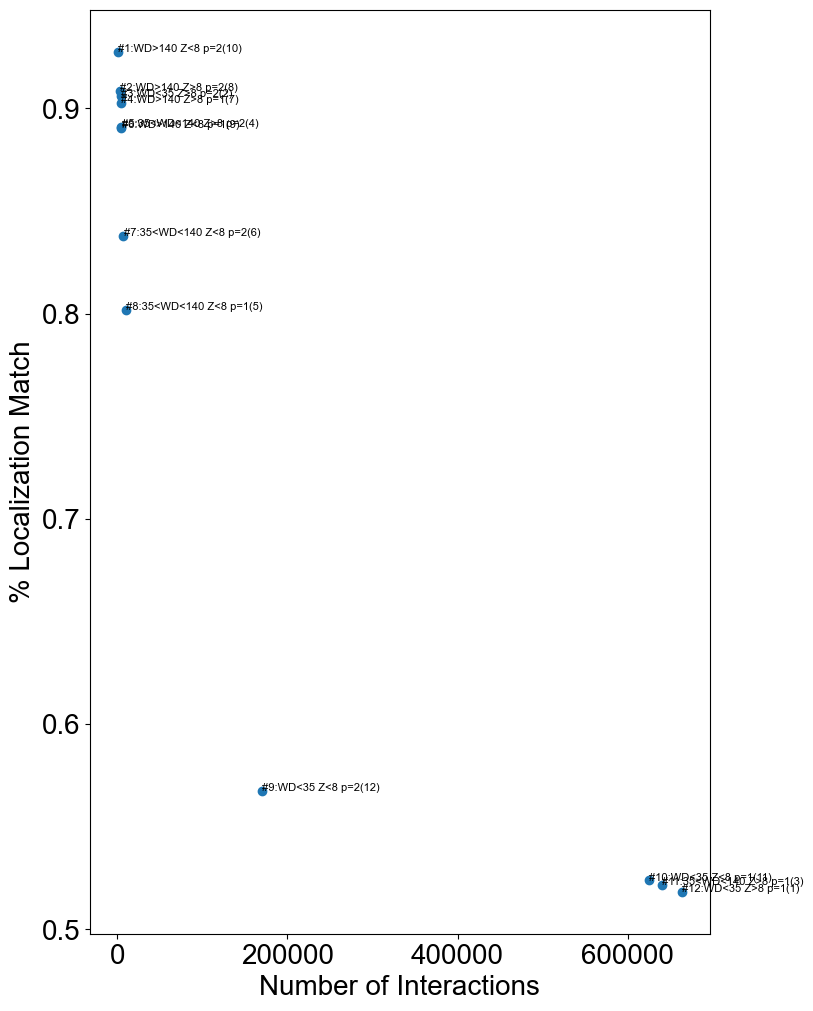

In [123]:
# loc match vs num interactions for each sector
sector_list = [zThresh_p1_WDltlow_WD_venn,
zThresh_p2_WDltlow_WD_venn,
zThresh_p1_low_WD_vennWDhigh_WD_venn,
zThresh_p2_low_WD_vennWDhigh_WD_venn,
ZltThresh_p1_low_WD_vennWDhigh_WD_venn,
ZltThresh_p2_low_WD_vennWDhigh_WD_venn,
zThresh_p1_WDhigh_WD_venn,
zThresh_p2_WDhigh_WD_venn,
ZltThresh_p1_WDhigh_WD_venn,
ZltThresh_p2_WDhigh_WD_venn,
ZltThresh_p1_WDltlow_WD_venn,
ZltThresh_p2_WDltlow_WD_venn]


noOther_sector_list = [noBaitPreyOther_zThresh_p1_WDltlow_WD_venn,
noBaitPreyOther_zThresh_p2_WDltlow_WD_venn,
noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn,
noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn,
noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn,
noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn,
noBaitPreyOther_zThresh_p1_WDhigh_WD_venn,
noBaitPreyOther_zThresh_p2_WDhigh_WD_venn,
noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn,
noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn,
noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn,
noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn]

sector_match_arr = np.array(sector_match_list)
sector_order_inds = np.argsort(-sector_match_arr)
print('Highest to lowest match percent sector:', sector_order_inds+1)

cumulative_num_interacts = []
cumulative_match = []
interacts_counter = 0
cumulative_df = pd.DataFrame([])
for i in range(12):
    interacts_counter += sector_list[sector_order_inds[i]].shape[0]
    cumulative_num_interacts.append(interacts_counter)
    
    if i == 0:
        cumulative_df = noOther_sector_list[sector_order_inds[i]] # initialize cumulative df
    else:
        cumulative_df = pd.concat([cumulative_df, noOther_sector_list[sector_order_inds[i]]]) # append to cumulative df

    # calculate loc match % for cumulative df
    cumulative_df_match = cumulative_df[cumulative_df['Localization Match'] == 1]
    cumulative_match.append(cumulative_df_match.shape[0] / cumulative_df.shape[0])
        
print('Number of interactions (cumulative):', cumulative_num_interacts)
print('Cumulative localization match %:', cumulative_match)

plt.rcParams.update({"figure.figsize":(8,12)}) # plot size
plt.scatter(cumulative_num_interacts, cumulative_match)

plt.xlabel('Number of Interactions')
plt.ylabel('% Localization Match')



sector_labels = ['WD<%d Z>%d p=1' %(low_WD_venn, Z_venn), 'WD<%d Z>%d p=2' %(low_WD_venn, Z_venn),
                 '%d<WD<%d Z>%d p=1' %(low_WD_venn, high_WD_venn, Z_venn), '%d<WD<%d Z>%d p=2' %(low_WD_venn, high_WD_venn, Z_venn),
                 '%d<WD<%d Z<%d p=1' %(low_WD_venn, high_WD_venn, Z_venn), '%d<WD<%d Z<%d p=2' %(low_WD_venn, high_WD_venn, Z_venn),
                 'WD>%d Z>%d p=1' %(high_WD_venn, Z_venn), 'WD>%d Z>%d p=2' %(high_WD_venn, Z_venn),
                 'WD>%d Z<%d p=1' %(high_WD_venn, Z_venn), 'WD>%d Z<%d p=2' %(high_WD_venn, Z_venn),
                 'WD<%d Z<%d p=1' %(low_WD_venn, Z_venn), 'WD<%d Z<%d p=2' %(low_WD_venn, Z_venn)]

for i, txt in enumerate([1,2,3,4,5,6,7,8,9,10,11,12]):
    print(i, txt)
    plt.annotate('#' + str(txt) + ':' + sector_labels[sector_order_inds[i]] + '(%d)' %(sector_order_inds[i]+1), (cumulative_num_interacts[i]+300, cumulative_match[i]), fontsize=8)
#     plt.annotate('#' + str(txt) + ':' + sector_labels[sector_order_inds[i]], (cumulative_num_interacts[i]+5000, cumulative_match[i]+0.002), fontsize=8)

    
# plt.xlim([-1000,20000])
# plt.ylim([0.75,1])

In [124]:
# Non-high confidence set

# noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn
# noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn
# noBaitPreyOther_zThresh_p1_WDltlow_WD_venn
# noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn

    
cumulative_num_interacts = []
cumulative_match = []
interacts_counter = 0
cumulative_df = pd.DataFrame([])

for i in [8, 9, 10, 11]:
    interacts_counter += sector_list[sector_order_inds[i]].shape[0]
    cumulative_num_interacts.append(interacts_counter)
    
    if i == 0:
        cumulative_df = noOther_sector_list[sector_order_inds[i]] # initialize cumulative df
    else:
        cumulative_df = pd.concat([cumulative_df, noOther_sector_list[sector_order_inds[i]]]) # append to cumulative df

    # calculate loc match % for cumulative df
    cumulative_df_match = cumulative_df[cumulative_df['Localization Match'] == 1]
    cumulative_match.append(cumulative_df_match.shape[0] / cumulative_df.shape[0])
        
print('Number of interactions (cumulative):', cumulative_num_interacts)
print('Cumulative localization match %:', cumulative_match)

Number of interactions (cumulative): [159504, 614331, 630119, 653229]
Cumulative localization match %: [0.5496277915632755, 0.5173869599108549, 0.5151227521100024, 0.5119504929641033]


In [125]:
cumulative_num_interacts = []
cumulative_match = []
interacts_counter = 0
cumulative_df = pd.DataFrame([])

i=8
interacts_counter += sector_list[sector_order_inds[i]].shape[0]
cumulative_num_interacts.append(interacts_counter)

if i == 0:
    cumulative_df = noOther_sector_list[sector_order_inds[i]] # initialize cumulative df
else:
    cumulative_df = pd.concat([cumulative_df, noOther_sector_list[sector_order_inds[i]]]) # append to cumulative df

# calculate loc match % for cumulative df
cumulative_df_match = cumulative_df[cumulative_df['Localization Match'] == 1]
cumulative_match.append(cumulative_df_match.shape[0] / cumulative_df.shape[0])

print('Number of interactions (cumulative):', cumulative_num_interacts)
print('Cumulative localization match %:', cumulative_match)

Number of interactions (cumulative): [159504]
Cumulative localization match %: [0.5496277915632755]


#### calc avg spectral counts for each venn diagram section

In [126]:
avg_spec_counts = []

for l in sector_list:
    spec1 = l['Rep 1 Spectral Counts']
    spec2 = l['Rep 2 Spectral Counts']
    avg_spec_counts.append(np.mean((spec1 + spec2)/2))
    
avg_spec_counts

[0.7504976200778883,
 28.346153846153847,
 0.6494806181910312,
 19.810169491525425,
 0.8565763384005287,
 2.619802828975568,
 4.166666666666667,
 19.721491228070175,
 5.863636363636363,
 3.658659217877095,
 0.9064281583986878,
 4.677559810412278]

1: 1686 / 4501 0.3745834259053544
2: 245 / 275 0.8909090909090909
3: 1502 / 3756 0.39989350372736954
4: 208 / 259 0.803088803088803
5: 915 / 1288 0.7104037267080745
6: 759 / 1044 0.7270114942528736
7: 71 / 85 0.8352941176470589
8: 968 / 1076 0.8996282527881041
9: 8 / 10 0.8
10: 461 / 497 0.9275653923541247
11: 66116 / 131505 0.5027641534542413
12: 32782 / 59644 0.5496277915632755
Highest to lowest match percent sector: [10  8  2  7  4  9  6  5 12 11  3  1]
Number of interactions (cumulative): [895, 3403, 3988, 4225, 4815, 4837, 7170, 10196, 169700, 624527, 640315, 663425]
Cumulative localization match %: [0.9275653923541247, 0.9084551811824539, 0.9058441558441559, 0.9027418520434558, 0.8909671532846716, 0.8905540417801998, 0.8379544054220579, 0.8017203352448169, 0.567437439621054, 0.5239750003832729, 0.5216381951373603, 0.5183926645091693]


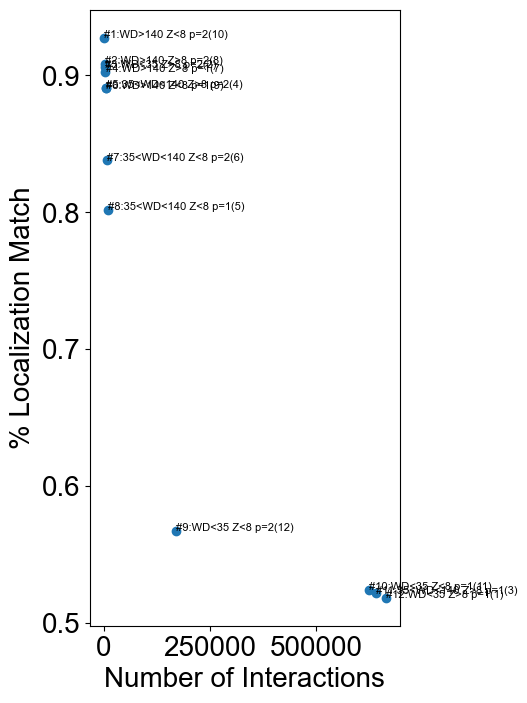

In [127]:
# loc match vs num interactions for each sector
# set thresholds
high_WD_venn = 140
low_WD_venn = 35
Z_venn = 8


# store loc match percents
sector_match_list = []



# add % loc match values
# fill in Venn diagram with Loc Match % no Other (including flagged) NO OTHER
noBaitPreyOther_p1 = noBaitPreyOther[noBaitPreyOther['p Value'] == 1]
noBaitPreyOther_p2 = noBaitPreyOther[noBaitPreyOther['p Value'] == 2]

# 1: Z>5 p=1 WD<low_WD_venn
noBaitPreyOther_zThresh_p1 = noBaitPreyOther_p1[noBaitPreyOther_p1['Z Score'] > Z_venn]
noBaitPreyOther_zThresh_p1_WDltlow_WD_venn = noBaitPreyOther_zThresh_p1[np.abs(noBaitPreyOther_zThresh_p1['WD Score']) < low_WD_venn]
noBaitPreyOther_zThresh_p1_WDltlow_WD_venn_match = noBaitPreyOther_zThresh_p1_WDltlow_WD_venn[noBaitPreyOther_zThresh_p1_WDltlow_WD_venn['Localization Match']==1]

print('1:', noBaitPreyOther_zThresh_p1_WDltlow_WD_venn_match.shape[0], '/', noBaitPreyOther_zThresh_p1_WDltlow_WD_venn.shape[0], noBaitPreyOther_zThresh_p1_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p1_WDltlow_WD_venn.shape[0])


# 2: Z>5 p=2 WD<low_WD_venn
noBaitPreyOther_zThresh_p2 = noBaitPreyOther_p2[noBaitPreyOther_p2['Z Score'] > Z_venn]
noBaitPreyOther_zThresh_p2_WDltlow_WD_venn = noBaitPreyOther_zThresh_p2[np.abs(noBaitPreyOther_zThresh_p2['WD Score']) < low_WD_venn]
noBaitPreyOther_zThresh_p2_WDltlow_WD_venn_match = noBaitPreyOther_zThresh_p2_WDltlow_WD_venn[noBaitPreyOther_zThresh_p2_WDltlow_WD_venn['Localization Match']==1]

print('2:', noBaitPreyOther_zThresh_p2_WDltlow_WD_venn_match.shape[0], '/', noBaitPreyOther_zThresh_p2_WDltlow_WD_venn.shape[0],noBaitPreyOther_zThresh_p2_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p2_WDltlow_WD_venn.shape[0])

# 3: Z>5 p=1 low_WD_venn<WD<high_WD_venn
noBaitPreyOther_zThresh_p1_WDlow_WD_venn = noBaitPreyOther_zThresh_p1[np.abs(noBaitPreyOther_zThresh_p1['WD Score']) > low_WD_venn]
noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn = noBaitPreyOther_zThresh_p1_WDlow_WD_venn[np.abs(noBaitPreyOther_zThresh_p1_WDlow_WD_venn['WD Score']) < high_WD_venn]
noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn_match = noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn[noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn['Localization Match']==1]

print('3:', noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0], noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0])

# 4: Z>5 p=2 low_WD_venn<WD<high_WD_venn
noBaitPreyOther_zThresh_p2_WDlow_WD_venn = noBaitPreyOther_zThresh_p2[np.abs(noBaitPreyOther_zThresh_p2['WD Score']) > low_WD_venn]
noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn = noBaitPreyOther_zThresh_p2_WDlow_WD_venn[np.abs(noBaitPreyOther_zThresh_p2_WDlow_WD_venn['WD Score']) < high_WD_venn]
noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn_match = noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn[noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn['Localization Match']==1]

print('4:', noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0], noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0])

# 5: Z<5 p=1 low_WD_venn<WD<high_WD_venn
noBaitPreyOther_ZltThresh_p1 = noBaitPreyOther_p1[noBaitPreyOther_p1['Z Score'] < Z_venn]
noBaitPreyOther_ZltThresh_p1_WDlow_WD_venn = noBaitPreyOther_ZltThresh_p1[np.abs(noBaitPreyOther_ZltThresh_p1['WD Score']) > low_WD_venn]
noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn = noBaitPreyOther_ZltThresh_p1_WDlow_WD_venn[np.abs(noBaitPreyOther_ZltThresh_p1_WDlow_WD_venn['WD Score']) < high_WD_venn]
noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn_match = noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn[noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn['Localization Match']==1]

print('5:', noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0], noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0])

# 6: Z<5 p=2 low_WD_venn<WD<high_WD_venn
noBaitPreyOther_ZltThresh_p2 = noBaitPreyOther_p2[noBaitPreyOther_p2['Z Score'] < Z_venn]
noBaitPreyOther_ZltThresh_p2_WDlow_WD_venn = noBaitPreyOther_ZltThresh_p2[np.abs(noBaitPreyOther_ZltThresh_p2['WD Score']) > low_WD_venn]
noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn = noBaitPreyOther_ZltThresh_p2_WDlow_WD_venn[np.abs(noBaitPreyOther_ZltThresh_p2_WDlow_WD_venn['WD Score']) < high_WD_venn]
noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn_match = noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn[noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn['Localization Match']==1]

print('6:', noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0], noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0])

# 7: Z>5 p=1 WD>high_WD_venn
noBaitPreyOther_zThresh_p1_WDhigh_WD_venn = noBaitPreyOther_zThresh_p1[np.abs(noBaitPreyOther_zThresh_p1['WD Score']) > high_WD_venn]
noBaitPreyOther_zThresh_p1_WDhigh_WD_venn_match = noBaitPreyOther_zThresh_p1_WDhigh_WD_venn[noBaitPreyOther_zThresh_p1_WDhigh_WD_venn['Localization Match']==1]

print('7:', noBaitPreyOther_zThresh_p1_WDhigh_WD_venn_match.shape[0], '/', noBaitPreyOther_zThresh_p1_WDhigh_WD_venn.shape[0], noBaitPreyOther_zThresh_p1_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p1_WDhigh_WD_venn.shape[0])

# 8: Z>5 p=2 WD>high_WD_venn
noBaitPreyOther_zThresh_p2_WDhigh_WD_venn = noBaitPreyOther_zThresh_p2[np.abs(noBaitPreyOther_zThresh_p2['WD Score']) > high_WD_venn]
noBaitPreyOther_zThresh_p2_WDhigh_WD_venn_match = noBaitPreyOther_zThresh_p2_WDhigh_WD_venn[noBaitPreyOther_zThresh_p2_WDhigh_WD_venn['Localization Match']==1]

print('8:', noBaitPreyOther_zThresh_p2_WDhigh_WD_venn_match.shape[0], '/', noBaitPreyOther_zThresh_p2_WDhigh_WD_venn.shape[0],noBaitPreyOther_zThresh_p2_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p2_WDhigh_WD_venn.shape[0])

# 9: Z<5 p=1 WD>high_WD_venn
noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn = noBaitPreyOther_ZltThresh_p1[np.abs(noBaitPreyOther_ZltThresh_p1['WD Score']) > high_WD_venn]
noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn_match = noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn[noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn['Localization Match']==1]

print('9:', noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn_match.shape[0], '/', noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn.shape[0], noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn.shape[0])

# 10: Z<5 p=2 WD>high_WD_venn
noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn = noBaitPreyOther_ZltThresh_p2[np.abs(noBaitPreyOther_ZltThresh_p2['WD Score']) > high_WD_venn]
noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn_match = noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn[noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn['Localization Match']==1]

print('10:', noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn_match.shape[0], '/',noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn.shape[0], noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn.shape[0])

# 11: Z<5 p=1 WD<low_WD_venn
noBaitPreyOther_ZltThresh_p1 = noBaitPreyOther_p1[noBaitPreyOther_p1['Z Score']<Z_venn]
noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn = noBaitPreyOther_ZltThresh_p1[np.abs(noBaitPreyOther_ZltThresh_p1['WD Score']) < low_WD_venn]
noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn_match = noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn[noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn['Localization Match']==1]

print('11:', noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn_match.shape[0], '/', noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn.shape[0], noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn.shape[0])

# 12: Z<5 p=2 WD<low_WD_venn
noBaitPreyOther_p2_ZltThresh = noBaitPreyOther_p2[noBaitPreyOther_p2['Z Score']<Z_venn]
noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn = noBaitPreyOther_ZltThresh_p2[np.abs(noBaitPreyOther_ZltThresh_p2['WD Score']) < low_WD_venn]
noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn_match = noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn[noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn['Localization Match']==1]

print('12:', noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn_match.shape[0], '/', noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn.shape[0], noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn.shape[0])


# with bait prey other (get num interactions for each sector in whole dataset)
p1 = flag_interaction_df[flag_interaction_df['p Value'] == 1]
p2 = flag_interaction_df[flag_interaction_df['p Value'] == 2]

# 1: Z>Z_venn p=1 WD<low_WD_venn
zThresh_p1 = p1[p1['Z Score'] > Z_venn]
zThresh_p1_WDltlow_WD_venn = zThresh_p1[np.abs(zThresh_p1['WD Score']) < low_WD_venn]
zThresh_p1_WDltlow_WD_venn_match = zThresh_p1_WDltlow_WD_venn[zThresh_p1_WDltlow_WD_venn['Localization Match']==1]

no1_Other = zThresh_p1_WDltlow_WD_venn.shape[0] - noBaitPreyOther_zThresh_p1_WDltlow_WD_venn.shape[0]
no1_contam = zThresh_p1_WDltlow_WD_venn[zThresh_p1_WDltlow_WD_venn['WD Score'] < 0].shape[0]

# print('1:', zThresh_p1_WDltlow_WD_venn_match.shape[0], '/', zThresh_p1_WDltlow_WD_venn.shape[0], zThresh_p1_WDltlow_WD_venn_match.shape[0] / zThresh_p1_WDltlow_WD_venn.shape[0])
# print('1:', no1_Other/zThresh_p1_WDltlow_WD_venn.shape[0]*100)
# print('1:', no1_contam/zThresh_p1_WDltlow_WD_venn.shape[0]*100)


loc_perc = noBaitPreyOther_zThresh_p1_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p1_WDltlow_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)

# 2: Z>Z_venn p=2 WD<low_WD_venn
zThresh_p2 = p2[p2['Z Score'] > Z_venn]
zThresh_p2_WDltlow_WD_venn = zThresh_p2[np.abs(zThresh_p2['WD Score']) < low_WD_venn]
zThresh_p2_WDltlow_WD_venn_match = zThresh_p2_WDltlow_WD_venn[zThresh_p2_WDltlow_WD_venn['Localization Match']==1]
no2_Other = zThresh_p2_WDltlow_WD_venn.shape[0] - noBaitPreyOther_zThresh_p2_WDltlow_WD_venn.shape[0]
no2_contam = zThresh_p2_WDltlow_WD_venn[zThresh_p2_WDltlow_WD_venn['WD Score'] < 0].shape[0]

# print('2:', zThresh_p2_WDltlow_WD_venn_match.shape[0], '/', zThresh_p2_WDltlow_WD_venn.shape[0],zThresh_p2_WDltlow_WD_venn_match.shape[0] / zThresh_p2_WDltlow_WD_venn.shape[0])
# print('2:', no2_Other/zThresh_p2_WDltlow_WD_venn.shape[0]*100)
# print('2:', no2_contam/zThresh_p2_WDltlow_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_zThresh_p2_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p2_WDltlow_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)


# 3: Z>Z_venn p=1 low_WD_venn<WD<high_WD_venn
zThresh_p1_WDlow_WD_venn = zThresh_p1[np.abs(zThresh_p1['WD Score']) > low_WD_venn]
zThresh_p1_low_WD_vennWDhigh_WD_venn = zThresh_p1_WDlow_WD_venn[np.abs(zThresh_p1_WDlow_WD_venn['WD Score']) < high_WD_venn]
zThresh_p1_low_WD_vennWDhigh_WD_venn_match = zThresh_p1_low_WD_vennWDhigh_WD_venn[zThresh_p1_low_WD_vennWDhigh_WD_venn['Localization Match']==1]
no3_Other = zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0] - noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]
no3_contam = zThresh_p1_low_WD_vennWDhigh_WD_venn[zThresh_p1_low_WD_vennWDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('3:', zThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0], zThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0] / zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0])
# print('3:', no3_Other/zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]*100)
# print('3:', no3_contam/zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)


# 4: Z>Z_venn p=2 low_WD_venn<WD<high_WD_venn
zThresh_p2_WDlow_WD_venn = zThresh_p2[np.abs(zThresh_p2['WD Score']) > low_WD_venn]
zThresh_p2_low_WD_vennWDhigh_WD_venn = zThresh_p2_WDlow_WD_venn[np.abs(zThresh_p2_WDlow_WD_venn['WD Score']) < high_WD_venn]
zThresh_p2_low_WD_vennWDhigh_WD_venn_match = zThresh_p2_low_WD_vennWDhigh_WD_venn[zThresh_p2_low_WD_vennWDhigh_WD_venn['Localization Match']==1]
no4_Other = zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0] - noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]
no4_contam = zThresh_p2_low_WD_vennWDhigh_WD_venn[zThresh_p2_low_WD_vennWDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('4:', zThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0], zThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0] / zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0])
# print('4:', no4_Other/zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]*100)
# print('4:', no4_contam/zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)

# 5: Z<Z_venn p=1 low_WD_venn<WD<high_WD_venn
ZltThresh_p1 = p1[p1['Z Score'] < Z_venn]
ZltThresh_p1_WDlow_WD_venn = ZltThresh_p1[np.abs(ZltThresh_p1['WD Score']) > low_WD_venn]
ZltThresh_p1_low_WD_vennWDhigh_WD_venn = ZltThresh_p1_WDlow_WD_venn[np.abs(ZltThresh_p1_WDlow_WD_venn['WD Score']) < high_WD_venn]
ZltThresh_p1_low_WD_vennWDhigh_WD_venn_match = ZltThresh_p1_low_WD_vennWDhigh_WD_venn[ZltThresh_p1_low_WD_vennWDhigh_WD_venn['Localization Match']==1]
no5_Other = ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0] - noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]
no5_contam = ZltThresh_p1_low_WD_vennWDhigh_WD_venn[ZltThresh_p1_low_WD_vennWDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('5:', ZltThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0], ZltThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0] / ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0])
# print('5:', no5_Other/ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]*100)
# print('5:', no5_contam/ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)

# 6: Z<Z_venn p=2 low_WD_venn<WD<high_WD_venn
ZltThresh_p2 = p2[p2['Z Score'] < Z_venn]
ZltThresh_p2_WDlow_WD_venn = ZltThresh_p2[np.abs(ZltThresh_p2['WD Score']) > low_WD_venn]
ZltThresh_p2_low_WD_vennWDhigh_WD_venn = ZltThresh_p2_WDlow_WD_venn[np.abs(ZltThresh_p2_WDlow_WD_venn['WD Score']) < high_WD_venn]
ZltThresh_p2_low_WD_vennWDhigh_WD_venn_match = ZltThresh_p2_low_WD_vennWDhigh_WD_venn[ZltThresh_p2_low_WD_vennWDhigh_WD_venn['Localization Match']==1]
no6_Other = ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0] - noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]
no6_contam = ZltThresh_p2_low_WD_vennWDhigh_WD_venn[ZltThresh_p2_low_WD_vennWDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('6:', ZltThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0], '/', ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0], ZltThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0] / ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0])
# print('6:', no6_Other/ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]*100)
# print('6:', no6_contam/ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)

# 7: Z>Z_venn p=1 WD>high_WD_venn
zThresh_p1_WDhigh_WD_venn = zThresh_p1[np.abs(zThresh_p1['WD Score']) > high_WD_venn]
zThresh_p1_WDhigh_WD_venn_match = zThresh_p1_WDhigh_WD_venn[zThresh_p1_WDhigh_WD_venn['Localization Match']==1]
no7_Other = zThresh_p1_WDhigh_WD_venn.shape[0] - noBaitPreyOther_zThresh_p1_WDhigh_WD_venn.shape[0]
no7_contam = zThresh_p1_WDhigh_WD_venn[zThresh_p1_WDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('7:', zThresh_p1_WDhigh_WD_venn_match.shape[0], '/', zThresh_p1_WDhigh_WD_venn.shape[0], zThresh_p1_WDhigh_WD_venn_match.shape[0] / zThresh_p1_WDhigh_WD_venn.shape[0])
# print('7:', no7_Other/zThresh_p1_WDhigh_WD_venn.shape[0]*100)
# print('7:', no7_contam/zThresh_p1_WDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_zThresh_p1_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p1_WDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)

# 8: Z>Z_venn p=2 WD>high_WD_venn
zThresh_p2_WDhigh_WD_venn = zThresh_p2[np.abs(zThresh_p2['WD Score']) > high_WD_venn]
zThresh_p2_WDhigh_WD_venn_match = zThresh_p2_WDhigh_WD_venn[zThresh_p2_WDhigh_WD_venn['Localization Match']==1]
no8_Other = zThresh_p2_WDhigh_WD_venn.shape[0] - noBaitPreyOther_zThresh_p2_WDhigh_WD_venn.shape[0]
no8_contam = zThresh_p2_WDhigh_WD_venn[zThresh_p2_WDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('8:', zThresh_p2_WDhigh_WD_venn_match.shape[0], '/', zThresh_p2_WDhigh_WD_venn.shape[0], zThresh_p2_WDhigh_WD_venn_match.shape[0] / zThresh_p2_WDhigh_WD_venn.shape[0])
# print('8:', no8_Other/zThresh_p2_WDhigh_WD_venn.shape[0]*100)
# print('8:', no8_contam/zThresh_p2_WDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_zThresh_p2_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_zThresh_p2_WDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)

# 9: Z<Z_venn p=1 WD>high_WD_venn
ZltThresh_p1_WDhigh_WD_venn = ZltThresh_p1[np.abs(ZltThresh_p1['WD Score']) > high_WD_venn]
ZltThresh_p1_WDhigh_WD_venn_match = ZltThresh_p1_WDhigh_WD_venn[ZltThresh_p1_WDhigh_WD_venn['Localization Match']==1]
no9_Other = ZltThresh_p1_WDhigh_WD_venn.shape[0] - noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn.shape[0]
no9_contam = ZltThresh_p1_WDhigh_WD_venn[ZltThresh_p1_WDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('9:', ZltThresh_p1_WDhigh_WD_venn_match.shape[0], '/', ZltThresh_p1_WDhigh_WD_venn.shape[0], ZltThresh_p1_WDhigh_WD_venn_match.shape[0] / ZltThresh_p1_WDhigh_WD_venn.shape[0])
# print('9:', no9_Other/ZltThresh_p1_WDhigh_WD_venn.shape[0]*100)
# print('9:', no9_contam/ZltThresh_p1_WDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)

# 10: Z<Z_venn p=2 WD>high_WD_venn
ZltThresh_p2_WDhigh_WD_venn = ZltThresh_p2[np.abs(ZltThresh_p2['WD Score']) > high_WD_venn]
ZltThresh_p2_WDhigh_WD_venn_match = ZltThresh_p2_WDhigh_WD_venn[ZltThresh_p2_WDhigh_WD_venn['Localization Match']==1]
no10_Other = ZltThresh_p2_WDhigh_WD_venn.shape[0] - noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn.shape[0]
no10_contam = ZltThresh_p2_WDhigh_WD_venn[ZltThresh_p2_WDhigh_WD_venn['WD Score'] < 0].shape[0]

# print('10:', ZltThresh_p2_WDhigh_WD_venn_match.shape[0], '/',ZltThresh_p2_WDhigh_WD_venn.shape[0], ZltThresh_p2_WDhigh_WD_venn_match.shape[0] / ZltThresh_p2_WDhigh_WD_venn.shape[0])
# print('10:', no10_Other/ZltThresh_p2_WDhigh_WD_venn.shape[0]*100)
# print('10:', no10_contam/ZltThresh_p2_WDhigh_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)

# 11: Z<Z_venn p=1 WD<low_WD_venn
ZltThresh_p1 = p1[p1['Z Score']<Z_venn]
ZltThresh_p1_WDltlow_WD_venn = ZltThresh_p1[np.abs(ZltThresh_p1['WD Score']) < low_WD_venn]
ZltThresh_p1_WDltlow_WD_venn_match = ZltThresh_p1_WDltlow_WD_venn[ZltThresh_p1_WDltlow_WD_venn['Localization Match']==1]
no11_Other = ZltThresh_p1_WDltlow_WD_venn.shape[0] - noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn.shape[0]
no11_contam = ZltThresh_p1_WDltlow_WD_venn[ZltThresh_p1_WDltlow_WD_venn['WD Score'] < 0].shape[0]

# print('11:', ZltThresh_p1_WDltlow_WD_venn_match.shape[0], '/', ZltThresh_p1_WDltlow_WD_venn.shape[0], ZltThresh_p1_WDltlow_WD_venn_match.shape[0] / ZltThresh_p1_WDltlow_WD_venn.shape[0])
# print('11:', no11_Other/ZltThresh_p1_WDltlow_WD_venn.shape[0]*100)
# print('11:', no11_contam/ZltThresh_p1_WDltlow_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)

# 12: Z<Z_venn p=2 WD<low_WD_venn
p2_ZltThresh = p2[p2['Z Score']<Z_venn]
ZltThresh_p2_WDltlow_WD_venn = ZltThresh_p2[np.abs(ZltThresh_p2['WD Score']) < low_WD_venn]
ZltThresh_p2_WDltlow_WD_venn_match = ZltThresh_p2_WDltlow_WD_venn[ZltThresh_p2_WDltlow_WD_venn['Localization Match']==1]
no12_Other = ZltThresh_p2_WDltlow_WD_venn.shape[0] - noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn.shape[0]
no12_contam = ZltThresh_p2_WDltlow_WD_venn[ZltThresh_p2_WDltlow_WD_venn['WD Score'] < 0].shape[0]

# print('12:', ZltThresh_p2_WDltlow_WD_venn_match.shape[0], '/', ZltThresh_p2_WDltlow_WD_venn.shape[0], ZltThresh_p2_WDltlow_WD_venn_match.shape[0] / ZltThresh_p2_WDltlow_WD_venn.shape[0])
# print('12:', no12_Other/ZltThresh_p2_WDltlow_WD_venn.shape[0]*100)
# print('12:', no12_contam/ZltThresh_p2_WDltlow_WD_venn.shape[0]*100)

loc_perc = noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn_match.shape[0] / noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn.shape[0] * 100
sector_match_list.append(loc_perc)


sector_list = [zThresh_p1_WDltlow_WD_venn,
zThresh_p2_WDltlow_WD_venn,
zThresh_p1_low_WD_vennWDhigh_WD_venn,
zThresh_p2_low_WD_vennWDhigh_WD_venn,
ZltThresh_p1_low_WD_vennWDhigh_WD_venn,
ZltThresh_p2_low_WD_vennWDhigh_WD_venn,
zThresh_p1_WDhigh_WD_venn,
zThresh_p2_WDhigh_WD_venn,
ZltThresh_p1_WDhigh_WD_venn,
ZltThresh_p2_WDhigh_WD_venn,
ZltThresh_p1_WDltlow_WD_venn,
ZltThresh_p2_WDltlow_WD_venn]


noOther_sector_list = [noBaitPreyOther_zThresh_p1_WDltlow_WD_venn,
noBaitPreyOther_zThresh_p2_WDltlow_WD_venn,
noBaitPreyOther_zThresh_p1_low_WD_vennWDhigh_WD_venn,
noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn,
noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn,
noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn,
noBaitPreyOther_zThresh_p1_WDhigh_WD_venn,
noBaitPreyOther_zThresh_p2_WDhigh_WD_venn,
noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn,
noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn,
noBaitPreyOther_ZltThresh_p1_WDltlow_WD_venn,
noBaitPreyOther_ZltThresh_p2_WDltlow_WD_venn]

sector_match_arr = np.array(sector_match_list)
sector_order_inds_z8 = np.argsort(-sector_match_arr)
print('Highest to lowest match percent sector:', sector_order_inds_z8+1)

cumulative_num_interacts_z8 = []
cumulative_match_z8 = []
interacts_counter = 0
cumulative_df = pd.DataFrame([])
for i in range(12):
    interacts_counter += sector_list[sector_order_inds_z8[i]].shape[0]
    cumulative_num_interacts_z8.append(interacts_counter)
    
    if i == 0:
        cumulative_df = noOther_sector_list[sector_order_inds_z8[i]] # initialize cumulative df
    else:
        cumulative_df = pd.concat([cumulative_df, noOther_sector_list[sector_order_inds_z8[i]]]) # append to cumulative df

    # calculate loc match % for cumulative df
    cumulative_df_match = cumulative_df[cumulative_df['Localization Match'] == 1]
    cumulative_match_z8.append(cumulative_df_match.shape[0] / cumulative_df.shape[0])
        
print('Number of interactions (cumulative):', cumulative_num_interacts_z8)
print('Cumulative localization match %:', cumulative_match_z8)

plt.rcParams.update({"figure.figsize":(4,8)}) # plot size
plt.scatter(cumulative_num_interacts_z8, cumulative_match_z8)

plt.xlabel('Number of Interactions')
plt.ylabel('% Localization Match')

sector_labels_z8 = ['WD<%d Z>%d p=1' %(low_WD_venn, Z_venn), 'WD<%d Z>%d p=2' %(low_WD_venn, Z_venn),
                 '%d<WD<%d Z>%d p=1' %(low_WD_venn, high_WD_venn, Z_venn), '%d<WD<%d Z>%d p=2' %(low_WD_venn, high_WD_venn, Z_venn),
                 '%d<WD<%d Z<%d p=1' %(low_WD_venn, high_WD_venn, Z_venn), '%d<WD<%d Z<%d p=2' %(low_WD_venn, high_WD_venn, Z_venn),
                 'WD>%d Z>%d p=1' %(high_WD_venn, Z_venn), 'WD>%d Z>%d p=2' %(high_WD_venn, Z_venn),
                 'WD>%d Z<%d p=1' %(high_WD_venn, Z_venn), 'WD>%d Z<%d p=2' %(high_WD_venn, Z_venn),
                 'WD<%d Z<%d p=1' %(low_WD_venn, Z_venn), 'WD<%d Z<%d p=2' %(low_WD_venn, Z_venn)]

for i, txt in enumerate([1,2,3,4,5,6,7,8,9,10,11,12]):
    plt.annotate('#' + str(txt) + ':' + sector_labels_z8[sector_order_inds_z8[i]] + '(%d)' %(sector_order_inds_z8[i]+1), (cumulative_num_interacts_z8[i]+300, cumulative_match_z8[i]), fontsize=8)
#     plt.annotate('#' + str(txt) + ':' + sector_labels_z8[sector_order_inds_z8[i]], (cumulative_num_interacts_z8[i]+5000, cumulative_match_z8[i]+0.002), fontsize=8)

    
# plt.xlim([-1000,20000])
# plt.ylim([0.75,1])

#### plot % match vs number of prey for each bait in high conf list

In [128]:
high_conf_list = [ZltThresh_p2_low_WD_vennWDhigh_WD_venn,
                  zThresh_p2_WDltlow_WD_venn,
                  zThresh_p2_low_WD_vennWDhigh_WD_venn,
                  zThresh_p1_WDhigh_WD_venn,
                  zThresh_p2_WDhigh_WD_venn,
                  ZltThresh_p1_WDhigh_WD_venn,
                  ZltThresh_p2_WDhigh_WD_venn]
                  # ZltThresh_p1_low_WD_vennWDhigh_WD_venn,

high_conf_noOther_list = [noBaitPreyOther_ZltThresh_p2_low_WD_vennWDhigh_WD_venn,
                          noBaitPreyOther_zThresh_p2_WDltlow_WD_venn,
                          noBaitPreyOther_zThresh_p2_low_WD_vennWDhigh_WD_venn,
                          noBaitPreyOther_zThresh_p1_WDhigh_WD_venn,
                          noBaitPreyOther_zThresh_p2_WDhigh_WD_venn,
                          noBaitPreyOther_ZltThresh_p1_WDhigh_WD_venn,
                          noBaitPreyOther_ZltThresh_p2_WDhigh_WD_venn]
                          # noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn,
    

high_conf_df = ZltThresh_p1_low_WD_vennWDhigh_WD_venn.copy()
high_conf_noOther = noBaitPreyOther_ZltThresh_p1_low_WD_vennWDhigh_WD_venn.copy()

for i in range(len(high_conf_list)):
    high_conf_df = pd.concat([high_conf_df, high_conf_list[i]]) # append to cumulative df
    high_conf_noOther = pd.concat([high_conf_noOther, high_conf_noOther_list[i]])

In [129]:
high_conf_df

,Bait CreID,Bait Gene Symbol,Bait Info,Prey CreID,Prey Gene Symbol,Prey Info,WD Score,Z Score,WD Z Score,Rep 1 Spectral Counts,...,Prey Experimental Localization,Prey PredAlgo Predicted Localization,Bait GreenCut,Bait Conservation,Bait Conservation Defline,Prey GreenCut,Prey Conservation,Prey Conservation Defline,Localization Match,p Value
3538,Cre01.g002150,Not Found,Not Found,Cre07.g327400,NUO9,NADH:ubiquinone oxidoreductase ND9 subunit,38.775079,1.090022,0.063634,0.0,...,mitochondria,Mitochondrial,Not Found,Not Found,Not Found,Not Found,ATMG00070,NADH dehydrogenase subunit 9,0.0,1.0
3685,Cre01.g002150,Not Found,Not Found,Cre03.g183600,Not Found,(1 of 1) PF15375 - Domain of unknown function ...,50.361191,0.189386,0.007820,0.0,...,nucleus/nucleolus,Chloroplast,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,1.0
3737,Cre01.g002150,Not Found,Not Found,Cre16.g661550,Not Found,"(1 of 1) PF06941 - 5' nucleotidase, deoxy (Pyr...",50.560489,1.346336,0.064639,0.0,...,chloroplast/homogeneous/pyrenoid depleted,Chloroplast,Not Found,Not Found,Not Found,Not Found,AT4G33140,Haloacid dehalogenase-like hydrolase (HAD) sup...,1.0,1.0
6211,Cre01.g002150,Not Found,Not Found,Cre09.g416200,MBB1,PsbB mRNA maturation factor,42.976430,0.429066,0.034094,0.0,...,Not Found,Mitochondrial,Not Found,Not Found,Not Found,184691,AT3G17040,high chlorophyll fluorescent 107,1.0,1.0
6473,Cre01.g002150,Not Found,Not Found,Cre16.g658950,Not Found,Not Found,52.445009,2.940690,0.104907,0.0,...,Not Found,Chloroplast,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14584966,Cre17.g729150,Not Found,(1 of 90) PF00076 - RNA recognition motif. (a....,Cre01.g030850,POA4,20S proteasome alpha subunit D,5035.092878,5.590577,13.289659,5.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT3G51260,20S proteasome alpha subunit PAD1,0.0,2.0
14584995,Cre17.g729150,Not Found,(1 of 90) PF00076 - RNA recognition motif. (a....,Cre10.g419750,RPB3,"DNA-directed RNA polymerase II, 36 kDa polypep...",494.069785,2.847576,9.186368,1.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT2G15430,DNA-directed RNA polymerase family protein,0.0,2.0
14585022,Cre17.g729150,Not Found,(1 of 90) PF00076 - RNA recognition motif. (a....,Cre06.g304300,POA6,20S proteasome alpha subunit F,10053.035595,6.438900,14.621522,3.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT5G42790,proteasome alpha subunit F1,0.0,2.0
14585025,Cre17.g729150,Not Found,(1 of 90) PF00076 - RNA recognition motif. (a....,Cre17.g724350,POA5,20S proteasome alpha subunit E,1685.230093,3.489331,11.499804,1.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT1G53850,20S proteasome alpha subunit E1,0.0,2.0


### Export Whole Dataset (non-zero WD)

In [131]:
nonzero_df = flag_interaction_df[np.abs(flag_interaction_df['WD Score'])>0]
nonzero_df.head(10)

,Bait CreID,Bait Gene Symbol,Bait Info,Prey CreID,Prey Gene Symbol,Prey Info,WD Score,Z Score,WD Z Score,Rep 1 Spectral Counts,...,Prey Experimental Localization,Prey PredAlgo Predicted Localization,Bait GreenCut,Bait Conservation,Bait Conservation Defline,Prey GreenCut,Prey Conservation,Prey Conservation Defline,Localization Match,p Value
0,Cre01.g002150,Not Found,Not Found,Cre12.g551050,Not Found,(1 of 2) PTHR31802//PTHR31802:SF3 - FAMILY NOT...,8.580952,1.767454,1.620039,95.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,2.0
1,Cre01.g002150,Not Found,Not Found,Venus-FLAG,Not Found,Not Found,4.949747,-0.417311,-0.323982,27.0,...,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,2.0
2,Cre01.g002150,Not Found,Not Found,Cre06.g258800,CWP2,Hydroxyproline-rich glycoprotein component of ...,5.000000,-0.086985,0.001823,33.0,...,Not Found,Secretory,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,2.0
3,Cre01.g002150,Not Found,Not Found,Cre13.g592500,Not Found,(1 of 1) K00953 - FAD synthetase (FLAD1),5.622626,0.142626,0.252227,38.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT5G03430,phosphoadenosine phosphosulfate (PAPS) reducta...,0.0,2.0
4,Cre01.g002150,Not Found,Not Found,Cre15.g635650,Not Found,(1 of 12) PF02037 - SAP domain (SAP),6.741201,0.607767,1.157071,21.0,...,Not Found,Chloroplast,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,1.0,2.0
5,Cre01.g002150,Not Found,Not Found,Cre16.g651750,TSI2,isoleucyl-tRNA synthetase,2.032997,-0.943639,-0.993926,6.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT4G10320,"tRNA synthetase class I (I, L, M and V) family...",0.0,2.0
7,Cre01.g002150,Not Found,Not Found,Cre06.g263450,EEF1A3,Eukaryotic translation elongation factor 1 alpha,3.082207,-1.022317,-1.083193,14.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT1G07930,GTP binding Elongation factor Tu family protein,0.0,2.0
8,Cre01.g002150,Not Found,Not Found,Cre01.g010900,GAPA1,Glyceraldehyde-3-Phosphate Dehydrogenase,5.583104,0.144697,0.487645,21.0,...,chloroplast/not homogeneous/pyrenoid depleted,Chloroplast,Not Found,Not Found,Not Found,Not Found,AT1G42970,glyceraldehyde-3-phosphate dehydrogenase B sub...,1.0,2.0
9,Cre01.g002150,Not Found,Not Found,Cre09.g394200,FAP102,Flagellar Associated Protein 102,3.807887,-0.093927,-0.002579,25.0,...,Not Found,Secretory,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,2.0
10,Cre01.g002150,Not Found,Not Found,Cre05.g234550,FBA3,"Fructose-1,6-bisphosphate aldolase",4.256044,0.036170,0.219349,20.0,...,chloroplast/not homogeneous/pyrenoid depleted/...,Chloroplast,Not Found,Not Found,Not Found,Not Found,AT4G38970,fructose-bisphosphate aldolase 2,1.0,2.0


In [132]:
# check Excel size limit
nonzero_df.shape[0] < 1000000

True

In [133]:
np.any(nonzero_df['WD Score'] < 0)

True

In [134]:
nonzero_df[nonzero_df['WD Score'] < 0]

,Bait CreID,Bait Gene Symbol,Bait Info,Prey CreID,Prey Gene Symbol,Prey Info,WD Score,Z Score,WD Z Score,Rep 1 Spectral Counts,...,Prey Experimental Localization,Prey PredAlgo Predicted Localization,Bait GreenCut,Bait Conservation,Bait Conservation Defline,Prey GreenCut,Prey Conservation,Prey Conservation Defline,Localization Match,p Value
30,Cre01.g002150,Not Found,Not Found,Cre08.g372100,HSP70A,Heat shock protein 70A,-0.795581,-0.747257,-0.931005,1.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT5G02500,heat shock cognate protein 70-1,0.0,1.0
214,Cre01.g002150,Not Found,Not Found,Cre03.g156900,LHCBM5,Light-harvesting Chlorophyll a/b binding prote...,-1.083876,-0.663247,-0.436458,0.0,...,chloroplast/homogeneous/not pyrenoid depleted;...,Chloroplast,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,1.0,1.0
348,Cre01.g002150,Not Found,Not Found,Cre03.g176651,MYSM1,Histone H2A deubiquitinase,-0.959696,-0.555554,-0.370784,1.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,Not Found,Not Found,0.0,1.0
13408,Cre01.g002300,CYN19B,Cyclophilin,Cre08.g359350,BC1,Biotin carboxylase,-1.796044,0.089680,0.248501,5.0,...,Not Found,Chloroplast,Not Found,AT2G21130,Cyclophilin-like peptidyl-prolyl cis-trans iso...,Not Found,AT5G35360,acetyl Co-enzyme a carboxylase biotin carboxyl...,0.0,1.0
13413,Cre01.g002300,CYN19B,Cyclophilin,Cre01.g050950,CHLP1,(1 of 1) 1.3.1.83 - Geranylgeranyl diphosphate...,-2.942487,-0.108469,-0.211881,2.0,...,chloroplast/chloroplast punctate dots,Chloroplast,Not Found,AT2G21130,Cyclophilin-like peptidyl-prolyl cis-trans iso...,Not Found,AT1G74470,Pyridine nucleotide-disulphide oxidoreductase ...,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14849850,Venus-3xFLAG,Not Found,Not Found,Cre10.g420750,RPL30,Cytosolic 80S ribosomal protein L30,-1.015039,-0.367493,-0.343643,1.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT1G77940,Ribosomal protein L7Ae/L30e/S12e/Gadd45 family...,0.0,1.0
14849927,Venus-3xFLAG,Not Found,Not Found,Cre11.g480150,RPS14,Cytosolic 80S ribosomal protein S14,-1.268999,-0.411563,-0.268648,3.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT2G36160,Ribosomal protein S11 family protein,0.0,1.0
14850818,Venus-3xFLAG,Not Found,Not Found,Cre13.g590750,HTB21,Histone H2B,-1.125362,-0.459034,-0.311249,1.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT5G59910,Histone superfamily protein,0.0,1.0
14853786,Venus-3xFLAG,Not Found,Not Found,Cre17.g708600,HTB27,Histone H2B,-4.460836,0.055747,0.255543,1.0,...,Not Found,Other,Not Found,Not Found,Not Found,Not Found,AT5G59910,Histone superfamily protein,0.0,1.0


In [135]:
np.any(nonzero_df['Bait Gene Symbol'] != 'Not Found')

True

In [354]:
# export nonzero neg flagged interaction list (format like Luke Table S5) to Excel
with pd.ExcelWriter('nonzeroWD_negFlag.xlsx', mode='w') as writer:  
    nonzero_df.to_excel(writer, sheet_name='neg flag')

### Add SAINT Scores for non-zero WD interactions (except Venus-3xFLAG control)
SAINT score calculation settings: -L2 -R2, Venus-3xFLAG 2 replicates as controls, -spc, unflagged

In [136]:
SAINT_sheet = pd.read_excel(SAINT_fname, 
                           sheet_name = 0,
                           index_col = None,
                           skiprows = 0) 

# separate spectral counts and extract p values (num nonzero replicates)
sep_spec = np.char.split(SAINT_sheet['Spec'].to_numpy(dtype='str'), sep='|')
spec_rep1 = np.zeros(SAINT_sheet.shape[0])
spec_rep2 = np.zeros(SAINT_sheet.shape[0])
p_col = np.zeros(SAINT_sheet.shape[0])

for i in range(sep_spec.shape[0]):
    rep1 = int(sep_spec[i][0])
    rep2 = int(sep_spec[i][1])
    
    spec_rep1[i] = rep1
    spec_rep2[i] = rep2
    
    p_col[i] = (rep1>0) + (rep2>0)
    
SAINT_sheet['p Value'] = p_col
SAINT_sheet['Rep 1 Spec'] = spec_rep1
SAINT_sheet['Rep 2 Spec'] = spec_rep2

In [137]:
# sort WD and SAINT interaction lists --> check they're equal --> concatenate SAINT to WD

# get subset of flag_interaction_df with nonzero WD and not Venus control
nonzero_df = flag_interaction_df[np.abs(flag_interaction_df['WD Score'])>0]
nonzero_nonVenus_df = nonzero_df[nonzero_df['Bait CreID'] != 'Venus-3xFLAG']

# sort
sort_WD_df = nonzero_nonVenus_df.sort_values(['Bait CreID', 'Prey CreID'])
sort_SAINT_df = SAINT_sheet.sort_values(['Bait', 'PreyGene'])

# check if equal
print('same bait order:', np.array_equal(sort_SAINT_df['Bait'].to_numpy(), sort_WD_df['Bait CreID'].to_numpy()))
print('same prey order:', np.array_equal(sort_SAINT_df['PreyGene'].to_numpy(), sort_WD_df['Prey CreID'].to_numpy()))
print('same p values:', np.array_equal(sort_SAINT_df['p Value'].to_numpy(), sort_WD_df['p Value'].to_numpy()))
# note: it will say p values don't match because self-interactions have been zero'd out for some reason

# choose columns to keep
keep_SAINT = sort_SAINT_df.iloc[:,[3,18,19,5,7,8,9,12,13,14,15,17]].copy()
keep_SAINT.columns = ['Spec','Rep 1 Spec','Rep 2 Spec','AvgSpec','ctrlCounts','AvgP','MaxP',
                      'SaintScore','logOddsScore','FoldChange','BFDR','SAINT p Value']

# concatenate
WD_SAINT_df = pd.concat([sort_WD_df.reset_index(drop=True), keep_SAINT.reset_index(drop=True)], axis= 1)

same bait order: True
same prey order: True
same p values: False


In [138]:
# instances where p vals don't match between WD and SAINT 
# -- same as list of all self interactions, p=1 or 2 in WD and p=0 in SAINT
np.where(WD_SAINT_df['p Value'].to_numpy() != WD_SAINT_df['SAINT p Value'].to_numpy())

(array([     3,   1205,   1838,   2260,   2732,   3457,   4371,   5043,
          5580,   6191,   6656,   7231,   8305,   9076,   9606,  10112,
         10432,  11113,  11554,  12302,  12965,  15266,  15788,  16326,
         16626,  17174,  17723,  18128,  19231,  19960,  20454,  21401,
         22071,  22501,  22970,  23639,  24051,  24594,  25060,  25544,
         26187,  26934,  28136,  28773,  29415,  29804,  30396,  30948,
         31608,  32383,  32899,  33751,  34085,  34881,  35323,  36106,
         37289,  37920,  38599,  39905,  40640,  41169,  41773,  42566,
         43099,  43830,  44527,  45042,  45584,  45974,  46531,  47129,
         47777,  48228,  48548,  48921,  49571,  50238,  50684,  51594,
         52324,  52756,  53326,  54167,  55029,  55562,  56436,  57500,
         57936,  59721,  60263,  61412,  62266,  62515,  63165,  64618,
         65340,  65810,  66449,  67210,  67979,  68255,  68540,  69025,
         69638,  70270,  70885,  71329,  72409,  73091,  73709, 

#### analyze SAINT scores

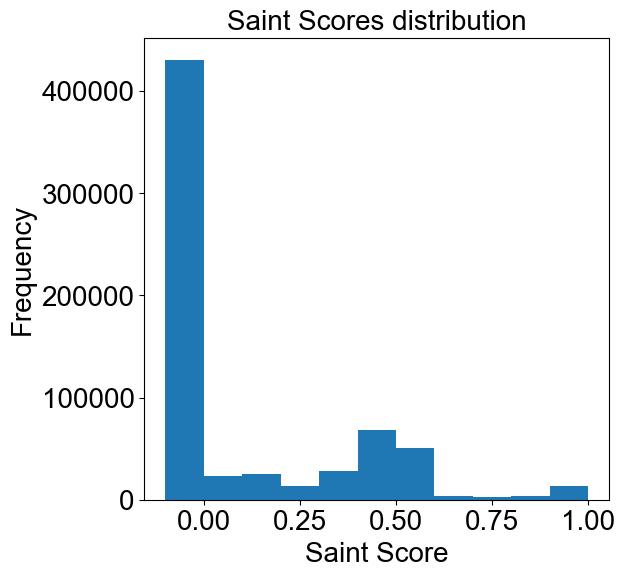

In [139]:
# SAINT score histogram
plt.rcParams.update({"figure.figsize":(6,6)})

fig_p, ax_p = plt.subplots()
vals = WD_SAINT_df['SaintScore'].to_numpy()
counts = plt.hist(vals, bins=[-0.1,0.001,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
# ax_p.set_yscale('log')
# ax_p.set_xscale('log')

plt.xlabel('Saint Score')
plt.ylabel('Frequency')
plt.title('Saint Scores distribution')

plt.show()

In [140]:
# plot P(match | WD) vs WD threshold
def P_SAINT_match(SAINT_thresh, interaction_df):
    thresh_df = interaction_df[interaction_df['SaintScore'] > SAINT_thresh]
    num_thresh = thresh_df.shape[0]
    num_match_thresh = thresh_df[thresh_df['Localization Match'] == 1].shape[0]
    if num_thresh > 0: return num_match_thresh / num_thresh
    else: return -1



In [141]:
# plot overlap between top SAINT and top WD interactions as function of top #
stop = 50000
top_num_arr = np.arange(1, stop, 100)
num_overlap_arr = np.zeros_like(top_num_arr)

WD_sort = WD_SAINT_df.sort_values(['WD Score'], ascending=False)
SAINT_sort = WD_SAINT_df.sort_values(['SaintScore'], ascending=False)

WD_pairs = np.empty(stop, dtype = 'O')
SAINT_pairs = np.empty(stop, dtype = 'O')

for i in tqdm(range(stop)):
    WD_bait = WD_sort['Bait CreID'].to_numpy()[i]
    WD_prey = WD_sort['Prey CreID'].to_numpy()[i]
    SAINT_bait = SAINT_sort['Bait CreID'].to_numpy()[i]
    SAINT_prey = SAINT_sort['Prey CreID'].to_numpy()[i]
    
    WD_pairs[i] = WD_bait + ',' + WD_prey
    SAINT_pairs[i] = SAINT_bait + ',' + SAINT_prey
    

for i in tqdm(range(top_num_arr.shape[0])):
    top_num = top_num_arr[i]
    
    topWD_pairs = WD_pairs[:top_num]
    topSAINT_pairs = SAINT_pairs[:top_num]
    
    num_overlap_arr[i] = np.intersect1d(topWD_pairs, topSAINT_pairs).shape[0]

100%|█████████████████████████████████████████| 500/500 [00:53<00:00,  9.33it/s]


Text(0.5, 1.0, 'WD-SAINT % Interaction Overlap')

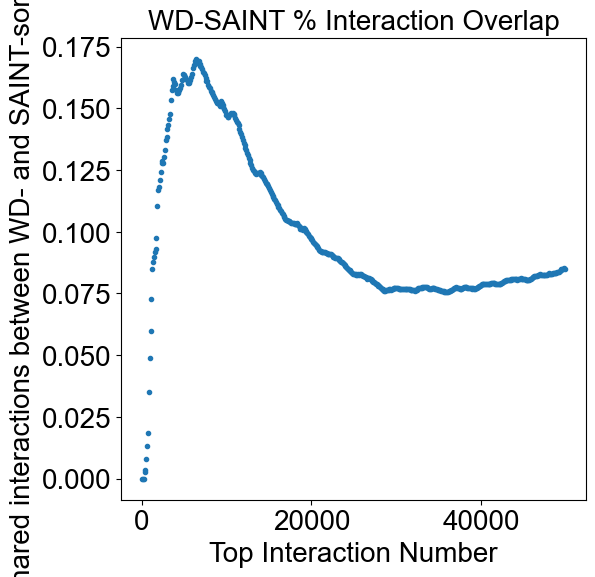

In [142]:
plt.rcParams.update({"figure.figsize":(6,6)})
plt.plot(top_num_arr, num_overlap_arr/top_num_arr, '.')
plt.xlabel('Top Interaction Number')
plt.ylabel('% Shared interactions between WD- and SAINT-sorted lists')
# plt.ylim([0,0.5])
# plt.xlim([-10000,stop])
plt.title('WD-SAINT % Interaction Overlap')

Text(0.5, 1.0, 'WD-SAINT Interaction Overlap')

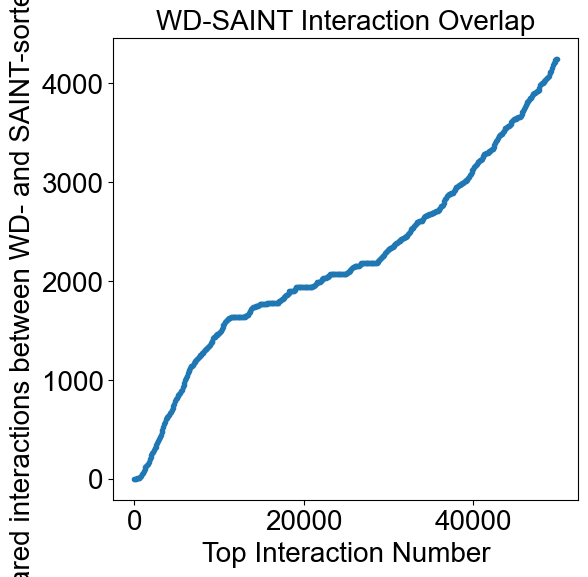

In [143]:
plt.rcParams.update({"figure.figsize":(6,6)})
plt.plot(top_num_arr, num_overlap_arr, '.')
plt.xlabel('Top Interaction Number')
plt.ylabel('Shared interactions between WD- and SAINT-sorted lists')
# plt.ylim([0,0.5])
# plt.xlim([-10000,stop])
plt.title('WD-SAINT Interaction Overlap')

Text(0, 0.5, 'SAINT Score')

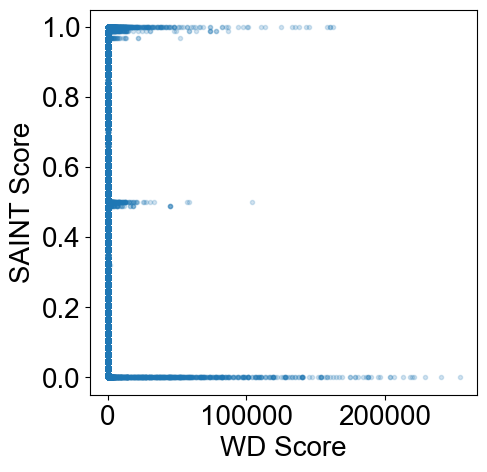

In [144]:
# WD score vs SAINT score scatter plot
plt.rcParams.update({"figure.figsize":(5,5)})
plt.scatter(WD_SAINT_df['WD Score'], WD_SAINT_df['SaintScore'], marker='.', alpha=0.2)
plt.xlabel('WD Score')
plt.ylabel('SAINT Score')

(-100.0, 2000.0)

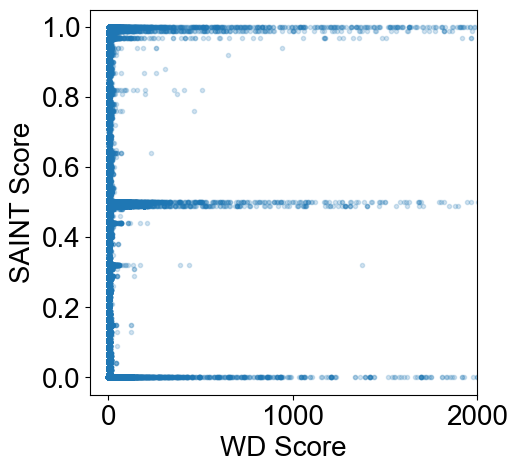

In [145]:
# WD score vs SAINT score scatter plot
plt.rcParams.update({"figure.figsize":(5,5)})
plt.scatter(np.abs(WD_SAINT_df['WD Score']), WD_SAINT_df['SaintScore'], marker='.', alpha=0.2)
plt.xlabel('WD Score')
plt.ylabel('SAINT Score')
plt.xlim([-100, 2000])

#### SAINT no bait or prey other

In [146]:
keep_inds = []

for i in tqdm(range(WD_SAINT_df.shape[0])):
    bloc = WD_SAINT_df['Bait Experimental Localization'].iloc[i]
    bloc_code = exp_loc_dict[bloc]
    
    if np.sum(bloc_code[0:3]) > 0: # keep if bait is in chloroplast, mitochondria, or secretory
        keep_inds.append(i)

WD_SAINT_noBaitOther = WD_SAINT_df.iloc[keep_inds,:].copy()

WD_SAINT_noOther_df = WD_SAINT_noBaitOther[WD_SAINT_noBaitOther['Prey PB-Chlamy Predicted Localization'] != 'Other']


100%|████████████████████████████████| 662610/662610 [00:10<00:00, 61660.74it/s]


In [147]:
start = 0
stop = 1
step = 0.01
thresh_arr = np.arange(start, stop, step)
p_match_arr = np.zeros_like(thresh_arr, dtype='float')
num_interact = np.zeros_like(thresh_arr)

for i in tqdm(range(thresh_arr.shape[0])):
    p_match_arr[i] = P_SAINT_match(thresh_arr[i], WD_SAINT_noOther_df)
    num_interact[i] = WD_SAINT_noOther_df[WD_SAINT_noOther_df['SaintScore'] > thresh_arr[i]].shape[0]

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 36.17it/s]


Text(0.5, 1.0, 'Accuracy Metric vs Saint Score Threshold')

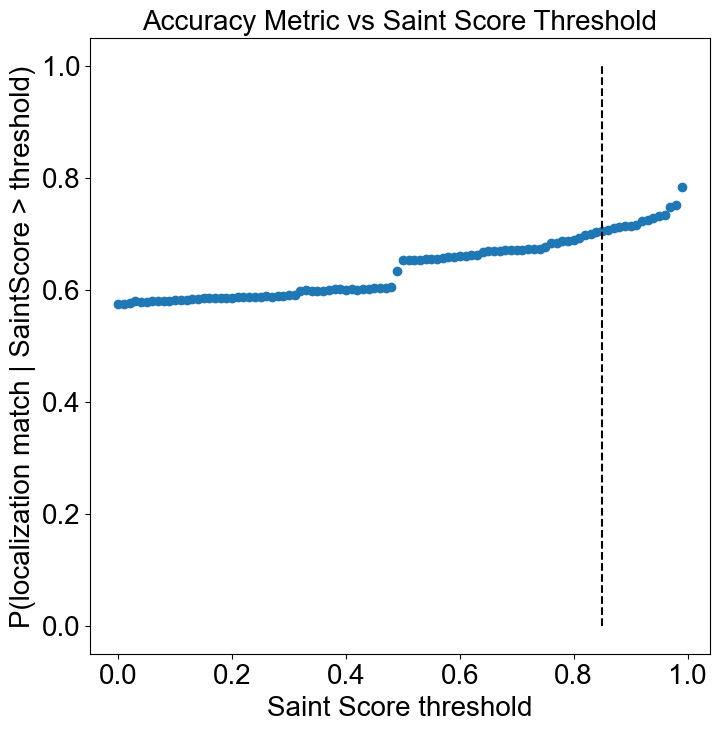

In [148]:
plt.rcParams.update({"figure.figsize":(8,8)})
plt.scatter(thresh_arr, p_match_arr)
plt.plot([0.85,0.85], [0,1], 'k--')
# plt.plot([0.98,0.98], [0,1], 'k--')
# plt.plot([x,x], [0,1], 'k--')
plt.xlabel('Saint Score threshold')
plt.ylabel('P(localization match | SaintScore > threshold)')
# plt.ylim([0,0.5])
# plt.xlim([-10000,stop])
plt.title('Accuracy Metric vs Saint Score Threshold')

In [149]:
# separate p=1 and p=2
noOther_p1_df = WD_SAINT_noOther_df[WD_SAINT_noOther_df['p Value']==1]
noOther_p2_df = WD_SAINT_noOther_df[WD_SAINT_noOther_df['p Value']==2]

start = 0
stop = 1
step = 0.01
thresh_arr = np.arange(start, stop, step)

p1_p_match_arr = np.zeros_like(thresh_arr)
p1_num_interact = np.zeros_like(thresh_arr)

for i in tqdm(range(thresh_arr.shape[0])):
    p1_p_match_arr[i] = P_SAINT_match(thresh_arr[i], noOther_p1_df)
    p1_num_interact[i] = noOther_p1_df[noOther_p1_df['SaintScore'] > thresh_arr[i]].shape[0]
    
    
p2_p_match_arr = np.zeros_like(thresh_arr)
p2_num_interact = np.zeros_like(thresh_arr)

for i in tqdm(range(thresh_arr.shape[0])):
    p2_p_match_arr[i] = P_SAINT_match(thresh_arr[i], noOther_p2_df)
    p2_num_interact[i] = noOther_p2_df[noOther_p2_df['SaintScore'] > thresh_arr[i]].shape[0]

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 81.16it/s]


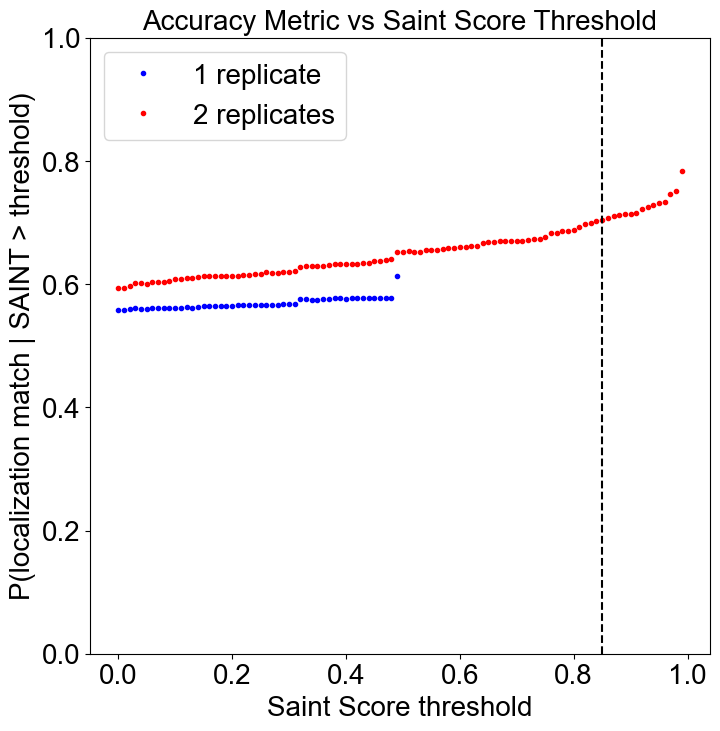

In [150]:
plt.rcParams.update({"figure.figsize":(8,8)})
plt.plot(thresh_arr, p1_p_match_arr, 'b.') # blue = 1 replicate
plt.plot(thresh_arr, p2_p_match_arr, 'r.') # red = 2 replicates
plt.plot([0.85,0.85], [0,1], 'k--')
# plt.plot([x,x], [0,1], 'k--')

plt.xlabel('Saint Score threshold')
plt.ylabel('P(localization match | SAINT > threshold)')
plt.ylim([0,1])
# plt.xlim([-10000,stop])
plt.title('Accuracy Metric vs Saint Score Threshold')
plt.legend(['1 replicate', '2 replicates'])

In [151]:
SAINT_sort[SAINT_sort['SaintScore'] > 0.99]

,Bait CreID,Bait Gene Symbol,Bait Info,Prey CreID,Prey Gene Symbol,Prey Info,WD Score,Z Score,WD Z Score,Rep 1 Spectral Counts,...,Rep 2 Spec,AvgSpec,ctrlCounts,AvgP,MaxP,SaintScore,logOddsScore,FoldChange,BFDR,SAINT p Value
91332,Cre02.g108850,PRPL17,Chloroplast ribosomal protein L17,Cre48.g761197,PRPL3,(1 of 2) K02906 - large subunit ribosomal prot...,11.383651,7.136441,5.313166,42.0,...,41.0,41.5,2|0,1.0,1.0,1.0,23.00,41.50,0.0,2.0
622499,Cre16.g687300,CPLD61,Conserved in the Plant Lineage and Diatoms,Cre14.g612450,PRPL15,Chloroplast ribosomal protein L15,5.684141,0.907863,1.544093,12.0,...,5.0,8.5,1|0,1.0,1.0,1.0,4.76,17.00,0.0,2.0
433921,Cre11.g468450,DLE2,20 kD Calcium-Binding Protein Centrin (caltrac...,Cre16.g685450,DHC8,Axonemal Dynein Heavy Chain 8,4424.254187,33.034098,33.276114,3.0,...,45.0,24.0,0|0,1.0,1.0,1.0,5.48,240.00,0.0,2.0
171951,Cre03.g195650,PRPS10,Chloroplast Ribosomal Protein S1,Cre13.g568650,RPS3A,Cytosolic 80S ribosomal protein S3a,4.758195,2.790006,2.296577,15.0,...,17.0,16.0,3|0,1.0,1.0,1.0,5.04,10.67,0.0,2.0
62608,Cre02.g082550,ZEP1,Zeaxanthin epoxidase,Cre04.g222700,EF3,Elongation Factor 3 and ABC transporter,16.459302,1.469503,3.627301,5.0,...,7.0,6.0,0|0,1.0,1.0,1.0,8.90,60.00,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182934,Cre03.g205600,RSF1,"(1 of 1) PTHR21043:SF1 - PROTEIN IOJAP, CHLORO...",Cre01.g027000,RPL11,Cytosolic 80S ribosomal protein L11,6.364784,3.227597,3.133757,8.0,...,6.0,7.0,1|0,1.0,1.0,1.0,6.21,14.00,0.0,2.0
3894,Cre01.g004400,Not Found,Expressed protein of unknown function,Cre13.g590750,HTB21,Histone H2B,8.955074,4.445680,3.898383,19.0,...,6.0,12.5,1|0,1.0,1.0,1.0,6.21,25.00,0.0,2.0
91193,Cre02.g108850,PRPL17,Chloroplast ribosomal protein L17,Cre12.g494750,PRPS20,Chloroplast ribosomal protein S2,23.222363,2.324930,4.477399,5.0,...,3.0,4.0,0|0,1.0,1.0,1.0,5.48,40.00,0.0,2.0
290147,Cre07.g315100,Not Found,(1 of 2) 1.5.4.1 - Pyrimidodiazepine synthase,Cre06.g265250,HTR12,Histone H3,2.445472,1.319069,1.344289,5.0,...,4.0,4.5,0|0,1.0,1.0,1.0,7.22,45.00,0.0,2.0


### Cluster + TreeView

#### make matrix of Venn Diagram section localization match %

In [ ]:
loc_match_mat = np.zeros_like(WD_mat)

WD_low = 35
WD_high = 140
Z_thresh = 8

for b in tqdm(range(WD_sheet.shape[1])):
    for p in range(WD_sheet.shape[0]):
        WD_score = WD_mat[p,b]
        Z_score = z_mat[p,b]
        p_val = p_mat[p,b]
        flag_check = flag_mat[p,b]
        
        if p_val == 1:
            if Z_score > Z_thresh:
                if WD_score <= WD_low:
                # Z>8 p=1 WD<35 37%
                    loc_match_mat[p,b] = 0.37
                
                elif WD_score > WD_high:
                # Z>8 p=1 WD>140 84%
                    loc_match_mat[p,b] = 0.84
                    
                else:
                # Z>8 p=1 35<WD<140 40% 
                    loc_match_mat[p,b] = 0.4
                    
            else:
                if WD_score <= WD_low:
                # Z<8 p=1 WD<35 50%
                    loc_match_mat[p,b] = 0.5
                    
                elif WD_score > WD_high:
                # Z<8 p=1 WD>140 80%
                    loc_match_mat[p,b] = 0.8
                    
                else:
                # Z<8 p=1 35<WD<140 71%
                    loc_match_mat[p,b] = 0.71
                
        elif p_val == 2:
            if Z_score > Z_thresh:
                if WD_score <= WD_low:
                # Z>8 p=2 WD<35 89%
                    loc_match_mat[p,b] = 0.89
                
                elif WD_score > WD_high:
                # Z>8 p=2 WD>140 90%
                    loc_match_mat[p,b] = 0.9
                    
                else:
                # Z>8 p=2 35<WD<140 80% 
                    loc_match_mat[p,b] = 0.8
            
            else:
                if WD_score <= WD_low:
                # Z<8 p=2 WD<35 55%
                    loc_match_mat[p,b] = 0.55
                
                elif WD_score > WD_high:
                # Z<8 p=2 WD>140 93%
                    loc_match_mat[p,b] = 0.93
                    
                else:
                # Z<8 p=2 35<WD<140 73%
                    loc_match_mat[p,b] = 0.73
                    
        if flag_check:
            loc_match_mat[p,b] = -loc_match_mat[p,b]
                

In [157]:
# copy into WD sheet format
loc_match_sheet = full_sheet.copy()
loc_match_sheet.iloc[13:, 14:] = loc_match_mat

In [ ]:
# export to Excel
with pd.ExcelWriter('loc_match_matrix_negFlag.xlsx', mode='w') as writer:  
    loc_match_sheet.to_excel(writer, sheet_name='neg flag')

In [158]:
full_sheet.iloc[13:, 14:]

,0,1,2,3,4,5,6,7,8,9,...,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108
1,8.580952,5.921419,6.48659,4.531779,9.335797,6.97048,5.878971,6.97048,6.250634,4.852055,...,6.751457,4.954215,3.394226,5.66196,6.250634,5.706022,7.785195,8.162113,6.088252,5.004513
2,4.949747,10.368221,5.049752,5.656854,3.605551,5.612486,5.656854,4.527693,9,7.449832,...,9.192388,5.147815,9.486833,4.358899,2.345208,3.316625,5.522681,4.690416,5.338539,7.516648
3,5,6.204837,5.196152,3.464102,6.204837,4.84768,4.690416,7.071068,5.700877,4.898979,...,5.338539,4,3.872983,3.162278,4,4.1833,4.795832,6.745369,4.636809,4.358899
4,5.622626,6.296257,6.256281,5.798375,7.72756,5.884282,6.093752,7.759961,5.667074,5.754941,...,5.754941,6.492449,3.47036,5.157116,5.157116,5.711177,3.879981,4.480216,4.069358,4.590855
5,6.741201,4.180679,4.180679,0,3.552925,6.454208,0.891324,7.016464,6.355665,0,...,7.944581,2.956187,0,0.891324,0,0,3.565295,3.213714,5.388277,1.543818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### isolate only medium and high confidence (LMR > 0.7) interactions

In [ ]:
start_row = 13
start_col = 14

loc_match_sheet.iloc[start_row:, start_col:]

high_conf_loc_match_sheet = loc_match_sheet.copy()

# delete columns with no interactions with LMR > 0.7
for c in tqdm(np.arange(start_col, loc_match_sheet.shape[1])):
    col_max = np.max(loc_match_sheet.iloc[start_row:, c])
    if col_max < 0.7:
        high_conf_loc_match_sheet = high_conf_loc_match_sheet.drop(columns=loc_match_sheet.columns[c])
        
# delete rows with no interactions with LMR > 0.7
for r in tqdm(np.arange(start_row, loc_match_sheet.shape[0])):
    row_max = np.max(loc_match_sheet.iloc[r, start_col:])
    if row_max < 0.7:
        high_conf_loc_match_sheet = high_conf_loc_match_sheet.drop(index=loc_match_sheet.index[r])
        
# set all remaining values < 0.7 to 0
high_conf_loc_match_sheet.iloc[start_row:, start_col:].mask(high_conf_loc_match_sheet.iloc[start_row:, start_col:] < 0.7, 0, inplace=True)

In [ ]:
# check # prey and bait in original compared to after deleting
print('Original:', loc_match_sheet.shape)
print('High confidence only:', high_conf_loc_match_sheet.shape)

# confirm all LMR > 0.7
print(np.unique(high_conf_loc_match_sheet.iloc[start_row:, start_col:]))


In [ ]:
# export high conf sheet for Cluster + TreeView
with pd.ExcelWriter('highConf_loc_match_matrix_negFlag.xlsx', mode='w') as writer:  
    high_conf_loc_match_sheet.to_excel(writer, sheet_name='neg flag')